In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
%run ./master_experminet-functions.ipynb
# load functions for the creation of the different distributions

In [2]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [3]:
n_samples = 500000
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf"]

In [4]:
#list_distributions = 1000*["Uniform_Sorted"] + 1000*["Normal"] # at first quick sort -> then merge sort 
list_distributions = 500*["Uniform"] +  500*["Uniform_Sorted"] + 500*["Normal"] + 500*["Uniform_Reverse_Sorted"]
#list_distributions = 100*["Uniform"] +  100*["Uniform_Sorted"] + 100*["Normal"] + 100*["Uniform_Reverse_Sorted"]

In [5]:
def plot_history(rewards,cum_rewards,sample_count, sample_mean):

    q_values = {"quick_sort": sample_mean[0], "merge_sort": sample_mean[1], "heap_sort":sample_mean[2]} ## 
    arm_counts = {"quick_sort": sample_count[0], "merge_sort": sample_count[1], "heap_sort":sample_count[2]} ##
    print("Average rewards per algo", q_values)
    print("Count per chosen algo", arm_counts)
    
    fig = plt.figure(figsize=[30,8])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards")
    labels = list(arm_counts.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar([i for i in range(len(arm_counts.values()))], arm_counts.values(), label=[i for i in ((list(arm_counts.keys())))])
    ax3.set_title("Chosen Actions")
    plt.show() 

In [6]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [7]:
def TS_stationary(list_distributions, n_samples, var_multiplier = 5): # initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = 5
    list_iteration_results = []

    len_result = 1

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        array_rewards = np.array(rewards)

    list_iteration_results.extend([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [9]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial
import matplotlib.cm as cm

## Thompson Sampling

# Probabs sampled from t Student distribution

### Quick sort should be the fastest at first 500 itreations, then merge sort for for the next 500, then again quick sort for the next 500, then again merge sort for the next 500: i.e. change points/restart experiment at iteration 500, 1000 and 1500

### First Variant: One sample t-test: 
The One Sample t Test determines whether the sample mean is statistically different from a known or hypothesised population mean or in other words: the p_value is the estimated probability of achieving this value by chance from the sample set.  Generally, if we receive a p-value of less than a selected significance level, we can reject the null hypothesis and state that there is a significant difference, i.e. the sample comes from a different distribution.

In [10]:
def TS_ttest(list_distributions, n_samples, var_multiplier=5,p_val_multiplier=20,num_consec_elem=5):# initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = var_multiplier
    n_consecutive_list = [] # this list is to check whether
    list_iteration_results = []
    p_val_multiplier = p_val_multiplier
    num_consec_elem = num_consec_elem

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))

        tset, pval = ttest_1samp(arm_rewards[choice], reward)
        print("\n")
        print("p-value: ", pval)
        print("Significance level: ", (sample_var[choice]**p_val_multiplier))

        if pval < sample_var[choice]**p_val_multiplier:
            n_consecutive_list.append(n)
            if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    print("RESTART EXPERIMENT AT ITERATION:", n)

                    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                    sample_count = [0 for i in range(num_choices)]
                    sample_rewards = [0 for i in range(num_choices)]
                    sample_mean = [0.0 for i in range(num_choices)]
                    sample_var = [0.0 for i in range(num_choices)]
                    arm_rewards = {0: [], 1:[], 2:[]}
                    rewards = []
                    cum_rewards = []
                    n_consecutive_list = []

    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [11]:
list_iteration_results_TS_ttest, total_reward_TS_ttest = TS_ttest(list_distributions=list_distributions, n_samples=n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.1285131754329084
Less than two values for merge_sort
merge_sort Theta 0.0953831877858986
Less than two values for heap_sort
heap_sort Theta 0.08411301250014591


Chosen algorithm is:  heap_sort with reward: 0.2147711000000001
Sample mean is:  0.2147711000000001 Sample variance is: 0.0


p-value:  nan
Significance level:  0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.9014474289143597
Less than two values for merge_sort
merge_sort Theta 0.9515093111901851
Less than two values for heap_sort
heap_sort Theta 0.44606446397752153


C:\Users\iRacheva\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\iRacheva\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)




Chosen algorithm is:  heap_sort with reward: 0.22961030000000449
Sample mean is:  0.2221907000000023 Sample variance is: 5.5050464160032516e-05


p-value:  0.49999999999999956
Significance level:  6.534610433818219e-86


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.2844625703859459
Less than two values for merge_sort
merge_sort Theta 0.43186713089333906
heap_sort Theta 0.23957152304868207


Chosen algorithm is:  heap_sort with reward: 0.2733634000000009
Sample mean is:  0.2392482666666685 Sample variance is: 0.000618621470615546


p-value:  0.19195282816524442
Significance level:  6.7375155639317926e-65


Iteration: 3
Less than two values for quick_sort
quick_sort Theta 0.7951231893408129
Less than two values for merge_sort
merge_sort Theta 0.3169587921273086
heap_sort Theta 0.2926371561953969


Chosen algorithm is:  heap_sort with reward: 0.219529399999999
Sample mean is:  0.23431855000000112 Sample variance is: 0.0005368724222025139


p-value:  0.349627062457



Chosen algorithm is:  merge_sort with reward: 0.10624220000000406
Sample mean is:  0.10543467000000036 Sample variance is: 6.417898456101558e-06


p-value:  0.3639123543249432
Significance level:  1.4055840756886916e-104


Iteration: 25
quick_sort Theta 0.13010888365070294
merge_sort Theta 0.11091719521223962
heap_sort Theta 0.1714814881604413


Chosen algorithm is:  merge_sort with reward: 0.10159820000000508
Sample mean is:  0.10508590000000079 Sample variance is: 7.05085827090751e-06


p-value:  0.001968892331291029
Significance level:  9.222309658599142e-104


Iteration: 26
quick_sort Theta 0.0949684691196387
merge_sort Theta 0.09888117733557727
heap_sort Theta 0.20160166858593925


Chosen algorithm is:  quick_sort with reward: 0.09858030000000184
Sample mean is:  0.1050812818181829 Sample variance is: 0.00010821194830878244


p-value:  0.07634755437718987
Significance level:  4.847349430580819e-80


Iteration: 27
quick_sort Theta 0.07501020548536506
merge_sort Theta 0.1041452588



Chosen algorithm is:  quick_sort with reward: 0.11092909999999989
Sample mean is:  0.10352208260869597 Sample variance is: 7.909589489449832e-05


p-value:  0.0007575464273746766
Significance level:  9.184994082475274e-83


Iteration: 49
quick_sort Theta 0.10950656154919704
merge_sort Theta 0.11282406186644213
heap_sort Theta -0.001232915580086702


Chosen algorithm is:  heap_sort with reward: 0.2323738999999989
Sample mean is:  0.23040568571428618 Sample variance is: 0.0003629197623697867


p-value:  0.8086608449545567
Significance level:  1.5711308518313934e-69


Iteration: 50
quick_sort Theta 0.10466248648504381
merge_sort Theta 0.10657623339722631
heap_sort Theta 0.15887382396936686


Chosen algorithm is:  quick_sort with reward: 0.09424609999999944
Sample mean is:  0.10313558333333361 Sample variance is: 7.923601147390696e-05


p-value:  7.870347234472894e-05
Significance level:  9.515949402828915e-83


Iteration: 51
quick_sort Theta 0.09709510401434622
merge_sort Theta 0.110733

Iteration: 73
quick_sort Theta 0.1076918376781095
merge_sort Theta 0.11240712294219037
heap_sort Theta 0.18810049798180342


Chosen algorithm is:  quick_sort with reward: 0.10694569999999715
Sample mean is:  0.10230307250000034 Sample variance is: 5.999077789350578e-05


p-value:  0.0005850581131958602
Significance level:  3.6449356751572777e-85


Iteration: 74
quick_sort Theta 0.10656566909529623
merge_sort Theta 0.10622750224351418
heap_sort Theta 0.28102523022479153


Chosen algorithm is:  merge_sort with reward: 0.12109810000000465
Sample mean is:  0.10823971785714345 Sample variance is: 4.20608983886051e-05


p-value:  7.467804524017317e-11
Significance level:  3.003107599234142e-88


Iteration: 75
quick_sort Theta 0.09714186401614773
merge_sort Theta 0.1087359581576886
heap_sort Theta 0.22184111593374603


Chosen algorithm is:  quick_sort with reward: 0.10104030000000108
Sample mean is:  0.10227227317073208 Sample variance is: 5.8565532136121164e-05


p-value:  0.3147273540601171



Chosen algorithm is:  quick_sort with reward: 0.10072259999999744
Sample mean is:  0.10323040727272738 Sample variance is: 0.00014275789095123643


p-value:  0.12882201945415378
Significance level:  1.2359544477284382e-77


Iteration: 98
quick_sort Theta 0.09551144264041772
merge_sort Theta 0.10259949705634391
heap_sort Theta 0.24652728122770193


Chosen algorithm is:  quick_sort with reward: 0.09919550000000044
Sample mean is:  0.10315835535714298 Sample variance is: 0.0001404941742182018


p-value:  0.016250333981958708
Significance level:  8.977725451481832e-78


Iteration: 99
quick_sort Theta 0.10697486036057595
merge_sort Theta 0.10140294938426228
heap_sort Theta 0.20832750922695648


Chosen algorithm is:  merge_sort with reward: 0.11047849999999926
Sample mean is:  0.10824921111111152 Sample variance is: 3.550971290820272e-05


p-value:  0.03349546888955851
Significance level:  1.0161158409312526e-89


Iteration: 100
quick_sort Theta 0.10576767913396345
merge_sort Theta 0.10549

merge_sort Theta 0.10234004491627711
heap_sort Theta 0.2382159733850695


Chosen algorithm is:  quick_sort with reward: 0.09571579999999358
Sample mean is:  0.10309821621621655 Sample variance is: 0.0001659737557151482


p-value:  5.688746248254088e-06
Significance level:  2.5164507177285638e-76


Iteration: 123
quick_sort Theta 0.1032894960086092
merge_sort Theta 0.1099482070391421
heap_sort Theta 0.2223420117467552


Chosen algorithm is:  quick_sort with reward: 0.09705180000000269
Sample mean is:  0.1030175973333337 Sample variance is: 0.00016424172822213155


p-value:  0.00014637846119767154
Significance level:  2.0401876974714704e-76


Iteration: 124
quick_sort Theta 0.09721353844775618
merge_sort Theta 0.10138345513528507
heap_sort Theta 0.28248985641898106


Chosen algorithm is:  quick_sort with reward: 0.09245719999999835
Sample mean is:  0.10287864473684244 Sample variance is: 0.00016352873965616235


p-value:  7.238559467285092e-10
Significance level:  1.8701730381151572e-76


heap_sort Theta 0.23390466303848384


Chosen algorithm is:  quick_sort with reward: 0.096771099999998
Sample mean is:  0.1015909610526318 Sample variance is: 0.0001381946167289106


p-value:  0.00013798781110980696
Significance level:  6.453904203780587e-78


Iteration: 148
quick_sort Theta 0.09707422556002464
merge_sort Theta 0.11237996683899164
heap_sort Theta 0.2777614464525902


Chosen algorithm is:  quick_sort with reward: 0.09832819999999742
Sample mean is:  0.10155697395833352 Sample variance is: 0.00013686482611630755


p-value:  0.008441118918373954
Significance level:  5.319085848160922e-78


Iteration: 149
quick_sort Theta 0.10838441667896186
merge_sort Theta 0.11014044514117864
heap_sort Theta 0.2270435771384811


Chosen algorithm is:  quick_sort with reward: 0.09378389999999115
Sample mean is:  0.10147683917525782 Sample variance is: 0.00013607032053950416


p-value:  4.2787384076593334e-09
Significance level:  4.734434984971862e-78


Iteration: 150
quick_sort Theta 0.0960



Iteration: 172
quick_sort Theta 0.1073379319240095
merge_sort Theta 0.11461459117481297
heap_sort Theta 0.2982539067708374


Chosen algorithm is:  quick_sort with reward: 0.10665230000000747
Sample mean is:  0.10155206460177033 Sample variance is: 0.0001195181882665427


p-value:  2.7865905559516393e-06
Significance level:  3.537366219295546e-79


Iteration: 173
quick_sort Theta 0.09705316626131297
merge_sort Theta 0.10184653265139668
heap_sort Theta 0.29475134897895683


Chosen algorithm is:  quick_sort with reward: 0.13766229999998814
Sample mean is:  0.10186882105263188 Sample variance is: 0.0001298075984616624


p-value:  2.2311569842989492e-60
Significance level:  1.845025208804193e-78


Iteration: 174
quick_sort Theta 0.10357543604050111
merge_sort Theta 0.11608327802436832
heap_sort Theta 0.240497292228564


Chosen algorithm is:  quick_sort with reward: 0.09828790000000254
Sample mean is:  0.10183768260869598 Sample variance is: 0.00012878937144265428


p-value:  0.00113378965


Iteration: 196
quick_sort Theta 0.10018858586277597
merge_sort Theta 0.10734965605938147
heap_sort Theta 0.24851352508873742


Chosen algorithm is:  quick_sort with reward: 0.10189059999999017
Sample mean is:  0.10222580518518551 Sample variance is: 0.00011806291064819492


p-value:  0.7215685450519851
Significance level:  2.76866057660509e-79


Iteration: 197
quick_sort Theta 0.11251847475880047
merge_sort Theta 0.1050606107958423
heap_sort Theta 0.21665107721829063


Chosen algorithm is:  merge_sort with reward: 0.10754609999999332
Sample mean is:  0.10865710740740732 Sample variance is: 3.8300479591417357e-05


p-value:  0.1968783298428023
Significance level:  4.6140706823126895e-89


Iteration: 198
quick_sort Theta 0.09945368144402417
merge_sort Theta 0.10694889678029937
heap_sort Theta 0.2041886529089465


Chosen algorithm is:  quick_sort with reward: 0.0925440999999978
Sample mean is:  0.1021546161764709 Sample variance is: 0.00011787896413091474


p-value:  1.1198282585797516e-

merge_sort Theta 0.10815588552868619
heap_sort Theta 0.22190752553848112


Chosen algorithm is:  merge_sort with reward: 0.1090101000000061
Sample mean is:  0.10861025833333299 Sample variance is: 3.459397692442291e-05


p-value:  0.6035054838391091
Significance level:  6.02573221715913e-90


Iteration: 222
quick_sort Theta 0.10364230581508545
merge_sort Theta 0.10716699379012609
heap_sort Theta 0.2120208937055581


Chosen algorithm is:  quick_sort with reward: 0.10315420000000586
Sample mean is:  0.10156879025974092 Sample variance is: 0.00010833403588620182


p-value:  0.06144804331852615
Significance level:  4.957907888678397e-80


Iteration: 223
quick_sort Theta 0.10568254055117049
merge_sort Theta 0.10975974652688004
heap_sort Theta 0.2869965033294393


Chosen algorithm is:  quick_sort with reward: 0.09363159999999482
Sample mean is:  0.10151758258064578 Sample variance is: 0.00010803892948775967


p-value:  6.573343117969142e-17
Significance level:  4.6946740631605274e-80


Itera



Iteration: 246
quick_sort Theta 0.10057953644311919
merge_sort Theta 0.1076810460547668
heap_sort Theta 0.3215975788351279


Chosen algorithm is:  quick_sort with reward: 0.09694220000000087
Sample mean is:  0.10146989600000057 Sample variance is: 9.84408559833542e-05


p-value:  1.0095672976522101e-08
Significance level:  7.303106405169653e-81


Iteration: 247
quick_sort Theta 0.09865300098262167
merge_sort Theta 0.10862709228586503
heap_sort Theta 0.1966303119681088


Chosen algorithm is:  quick_sort with reward: 0.1086350000000067
Sample mean is:  0.10151060681818241 Sample variance is: 9.81715728134755e-05


p-value:  1.4862738167790613e-17
Significance level:  6.913770803002549e-81


Iteration: 248
quick_sort Theta 0.10435617734623108
merge_sort Theta 0.10851767520948395
heap_sort Theta 0.24891076957746863


Chosen algorithm is:  quick_sort with reward: 0.09362060000000838
Sample mean is:  0.10146603050847522 Sample variance is: 9.79666514992938e-05


p-value:  2.235234915874045



Chosen algorithm is:  quick_sort with reward: 0.09895840000000078
Sample mean is:  0.10173592704081699 Sample variance is: 0.00010253181519441844


p-value:  0.0001723935209335148
Significance level:  1.6488187647585678e-80


Iteration: 270
quick_sort Theta 0.10153551735878981
merge_sort Theta 0.10824446779552353
heap_sort Theta 0.2549975528042003


Chosen algorithm is:  quick_sort with reward: 0.09573180000001003
Sample mean is:  0.10170544923857938 Sample variance is: 0.00010219341282757158


p-value:  1.9754350078757257e-14
Significance level:  1.5433273757947574e-80


Iteration: 271
quick_sort Theta 0.10156550747578319
merge_sort Theta 0.10996299989760597
heap_sort Theta 0.29410067593344


Chosen algorithm is:  quick_sort with reward: 0.09684310000000096
Sample mean is:  0.10168089191919263 Sample variance is: 0.00010179608768124386


p-value:  1.8057655428394254e-10
Significance level:  1.4276499764729491e-80


Iteration: 272
quick_sort Theta 0.10076217143436164
merge_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.09937680000000171
Sample mean is:  0.10218515272727348 Sample variance is: 0.00011558031541494182


p-value:  0.00014598433807730296
Significance level:  1.8099955459330756e-79


Iteration: 294
quick_sort Theta 0.1068087537310889
merge_sort Theta 0.10312731551280983
heap_sort Theta 0.28095229529030596


Chosen algorithm is:  merge_sort with reward: 0.10214340000000277
Sample mean is:  0.10844132923076881 Sample variance is: 3.431324527590755e-05


p-value:  2.8225065266690666e-12
Significance level:  5.119598386082558e-90


Iteration: 295
quick_sort Theta 0.10044924672988961
merge_sort Theta 0.10487387934937985
heap_sort Theta 0.24963792862316267


Chosen algorithm is:  quick_sort with reward: 0.09530349999999999
Sample mean is:  0.10215401402715006 Sample variance is: 0.00011527064366436816


p-value:  4.767253640346733e-18
Significance level:  1.7154353874235417e-79


Iteration: 296
quick_sort Theta 0.09969200512344137
merge_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.09988760000000241
Sample mean is:  0.10201899665272042 Sample variance is: 0.00011000456285521415


p-value:  0.001934152597670465
Significance level:  6.733083350722858e-80


Iteration: 318
quick_sort Theta 0.10024816583494718
merge_sort Theta 0.10900354795285686
heap_sort Theta 0.25280417917687836


Chosen algorithm is:  quick_sort with reward: 0.09295860000000289
Sample mean is:  0.10198124500000076 Sample variance is: 0.00010988683027063675


p-value:  1.3330305768269318e-30
Significance level:  6.590417432118044e-80


Iteration: 319
quick_sort Theta 0.10069245754959563
merge_sort Theta 0.11151053006085115
heap_sort Theta 0.2425713747422864


Chosen algorithm is:  quick_sort with reward: 0.10817340000001252
Sample mean is:  0.10200693858921242 Sample variance is: 0.000109589306845685


p-value:  3.003055305499118e-17
Significance level:  6.2425725795768336e-80


Iteration: 320
quick_sort Theta 0.10309696332759585
merge_sort Theta 0.



Chosen algorithm is:  merge_sort with reward: 0.11219079999999337
Sample mean is:  0.10851494520547944 Sample variance is: 3.2627329523840104e-05


p-value:  6.421696188736361e-07
Significance level:  1.8690915910425342e-90


Iteration: 342
quick_sort Theta 0.09979766316690063
merge_sort Theta 0.11479927388741115
heap_sort Theta 0.22441369963319485


Chosen algorithm is:  quick_sort with reward: 0.09496640000000411
Sample mean is:  0.10233961269230846 Sample variance is: 0.00011236998665626017


p-value:  5.518931133260539e-24
Significance level:  1.0304017458158615e-79


Iteration: 343
quick_sort Theta 0.1025264428779818
merge_sort Theta 0.10719185601775262
heap_sort Theta 0.2497325105155635


Chosen algorithm is:  quick_sort with reward: 0.09504590000000235
Sample mean is:  0.10231166743295096 Sample variance is: 0.00011214249406426319


p-value:  1.438145856498653e-23
Significance level:  9.894736032136813e-80


Iteration: 344
quick_sort Theta 0.10188186616687829
merge_sort Theta 



Chosen algorithm is:  quick_sort with reward: 0.09666959999999847
Sample mean is:  0.10197841642857211 Sample variance is: 0.0001065647650867284


p-value:  6.258288476554624e-16
Significance level:  3.566749740272072e-80


Iteration: 366
quick_sort Theta 0.10016673758048619
merge_sort Theta 0.11230222663938656
heap_sort Theta 0.24510456489616567


Chosen algorithm is:  quick_sort with reward: 0.12048810000000287
Sample mean is:  0.10204428718861279 Sample variance is: 0.00010740043901520815


p-value:  9.052079187496801e-89
Significance level:  4.169856717313797e-80


Iteration: 367
quick_sort Theta 0.10793085498764021
merge_sort Theta 0.11010469442792722
heap_sort Theta 0.19536497666230832


Chosen algorithm is:  quick_sort with reward: 0.0926051000000001
Sample mean is:  0.10201081489361771 Sample variance is: 0.00010733441725814564


p-value:  1.4670096918681689e-38
Significance level:  4.1188886849437875e-80


Iteration: 368
quick_sort Theta 0.10536773352026034
merge_sort Theta 



Chosen algorithm is:  quick_sort with reward: 0.1003495000000072
Sample mean is:  0.10172410993377545 Sample variance is: 0.00010367316159864315


p-value:  0.01982048430211686
Significance level:  2.0574384799810766e-80


Iteration: 390
quick_sort Theta 0.10415781762526048
merge_sort Theta 0.10905781651668692
heap_sort Theta 0.2204305004895586


Chosen algorithm is:  quick_sort with reward: 0.12074389999999369
Sample mean is:  0.1017868815181524 Sample variance is: 0.00010452096803497116


p-value:  9.721164620935041e-100
Significance level:  2.421410754760354e-80


Iteration: 391
quick_sort Theta 0.10472030238518601
merge_sort Theta 0.10153000440892715
heap_sort Theta 0.2797327919122575


Chosen algorithm is:  merge_sort with reward: 0.11422390000001315
Sample mean is:  0.10850766455696184 Sample variance is: 3.5356805088105366e-05


p-value:  1.0535338555164494e-12
Significance level:  9.320952351001031e-90


Iteration: 392
quick_sort Theta 0.10543630370320158
merge_sort Theta 0.1



Iteration: 413
quick_sort Theta 0.10232796340376629
merge_sort Theta 0.10504882573036838
heap_sort Theta 0.2112459747456148


Chosen algorithm is:  quick_sort with reward: 0.11690259999998887
Sample mean is:  0.10167268487654368 Sample variance is: 0.00010475211545084787


p-value:  6.813180958616672e-84
Significance level:  2.5307896202249763e-80


Iteration: 414
quick_sort Theta 0.09864340829660076
merge_sort Theta 0.1045063103498188
heap_sort Theta 0.28755257387556027


Chosen algorithm is:  quick_sort with reward: 0.09462529999998992
Sample mean is:  0.10165100061538505 Sample variance is: 0.0001045821483764272


p-value:  4.903791441973308e-29
Significance level:  2.4499159288366867e-80


Iteration: 415
quick_sort Theta 0.10372029991810884
merge_sort Theta 0.11136683267740886
heap_sort Theta 0.2258033805487839


Chosen algorithm is:  quick_sort with reward: 0.11911459999998897
Sample mean is:  0.10170456993865071 Sample variance is: 0.00010519398776872381


p-value:  9.970793936



Iteration: 437
quick_sort Theta 0.09972629661011938
merge_sort Theta 0.10769363599653453
heap_sort Theta 0.25197642973950046


Chosen algorithm is:  quick_sort with reward: 0.0964626000000095
Sample mean is:  0.10150271647398887 Sample variance is: 0.00010153099764796234


p-value:  1.771741943872645e-18
Significance level:  1.3551053878645542e-80


Iteration: 438
quick_sort Theta 0.10126473360505726
merge_sort Theta 0.10997393492389133
heap_sort Theta 0.24374311806891527


Chosen algorithm is:  quick_sort with reward: 0.09443179999999529
Sample mean is:  0.10148233919308398 Sample variance is: 0.00010138207193062225


p-value:  7.823436646324259e-32
Significance level:  1.3159011056313966e-80


Iteration: 439
quick_sort Theta 0.09951098245346757
merge_sort Theta 0.10897913113304294
heap_sort Theta 0.19296861039881422


Chosen algorithm is:  quick_sort with reward: 0.09589640000000088
Sample mean is:  0.10146628764367857 Sample variance is: 0.00010118014946441323


p-value:  6.172839



Chosen algorithm is:  quick_sort with reward: 0.09369089999999858
Sample mean is:  0.1012312754768396 Sample variance is: 9.948688314272075e-05


p-value:  8.160532471627119e-38
Significance level:  9.02228410282549e-81


Iteration: 461
quick_sort Theta 0.09949009056851194
merge_sort Theta 0.10873052597660424
heap_sort Theta 0.23935109858361017


Chosen algorithm is:  quick_sort with reward: 0.09346829999999784
Sample mean is:  0.10121018043478296 Sample variance is: 9.937985364494129e-05


p-value:  1.6558871021717905e-39
Significance level:  8.83012917019306e-81


Iteration: 462
quick_sort Theta 0.10312021877426535
merge_sort Theta 0.10909474516106413
heap_sort Theta 0.23529745412535166


Chosen algorithm is:  quick_sort with reward: 0.09668520000001024
Sample mean is:  0.10119791761517653 Sample variance is: 9.916587019039205e-05


p-value:  1.1804597848263717e-16
Significance level:  8.457549420660918e-81


Iteration: 463
quick_sort Theta 0.09614947547925881
merge_sort Theta 0.10

merge_sort Theta 0.10232122683724433
heap_sort Theta 0.2632772983468119


Chosen algorithm is:  quick_sort with reward: 0.09386279999999658
Sample mean is:  0.10098718406169711 Sample variance is: 9.69643042843202e-05


p-value:  2.3331401120418e-37
Significance level:  5.39806009505953e-81


Iteration: 486
quick_sort Theta 0.09549693589030041
merge_sort Theta 0.10329647866172152
heap_sort Theta 0.1944592398321394


Chosen algorithm is:  quick_sort with reward: 0.09666800000000819
Sample mean is:  0.1009761092307697 Sample variance is: 9.676338944442583e-05


p-value:  1.498855278715441e-16
Significance level:  5.178708307725393e-81


Iteration: 487
quick_sort Theta 0.09790906251216419
merge_sort Theta 0.10856328537488033
heap_sort Theta 0.19194823384500845


Chosen algorithm is:  quick_sort with reward: 0.10147340000000327
Sample mean is:  0.10097738107416927 Sample variance is: 9.651654360347634e-05


p-value:  0.3193442796587569
Significance level:  4.920794358097423e-81


Iteration



Iteration: 508
Less than two values for quick_sort
quick_sort Theta 0.5299364661771122
merge_sort Theta 0.026169350636380196
Less than two values for heap_sort
heap_sort Theta 0.51884175750815


Chosen algorithm is:  merge_sort with reward: 0.02548249999999541
Sample mean is:  0.02590803333332777 Sample variance is: 9.856203555557763e-08


p-value:  0.1953010561657592
Significance level:  7.485025493706189e-141


Iteration: 509
Less than two values for quick_sort
quick_sort Theta 0.7653350512839254
merge_sort Theta 0.0264344772132809
Less than two values for heap_sort
heap_sort Theta 0.1733463846646487


Chosen algorithm is:  merge_sort with reward: 0.02655439999999487
Sample mean is:  0.026069624999994545 Sample variance is: 1.522571268751219e-07


p-value:  0.12049748997600038
Significance level:  4.4828334725721125e-137


Iteration: 510
Less than two values for quick_sort
quick_sort Theta 0.9928780097531168
merge_sort Theta 0.026155856659494617
Less than two values for heap_sort
h



Iteration: 530
quick_sort Theta 0.0315177509595969
merge_sort Theta 0.02609158199480165
heap_sort Theta 0.06619281945048182


Chosen algorithm is:  merge_sort with reward: 0.025869199999988268
Sample mean is:  0.02581685238095385 Sample variance is: 2.1837780344464875e-07


p-value:  0.6218643599542434
Significance level:  6.083729087970382e-134


Iteration: 531
quick_sort Theta 0.032316327321297626
merge_sort Theta 0.025371370011740384
heap_sort Theta 0.066240470996357


Chosen algorithm is:  merge_sort with reward: 0.02656880000000683
Sample mean is:  0.02585103181818353 Sample variance is: 2.3298445216780198e-07


p-value:  9.736163460523897e-07
Significance level:  2.2209501019777718e-133


Iteration: 532
quick_sort Theta 0.031482629959515084
merge_sort Theta 0.026351927609856177
heap_sort Theta 0.06616205523725664


Chosen algorithm is:  merge_sort with reward: 0.025343099999986407
Sample mean is:  0.025828947826088 Sample variance is: 2.3358415292915417e-07


p-value:  0.000105



Iteration: 554
quick_sort Theta 0.03184956546163473
merge_sort Theta 0.02679809032404729
heap_sort Theta 0.06619299424970136


Chosen algorithm is:  merge_sort with reward: 0.02544519999997874
Sample mean is:  0.026211153333333452 Sample variance is: 2.015809502484669e-06


p-value:  0.0008560937100061006
Significance level:  1.227410297497001e-114


Iteration: 555
quick_sort Theta 0.03167973765241019
merge_sort Theta 0.026742092862166257
heap_sort Theta 0.06620126555814675


Chosen algorithm is:  merge_sort with reward: 0.02532539999998562
Sample mean is:  0.02619189782608676 Sample variance is: 1.9886724119482137e-06


p-value:  0.00015931991580483404
Significance level:  9.359765751920023e-115


Iteration: 556
quick_sort Theta 0.032363659266246285
merge_sort Theta 0.02603411415685262
heap_sort Theta 0.06621899408314233


Chosen algorithm is:  merge_sort with reward: 0.025422999999989315
Sample mean is:  0.02617553829787192 Sample variance is: 1.95867140448755e-06


p-value:  0.000



Iteration: 579
quick_sort Theta 0.030945897063110052
merge_sort Theta 0.025310215806606362
heap_sort Theta 0.06619521352700602


Chosen algorithm is:  merge_sort with reward: 0.026322899999996707
Sample mean is:  0.02657696142857101 Sample variance is: 4.008821714655148e-06


p-value:  0.29554401886909043
Significance level:  1.1490391966409705e-108


Iteration: 580
quick_sort Theta 0.032743162244904214
merge_sort Theta 0.02650296542299717
heap_sort Theta 0.06620554138907818


Chosen algorithm is:  merge_sort with reward: 0.02548720000001481
Sample mean is:  0.026561612676056136 Sample variance is: 3.968850331247353e-06


p-value:  2.5232947744708544e-05
Significance level:  9.403606163648996e-109


Iteration: 581
quick_sort Theta 0.029373109403075637
merge_sort Theta 0.025288841702383276
heap_sort Theta 0.06618521909090169


Chosen algorithm is:  merge_sort with reward: 0.03192300000000614
Sample mean is:  0.026636076388888777 Sample variance is: 4.30741137152637e-06


p-value:  9.1



Iteration: 603
quick_sort Theta 0.03201917964176645
merge_sort Theta 0.027554412876288376
heap_sort Theta 0.06619309063764046


Chosen algorithm is:  merge_sort with reward: 0.028372300000000905
Sample mean is:  0.02701189999999919 Sample variance is: 5.5344388640380295e-06


p-value:  2.390940402192841e-07
Significance level:  7.268953452786942e-106


Iteration: 604
quick_sort Theta 0.031392551229153326
merge_sort Theta 0.026247167786950618
heap_sort Theta 0.06623554843968345


Chosen algorithm is:  merge_sort with reward: 0.025381799999991017
Sample mean is:  0.02699474105263068 Sample variance is: 5.503857983468378e-06


p-value:  1.7813738489391814e-09
Significance level:  6.506454313914256e-106


Iteration: 605
quick_sort Theta 0.031264885127401824
merge_sort Theta 0.02678224019528936
heap_sort Theta 0.06619234701811674


Chosen algorithm is:  merge_sort with reward: 0.026684799999998177
Sample mean is:  0.026991512499999093 Sample variance is: 5.447516366922934e-06


p-value:  



Iteration: 627
quick_sort Theta 0.03102714438674029
merge_sort Theta 0.02517505281466412
heap_sort Theta 0.06625307720679313


Chosen algorithm is:  merge_sort with reward: 0.02584210000000553
Sample mean is:  0.027232683760683482 Sample variance is: 6.491302454007222e-06


p-value:  4.063376292352752e-08
Significance level:  1.7645619091688624e-104


Iteration: 628
quick_sort Theta 0.03212077605092007
merge_sort Theta 0.026794670149634152
heap_sort Theta 0.06620391034217865


Chosen algorithm is:  merge_sort with reward: 0.02592379999998684
Sample mean is:  0.02722159152542334 Sample variance is: 6.450686825180157e-06


p-value:  2.0047738380913943e-07
Significance level:  1.556392596565601e-104


Iteration: 629
quick_sort Theta 0.031540779141912056
merge_sort Theta 0.027976892174806877
heap_sort Theta 0.06620363428015122


Chosen algorithm is:  merge_sort with reward: 0.025998499999985825
Sample mean is:  0.027211313445377645 Sample variance is: 6.40894476653995e-06


p-value:  8.3



Iteration: 651
quick_sort Theta 0.03124151495584636
merge_sort Theta 0.027145039652132268
heap_sort Theta 0.06618578258159863


Chosen algorithm is:  merge_sort with reward: 0.02816959999998403
Sample mean is:  0.027303133333332858 Sample variance is: 6.091517710445058e-06


p-value:  5.657673818405058e-05
Significance level:  4.948917616367844e-105


Iteration: 652
quick_sort Theta 0.03289338840582535
merge_sort Theta 0.028048779711822083
heap_sort Theta 0.06619582560996526


Chosen algorithm is:  merge_sort with reward: 0.027372900000017353
Sample mean is:  0.027303624647886972 Sample variance is: 6.048653734388414e-06


p-value:  0.7385209006355429
Significance level:  4.297090156648136e-105


Iteration: 653
quick_sort Theta 0.03133669823405004
merge_sort Theta 0.02598680560277155
heap_sort Theta 0.0661952395311834


Chosen algorithm is:  merge_sort with reward: 0.026402499999989004
Sample mean is:  0.02729732307692265 Sample variance is: 6.0119942476453665e-06


p-value:  2.59601



Iteration: 675
quick_sort Theta 0.0317921555961838
merge_sort Theta 0.029839736403580158
heap_sort Theta 0.06620148394450796


Chosen algorithm is:  merge_sort with reward: 0.026889799999992192
Sample mean is:  0.02745400242424151 Sample variance is: 5.852626332837643e-06


p-value:  0.003253586621561659
Significance level:  2.2233914953141697e-105


Iteration: 676
quick_sort Theta 0.03233136045401799
merge_sort Theta 0.028000246875926463
heap_sort Theta 0.06618792972612311


Chosen algorithm is:  merge_sort with reward: 0.027267099999988886
Sample mean is:  0.02745287650602312 Sample variance is: 5.8175787168527575e-06


p-value:  0.32392756936332645
Significance level:  1.971720571344937e-105


Iteration: 677
quick_sort Theta 0.03197117751169592
merge_sort Theta 0.02857013339151409
heap_sort Theta 0.06619708599926376


Chosen algorithm is:  merge_sort with reward: 0.026679999999998927
Sample mean is:  0.027448248502993038 Sample variance is: 5.786298372552757e-06


p-value:  6.0881



Iteration: 699
quick_sort Theta 0.03149347743855474
merge_sort Theta 0.02662360080369301
heap_sort Theta 0.06616462799190871


Chosen algorithm is:  merge_sort with reward: 0.02929009999999721
Sample mean is:  0.027490014285713748 Sample variance is: 5.4112122469347615e-06


p-value:  6.558393850846088e-21
Significance level:  4.633310195175316e-106


Iteration: 700
quick_sort Theta 0.032047670504286155
merge_sort Theta 0.026128992789667647
heap_sort Theta 0.06620425671480931


Chosen algorithm is:  merge_sort with reward: 0.028551700000008395
Sample mean is:  0.027495602105262668 Sample variance is: 5.388633466939042e-06


p-value:  2.5999824695093363e-09
Significance level:  4.2616019321619584e-106


Iteration: 701
quick_sort Theta 0.031352690434172506
merge_sort Theta 0.026827926984249052
heap_sort Theta 0.06623410528091175


Chosen algorithm is:  merge_sort with reward: 0.02939430000000698
Sample mean is:  0.027505542931936723 Sample variance is: 5.379196532917522e-06


p-value: 



Iteration: 723
quick_sort Theta 0.03198220159462307
merge_sort Theta 0.02718016235977043
heap_sort Theta 0.06619593459005625


Chosen algorithm is:  merge_sort with reward: 0.025470399999989013
Sample mean is:  0.027543176303316746 Sample variance is: 5.135899228629498e-06


p-value:  1.5435953449446004e-29
Significance level:  1.6305340677957688e-106


Iteration: 724
quick_sort Theta 0.03137193510462962
merge_sort Theta 0.02747836206366398
heap_sort Theta 0.0661963569132739


Chosen algorithm is:  merge_sort with reward: 0.03086859999999092
Sample mean is:  0.027558862264150115 Sample variance is: 5.1635897053649325e-06


p-value:  4.6494579681365727e-54
Significance level:  1.8156599985544696e-106


Iteration: 725
quick_sort Theta 0.02934177354036728
merge_sort Theta 0.02759219738159021
heap_sort Theta 0.06619310517992083


Chosen algorithm is:  merge_sort with reward: 0.02907089999999357
Sample mean is:  0.027565961032862997 Sample variance is: 5.150030713830088e-06


p-value:  1.



Iteration: 747
quick_sort Theta 0.03522351279692139
merge_sort Theta 0.02810602226255734
heap_sort Theta 0.06613977170575056


Chosen algorithm is:  merge_sort with reward: 0.028668100000004415
Sample mean is:  0.027562916017315153 Sample variance is: 4.851160331298102e-06


p-value:  7.013566404654246e-13
Significance level:  5.2108979341169134e-107


Iteration: 748
quick_sort Theta 0.03426560107913065
merge_sort Theta 0.028909348463841862
heap_sort Theta 0.06620915756886685


Chosen algorithm is:  merge_sort with reward: 0.025265599999983124
Sample mean is:  0.027553013793102515 Sample variance is: 4.852900641702849e-06


p-value:  1.4731106256038213e-38
Significance level:  5.248412887160573e-107


Iteration: 749
quick_sort Theta 0.03264703272145476
merge_sort Theta 0.028183184262845763
heap_sort Theta 0.06619741116300766


Chosen algorithm is:  merge_sort with reward: 0.029534800000021733
Sample mean is:  0.027561519313303886 Sample variance is: 4.848856520696903e-06


p-value:  



Iteration: 771
quick_sort Theta 0.03437383445830947
merge_sort Theta 0.029044327579154774
heap_sort Theta 0.06627705168791437


Chosen algorithm is:  merge_sort with reward: 0.027060000000005857
Sample mean is:  0.02754962274509753 Sample variance is: 4.624325513753781e-06


p-value:  0.00034430030529045006
Significance level:  1.9997142600648298e-107


Iteration: 772
quick_sort Theta 0.02997765704602026
merge_sort Theta 0.02794409567247044
heap_sort Theta 0.06623600911208256


Chosen algorithm is:  merge_sort with reward: 0.02605539999998996
Sample mean is:  0.027543785937499454 Sample variance is: 4.6149491645646064e-06


p-value:  1.6981510468477814e-23
Significance level:  1.920164469780296e-107


Iteration: 773
quick_sort Theta 0.03262602637537133
merge_sort Theta 0.02712220644928447
heap_sort Theta 0.06620520623644317


Chosen algorithm is:  merge_sort with reward: 0.029850199999998495
Sample mean is:  0.027552760311283498 Sample variance is: 4.6176102464371e-06


p-value:  2.8



Iteration: 795
quick_sort Theta 0.0282088815442557
merge_sort Theta 0.027998544280508696
heap_sort Theta 0.06622306766426203


Chosen algorithm is:  merge_sort with reward: 0.026285700000016732
Sample mean is:  0.027543429856114632 Sample variance is: 4.44465548295354e-06


p-value:  4.494071150617692e-20
Significance level:  9.052365188573856e-108


Iteration: 796
quick_sort Theta 0.03544664828354733
merge_sort Theta 0.028230010172596038
heap_sort Theta 0.06620138066050786


Chosen algorithm is:  merge_sort with reward: 0.025605200000001105
Sample mean is:  0.027536482795698456 Sample variance is: 4.44214155640252e-06


p-value:  1.1213897365572062e-38
Significance level:  8.950512003246077e-108


Iteration: 797
quick_sort Theta 0.027343919125685616
merge_sort Theta 0.026685980054871036
heap_sort Theta 0.06619936874506896


Chosen algorithm is:  merge_sort with reward: 0.026054300000026842
Sample mean is:  0.027531189285713912 Sample variance is: 4.434094693309501e-06


p-value:  4.



Iteration: 819
quick_sort Theta 0.03029805423195086
merge_sort Theta 0.02679090020450792
heap_sort Theta 0.06621312088759025


Chosen algorithm is:  merge_sort with reward: 0.029654699999980494
Sample mean is:  0.02751415298013204 Sample variance is: 4.315012046459316e-06


p-value:  3.228686495487662e-49
Significance level:  5.007722445164417e-108


Iteration: 820
quick_sort Theta 0.0319093742586196
merge_sort Theta 0.027631235560277623
heap_sort Theta 0.06618895786750935


Chosen algorithm is:  merge_sort with reward: 0.0262181999999882
Sample mean is:  0.02750987590759031 Sample variance is: 4.306295674166833e-06


p-value:  2.888509038327309e-23
Significance level:  4.809245101282385e-108


Iteration: 821
quick_sort Theta 0.03477319056195771
merge_sort Theta 0.027300682336816668
heap_sort Theta 0.06619981539469774


Chosen algorithm is:  merge_sort with reward: 0.02967490000000339
Sample mean is:  0.027516997697367988 Sample variance is: 4.307498354430361e-06


p-value:  3.824284



Iteration: 843
quick_sort Theta 0.03421553326261687
merge_sort Theta 0.027032667732779733
heap_sort Theta 0.06613480336391739


Chosen algorithm is:  merge_sort with reward: 0.028363000000013017
Sample mean is:  0.027475662345678806 Sample variance is: 4.200084334811963e-06


p-value:  9.766571177892974e-14
Significance level:  2.918503486170706e-108


Iteration: 844
quick_sort Theta 0.031403396616143026
merge_sort Theta 0.027767351667953914
heap_sort Theta 0.06610027139137725


Chosen algorithm is:  merge_sort with reward: 0.0255236999999795
Sample mean is:  0.02746965630769204 Sample variance is: 4.198848485901868e-06


p-value:  3.8037026856506567e-47
Significance level:  2.901376378169638e-108


Iteration: 845
quick_sort Theta 0.0324070779577348
merge_sort Theta 0.026804906578637825
heap_sort Theta 0.0661832047870668


Chosen algorithm is:  merge_sort with reward: 0.027407500000009577
Sample mean is:  0.02746946564417154 Sample variance is: 4.185980397158747e-06


p-value:  0.585



Iteration: 867
quick_sort Theta 0.03323439224297573
merge_sort Theta 0.027408979895582653
heap_sort Theta 0.06616099921515975


Chosen algorithm is:  merge_sort with reward: 0.027977599999985614
Sample mean is:  0.027486323919308185 Sample variance is: 4.146999783948464e-06


p-value:  9.827748603697096e-06
Significance level:  2.2629775980842822e-108


Iteration: 868
quick_sort Theta 0.029215172991399464
merge_sort Theta 0.02748387968242261
heap_sort Theta 0.06620068013068597


Chosen algorithm is:  merge_sort with reward: 0.029211199999991777
Sample mean is:  0.02749128045976992 Sample variance is: 4.1436079686946734e-06


p-value:  1.6726840669866176e-42
Significance level:  2.2262462044978177e-108


Iteration: 869
quick_sort Theta 0.03201026973716563
merge_sort Theta 0.027811020921304542
heap_sort Theta 0.06618578773068012


Chosen algorithm is:  merge_sort with reward: 0.027443900000008625
Sample mean is:  0.02749114469914023 Sample variance is: 4.131741580462213e-06


p-value: 



Iteration: 891
quick_sort Theta 0.03436444785264921
merge_sort Theta 0.02736569798066757
heap_sort Theta 0.06619248687994027


Chosen algorithm is:  merge_sort with reward: 0.02749180000000706
Sample mean is:  0.027500844324323967 Sample variance is: 4.0097854988423775e-06


p-value:  0.9309078831702364
Significance level:  1.1545767777310997e-108


Iteration: 892
quick_sort Theta 0.030537676402780916
merge_sort Theta 0.026255630962158383
heap_sort Theta 0.06618145333008883


Chosen algorithm is:  merge_sort with reward: 0.02537680000000364
Sample mean is:  0.02749511913746596 Sample variance is: 4.011105224562548e-06


p-value:  2.70294302049791e-62
Significance level:  1.1622006185598384e-108


Iteration: 893
quick_sort Theta 0.0353733148361193
merge_sort Theta 0.02797411712958244
heap_sort Theta 0.06621287689852504


Chosen algorithm is:  merge_sort with reward: 0.028538900000000922
Sample mean is:  0.027497924999999656 Sample variance is: 4.0032435163873235e-06


p-value:  4.4600



Iteration: 915
quick_sort Theta 0.03351813828192249
merge_sort Theta 0.02747359261838274
heap_sort Theta 0.06622444762918671


Chosen algorithm is:  merge_sort with reward: 0.03057110000000307
Sample mean is:  0.027525800255754292 Sample variance is: 3.960629427285389e-06


p-value:  3.266330223278393e-104
Significance level:  9.021613113163854e-109


Iteration: 916
quick_sort Theta 0.036751402751356896
merge_sort Theta 0.027398248286448906
heap_sort Theta 0.0662174612945387


Chosen algorithm is:  merge_sort with reward: 0.027441299999992452
Sample mean is:  0.02752558469387735 Sample variance is: 3.950543949354023e-06


p-value:  0.4022562131164238
Significance level:  8.573101247337487e-109


Iteration: 917
quick_sort Theta 0.03631817575227686
merge_sort Theta 0.027514689429334584
heap_sort Theta 0.06612408629115922


Chosen algorithm is:  merge_sort with reward: 0.027867799999995668
Sample mean is:  0.0275264554707377 Sample variance is: 3.940788909591219e-06


p-value:  0.000731



Iteration: 939
quick_sort Theta 0.0368246864708096
merge_sort Theta 0.026814616108434816
heap_sort Theta 0.06591352945280018


Chosen algorithm is:  merge_sort with reward: 0.027263699999991786
Sample mean is:  0.02753457228915627 Sample variance is: 3.875204496795033e-06


p-value:  0.005353753534448139
Significance level:  5.833007144730011e-109


Iteration: 940
quick_sort Theta 0.030648490271402463
merge_sort Theta 0.027498778875042394
heap_sort Theta 0.06620111329924559


Chosen algorithm is:  merge_sort with reward: 0.02566439999998238
Sample mean is:  0.02753007668269191 Sample variance is: 3.874276449525239e-06


p-value:  9.711495578418567e-60
Significance level:  5.805132444103766e-109


Iteration: 941
quick_sort Theta 0.033077172906459236
merge_sort Theta 0.02817449675332545
heap_sort Theta 0.06619149475212001


Chosen algorithm is:  merge_sort with reward: 0.027542499999981374
Sample mean is:  0.027530106474819703 Sample variance is: 3.864985987940515e-06


p-value:  0.897



Iteration: 963
quick_sort Theta 0.03196470206695829
merge_sort Theta 0.028517538076139253
heap_sort Theta 0.06618867808155397


Chosen algorithm is:  merge_sort with reward: 0.02875500000001807
Sample mean is:  0.027547601826483612 Sample variance is: 3.802802132459155e-06


p-value:  1.1582591817724807e-32
Significance level:  4.0001343270659376e-109


Iteration: 964
quick_sort Theta 0.03068796680069431
merge_sort Theta 0.027772028532039163
heap_sort Theta 0.06619998212339882


Chosen algorithm is:  merge_sort with reward: 0.026924000000008164
Sample mean is:  0.027546181321184124 Sample variance is: 3.7950235248870026e-06


p-value:  7.085749877236077e-11
Significance level:  3.8396306303391117e-109


Iteration: 965
quick_sort Theta 0.036194587234476897
merge_sort Theta 0.02788758003179199
heap_sort Theta 0.06694341572750671


Chosen algorithm is:  merge_sort with reward: 0.027686000000016975
Sample mean is:  0.027546499090908744 Sample variance is: 3.786442800586822e-06


p-value:



Iteration: 987
quick_sort Theta 0.031066574806081288
merge_sort Theta 0.027939643284007613
heap_sort Theta 0.06619237802264732


Chosen algorithm is:  merge_sort with reward: 0.02624360000001502
Sample mean is:  0.02752632748917705 Sample variance is: 3.71046314103756e-06


p-value:  1.2084348262687155e-38
Significance level:  2.4465969788872317e-109


Iteration: 988
quick_sort Theta 0.03176918147813243
merge_sort Theta 0.027698655966477043
heap_sort Theta 0.06620341677527038


Chosen algorithm is:  merge_sort with reward: 0.029758099999980914
Sample mean is:  0.027531147732180947 Sample variance is: 3.7131836328585337e-06


p-value:  3.8916732978029994e-87
Significance level:  2.4827246125514723e-109


Iteration: 989
quick_sort Theta 0.032863336826883686
merge_sort Theta 0.028159778976835203
heap_sort Theta 0.06620536954808066


Chosen algorithm is:  merge_sort with reward: 0.02907540000001063
Sample mean is:  0.02753447586206851 Sample variance is: 3.7103094776036027e-06


p-value:



Iteration: 1010
Less than two values for quick_sort
quick_sort Theta 0.34618395779002664
merge_sort Theta 0.11422329895996593
Less than two values for heap_sort
heap_sort Theta 0.6654506056280205


Chosen algorithm is:  merge_sort with reward: 0.10502639999998564
Sample mean is:  0.11373375999999666 Sample variance is: 2.6665662126436307e-05


p-value:  0.027981234831856352
Significance level:  3.3040563048021884e-92


Iteration: 1011
Less than two values for quick_sort
quick_sort Theta 0.8725303882628074
merge_sort Theta 0.11689050464359195
Less than two values for heap_sort
heap_sort Theta 0.42750460041505134


Chosen algorithm is:  merge_sort with reward: 0.11666790000001015
Sample mean is:  0.11422278333333225 Sample variance is: 2.3417104208096802e-05


p-value:  0.30981140556263403
Significance level:  2.45846353968316e-93


Iteration: 1012
Less than two values for quick_sort
quick_sort Theta 0.7921912295146967
merge_sort Theta 0.12434470627508772
Less than two values for heap_



Iteration: 1032
quick_sort Theta 0.10325666625447887
merge_sort Theta 0.09027471318907887
heap_sort Theta 0.2177893955011639


Chosen algorithm is:  merge_sort with reward: 0.11690239999998653
Sample mean is:  0.11039258666666758 Sample variance is: 3.601781183710067e-05


p-value:  0.0011733922085527394
Significance level:  1.350039571393618e-89


Iteration: 1033
quick_sort Theta 0.09765959651268578
merge_sort Theta 0.1108455120103326
heap_sort Theta 0.22359637296692528


Chosen algorithm is:  quick_sort with reward: 0.09750230000000215
Sample mean is:  0.09776979230769729 Sample variance is: 1.729214628378207e-05


p-value:  0.8274141280742919
Significance level:  5.714497094849803e-96


Iteration: 1034
quick_sort Theta 0.10370531725657235
merge_sort Theta 0.09730321219686923
heap_sort Theta 0.2124990234643936


Chosen algorithm is:  merge_sort with reward: 0.11888390000001436
Sample mean is:  0.11092329375000176 Sample variance is: 3.799144872179786e-05


p-value:  0.0001577388396



Iteration: 1057
quick_sort Theta 0.10821626262502948
merge_sort Theta 0.11979210179380667
heap_sort Theta 0.21676616223058043


Chosen algorithm is:  quick_sort with reward: 0.10219410000001972
Sample mean is:  0.10146552424242655 Sample variance is: 3.985090791092754e-05


p-value:  0.5184996888194622
Significance level:  1.0203857967873419e-88


Iteration: 1058
quick_sort Theta 0.09315941212574605
merge_sort Theta 0.11553867137954023
heap_sort Theta 0.21574411989977665


Chosen algorithm is:  quick_sort with reward: 0.10055639999998789
Sample mean is:  0.10143878529411954 Sample variance is: 3.870241643890222e-05


p-value:  0.42103349862259387
Significance level:  5.685407955141693e-89


Iteration: 1059
quick_sort Theta 0.09878369623153935
merge_sort Theta 0.11442736651422764
heap_sort Theta 0.22159456716704573


Chosen algorithm is:  quick_sort with reward: 0.09328980000000797
Sample mean is:  0.1012059571428592 Sample variance is: 3.9439737344732756e-05


p-value:  1.61723408962



Chosen algorithm is:  merge_sort with reward: 0.10434449999999629
Sample mean is:  0.1094298791666688 Sample variance is: 3.331058471913055e-05


p-value:  0.00032083785518787725
Significance level:  2.8290793153010124e-90


Iteration: 1082
quick_sort Theta 0.09763056440829171
merge_sort Theta 0.11306338158718451
heap_sort Theta 0.2167236077705238


Chosen algorithm is:  quick_sort with reward: 0.09386069999999336
Sample mean is:  0.09941170000000052 Sample variance is: 3.32813872509534e-05


p-value:  6.200088286500201e-09
Significance level:  2.779895108765159e-90


Iteration: 1083
quick_sort Theta 0.10211514301802324
merge_sort Theta 0.10682616218013528
heap_sort Theta 0.21972988345293754


Chosen algorithm is:  quick_sort with reward: 0.09499270000000593
Sample mean is:  0.0993298666666673 Sample variance is: 3.3019990070379315e-05


p-value:  1.1373018470187733e-06
Significance level:  2.3743173526573004e-90


Iteration: 1084
quick_sort Theta 0.09631007788493805
merge_sort Theta



Iteration: 1106
quick_sort Theta 0.0935390467689118
merge_sort Theta 0.10280591214518521
heap_sort Theta 0.21771171469651487


Chosen algorithm is:  quick_sort with reward: 0.09541740000000232
Sample mean is:  0.09820467662337645 Sample variance is: 2.7257781301804263e-05


p-value:  1.3515831426767005e-05
Significance level:  5.1263712504574565e-92


Iteration: 1107
quick_sort Theta 0.09862976338627834
merge_sort Theta 0.12108944010414953
heap_sort Theta 0.2259383046074873


Chosen algorithm is:  quick_sort with reward: 0.09643760000000157
Sample mean is:  0.09818202179487165 Sample variance is: 2.694784214376857e-05


p-value:  0.004223078985728954
Significance level:  4.0783067972927944e-92


Iteration: 1108
quick_sort Theta 0.09761483426233669
merge_sort Theta 0.10519301601543178
heap_sort Theta 0.2160881449503171


Chosen algorithm is:  quick_sort with reward: 0.0951644000000158
Sample mean is:  0.09814382405063296 Sample variance is: 2.6720537495762127e-05


p-value:  2.4133311



Chosen algorithm is:  quick_sort with reward: 0.09716040000000703
Sample mean is:  0.09761484300000006 Sample variance is: 2.2915053093658505e-05


p-value:  0.34717535089236884
Significance level:  1.593739573814318e-93


Iteration: 1131
quick_sort Theta 0.09740029126135988
merge_sort Theta 0.10560975812231649
heap_sort Theta 0.22021067466659558


Chosen algorithm is:  quick_sort with reward: 0.09358910000000265
Sample mean is:  0.09757498415841594 Sample variance is: 2.2847044105102813e-05


p-value:  4.2185060441930265e-13
Significance level:  1.5017595471357032e-93


Iteration: 1132
quick_sort Theta 0.10029901746173704
merge_sort Theta 0.10959016331925511
heap_sort Theta 0.2195814291649505


Chosen algorithm is:  quick_sort with reward: 0.09809660000001941
Sample mean is:  0.09758009803921597 Sample variance is: 2.2625694806081936e-05


p-value:  0.2777511187481507
Significance level:  1.236056987879848e-93


Iteration: 1133
quick_sort Theta 0.09661975123991878
merge_sort Theta 0



Iteration: 1155
quick_sort Theta 0.09689046507326297
merge_sort Theta 0.1089874498835482
heap_sort Theta 0.212811079719916


Chosen algorithm is:  quick_sort with reward: 0.09608819999999696
Sample mean is:  0.09728818240000055 Sample variance is: 1.9818745363532497e-05


p-value:  0.0032485442515821157
Significance level:  8.740235919395276e-95


Iteration: 1156
quick_sort Theta 0.0964585988841508
merge_sort Theta 0.10928240119857743
heap_sort Theta 0.2165292414084864


Chosen algorithm is:  quick_sort with reward: 0.09645209999999338
Sample mean is:  0.09728154682539732 Sample variance is: 1.966695758995258e-05


p-value:  0.038544058213502784
Significance level:  7.494516590693302e-95


Iteration: 1157
quick_sort Theta 0.0974404755809704
merge_sort Theta 0.11722900195599997
heap_sort Theta 0.2183790301668951


Chosen algorithm is:  quick_sort with reward: 0.09354619999999159
Sample mean is:  0.09725213464566972 Sample variance is: 1.9621099272030863e-05


p-value:  3.3208086929777



Iteration: 1179
quick_sort Theta 0.09629088526787734
merge_sort Theta 0.10188453528713937
heap_sort Theta 0.21839254637934857


Chosen algorithm is:  quick_sort with reward: 0.09770209999999224
Sample mean is:  0.09708370201342283 Sample variance is: 1.7649964160201673e-05


p-value:  0.07538267308063537
Significance level:  8.607490598788207e-96


Iteration: 1180
quick_sort Theta 0.09563145817236385
merge_sort Theta 0.11003425340516937
heap_sort Theta 0.2137221217272814


Chosen algorithm is:  quick_sort with reward: 0.09752100000000041
Sample mean is:  0.09708661733333335 Sample variance is: 1.7533564096903916e-05


p-value:  0.20738815426046572
Significance level:  7.540568796146148e-96


Iteration: 1181
quick_sort Theta 0.09749400186556569
merge_sort Theta 0.114183809160545
heap_sort Theta 0.21906038741787007


Chosen algorithm is:  quick_sort with reward: 0.09317079999999578
Sample mean is:  0.0970606847682119 Sample variance is: 1.7518322468448036e-05


p-value:  4.989958297701



Iteration: 1203
quick_sort Theta 0.09559626486181957
merge_sort Theta 0.11191257044103474
heap_sort Theta 0.20343722237869294


Chosen algorithm is:  quick_sort with reward: 0.09769430000000057
Sample mean is:  0.09691624739884339 Sample variance is: 1.5778741850013067e-05


p-value:  0.01105310183775596
Significance level:  9.150554627705279e-97


Iteration: 1204
quick_sort Theta 0.09773252739248026
merge_sort Theta 0.10578391190900423
heap_sort Theta 0.21781831064596696


Chosen algorithm is:  quick_sort with reward: 0.09604569999999057
Sample mean is:  0.09691124425287297 Sample variance is: 1.5692389869828734e-05


p-value:  0.004563270680556723
Significance level:  8.199394618826889e-97


Iteration: 1205
quick_sort Theta 0.09518960323897896
merge_sort Theta 0.1057218343628447
heap_sort Theta 0.21686312403495073


Chosen algorithm is:  quick_sort with reward: 0.0932606000000078
Sample mean is:  0.09689038342857088 Sample variance is: 1.5678439344930446e-05


p-value:  7.981782621



Chosen algorithm is:  quick_sort with reward: 0.0962024000000099
Sample mean is:  0.09680489432989643 Sample variance is: 1.4794548917860694e-05


p-value:  0.030761711984880338
Significance level:  2.523681611782628e-97


Iteration: 1227
quick_sort Theta 0.09675597630425276
merge_sort Theta 0.11434021492644972
heap_sort Theta 0.22638336786292867


Chosen algorithm is:  quick_sort with reward: 0.0932347999999763
Sample mean is:  0.09678658615384556 Sample variance is: 1.4783706162430731e-05


p-value:  8.555048687759684e-28
Significance level:  2.486946487343358e-97


Iteration: 1228
quick_sort Theta 0.09524817603901758
merge_sort Theta 0.10727516580406339
heap_sort Theta 0.21578171333215096


Chosen algorithm is:  quick_sort with reward: 0.09574399999999628
Sample mean is:  0.09678126683673409 Sample variance is: 1.4713796641407255e-05


p-value:  0.00021141753268949916
Significance level:  2.2620124334097118e-97


Iteration: 1229
quick_sort Theta 0.09568695714103759
merge_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.09904639999999176
Sample mean is:  0.09670657018348562 Sample variance is: 1.3728187320078328e-05


p-value:  1.5359594602015652e-17
Significance level:  5.6528040234978426e-98


Iteration: 1251
quick_sort Theta 0.09606597635499933
merge_sort Theta 0.11620344434372296
heap_sort Theta 0.23390733114518145


Chosen algorithm is:  quick_sort with reward: 0.09276919999999222
Sample mean is:  0.09668859132420027 Sample variance is: 1.3735967718330846e-05


p-value:  2.1647630947033968e-37
Significance level:  5.7172242862236865e-98


Iteration: 1252
quick_sort Theta 0.09553978223518872
merge_sort Theta 0.1007750467382242
heap_sort Theta 0.21843607999653666


Chosen algorithm is:  quick_sort with reward: 0.09528629999999794
Sample mean is:  0.09668221727272662 Sample variance is: 1.3682429149978668e-05


p-value:  6.898928992426384e-08
Significance level:  5.2876677604038526e-98


Iteration: 1253
quick_sort Theta 0.09748576712156082
merge_sort



Chosen algorithm is:  quick_sort with reward: 0.09693439999998077
Sample mean is:  0.09658687136929399 Sample variance is: 1.282147966611303e-05


p-value:  0.1340037501481035
Significance level:  1.4413284488641341e-98


Iteration: 1275
quick_sort Theta 0.09672433828772334
merge_sort Theta 0.09916176331847856
heap_sort Theta 0.22847324844920971


Chosen algorithm is:  quick_sort with reward: 0.09371670000001586
Sample mean is:  0.09657501115702424 Sample variance is: 1.2802398522233777e-05


p-value:  1.2094593649094989e-27
Significance level:  1.3990294029010429e-98


Iteration: 1276
quick_sort Theta 0.09627126716596397
merge_sort Theta 0.11257321941834197
heap_sort Theta 0.22127011846459158


Chosen algorithm is:  quick_sort with reward: 0.09694460000000049
Sample mean is:  0.09657653209876489 Sample variance is: 1.2750273564486946e-05


p-value:  0.11012299012693803
Significance level:  1.2894071026608972e-98


Iteration: 1277
quick_sort Theta 0.09595050169172628
merge_sort Theta

heap_sort Theta 0.20869943640074637


Chosen algorithm is:  quick_sort with reward: 0.09670550000001299
Sample mean is:  0.09654443157894682 Sample variance is: 1.2067978323140655e-05


p-value:  0.45105572246792525
Significance level:  4.292303557000661e-99


Iteration: 1300
quick_sort Theta 0.09574464052357254
merge_sort Theta 0.10803520935042343
heap_sort Theta 0.21740742261417673


Chosen algorithm is:  quick_sort with reward: 0.09647979999999734
Sample mean is:  0.09654418951310806 Sample variance is: 1.2022795488956234e-05


p-value:  0.7622272601549879
Significance level:  3.982072786667016e-99


Iteration: 1301
quick_sort Theta 0.09628719270702349
merge_sort Theta 0.1034431638909467
heap_sort Theta 0.18239168677503323


Chosen algorithm is:  quick_sort with reward: 0.09269240000000423
Sample mean is:  0.09652981716417856 Sample variance is: 1.203308701023017e-05


p-value:  3.020508271445532e-48
Significance level:  4.050803170132088e-99


Iteration: 1302
quick_sort Theta 0.098

merge_sort Theta 0.10753871413972546
heap_sort Theta 0.22126960019519637


Chosen algorithm is:  quick_sort with reward: 0.09774190000001681
Sample mean is:  0.09648817758620651 Sample variance is: 1.143734479925894e-05


p-value:  1.0932911998312186e-09
Significance level:  1.4672505393409866e-99


Iteration: 1324
quick_sort Theta 0.09663627134120399
merge_sort Theta 0.1096254701393932
heap_sort Theta 0.21717596681666482


Chosen algorithm is:  quick_sort with reward: 0.09719889999999509
Sample mean is:  0.09649061993127107 Sample variance is: 1.1399771073213657e-05


p-value:  0.0004140853906910467
Significance level:  1.3737971182690365e-99


Iteration: 1325
quick_sort Theta 0.09636997169313014
merge_sort Theta 0.10681792068188802
heap_sort Theta 0.21657008247395101


Chosen algorithm is:  quick_sort with reward: 0.0933317999999872
Sample mean is:  0.09647980205479408 Sample variance is: 1.1394785458697332e-05


p-value:  1.9574883672211784e-41
Significance level:  1.361830491126566

heap_sort Theta 0.20130191606522957


Chosen algorithm is:  quick_sort with reward: 0.09934259999999995
Sample mean is:  0.09657171178343907 Sample variance is: 1.2443048319704016e-05


p-value:  1.570885288611363e-34
Significance level:  7.91654622906483e-99


Iteration: 1348
quick_sort Theta 0.09620851740044915
merge_sort Theta 0.11323367973745406
heap_sort Theta 0.21452316041613037


Chosen algorithm is:  quick_sort with reward: 0.09794819999999049
Sample mean is:  0.09657608158730113 Sample variance is: 1.2409542467345526e-05


p-value:  2.8412587942711484e-11
Significance level:  7.500934828796037e-99


Iteration: 1349
quick_sort Theta 0.09727136205812979
merge_sort Theta 0.10624637755968029
heap_sort Theta 0.20943147681745578


Chosen algorithm is:  quick_sort with reward: 0.0942055999999809
Sample mean is:  0.09656858006329062 Sample variance is: 1.2387997715016207e-05


p-value:  2.8397076570932412e-27
Significance level:  7.244732117769677e-99


Iteration: 1350
quick_sort Thet



Iteration: 1372
quick_sort Theta 0.0965751146963685
merge_sort Theta 0.11560210739284549
heap_sort Theta 0.2152134188029132


Chosen algorithm is:  quick_sort with reward: 0.09545779999999127
Sample mean is:  0.09653525934718064 Sample variance is: 1.1907704983482571e-05


p-value:  2.313945291147568e-08
Significance level:  3.2851963146601556e-99


Iteration: 1373
quick_sort Theta 0.09656569390423501
merge_sort Theta 0.11584878525620275
heap_sort Theta 0.20751967330568802


Chosen algorithm is:  quick_sort with reward: 0.09720710000001986
Sample mean is:  0.0965372470414198 Sample variance is: 1.1873806549948634e-05


p-value:  0.0004109371789469627
Significance level:  3.103125791722736e-99


Iteration: 1374
quick_sort Theta 0.09531620842269889
merge_sort Theta 0.11041579000092125
heap_sort Theta 0.23270458057622886


Chosen algorithm is:  quick_sort with reward: 0.09380630000001133
Sample mean is:  0.0965291911504422 Sample variance is: 1.1860715886176946e-05


p-value:  1.5990426



Iteration: 1396
quick_sort Theta 0.09731062778911773
merge_sort Theta 0.1058611913242682
heap_sort Theta 0.2165127783670271


Chosen algorithm is:  quick_sort with reward: 0.10160600000000386
Sample mean is:  0.096613473407202 Sample variance is: 1.1805750347604305e-05


p-value:  9.504197588972967e-91
Significance level:  2.766125637818974e-99


Iteration: 1397
quick_sort Theta 0.09592813481317464
merge_sort Theta 0.11474361356259752
heap_sort Theta 0.24420574383587051


Chosen algorithm is:  quick_sort with reward: 0.09942899999998644
Sample mean is:  0.09662125110497213 Sample variance is: 1.1794975599903116e-05


p-value:  4.963570108083502e-42
Significance level:  2.7160698590011997e-99


Iteration: 1398
quick_sort Theta 0.09559342391590489
merge_sort Theta 0.11523789733299916
heap_sort Theta 0.23491825704312205


Chosen algorithm is:  quick_sort with reward: 0.09932189999997831
Sample mean is:  0.0966286909090906 Sample variance is: 1.1782519502259655e-05


p-value:  1.32198764



Iteration: 1420
quick_sort Theta 0.09668858495650738
merge_sort Theta 0.12380980843902052
heap_sort Theta 0.21798063506630433


Chosen algorithm is:  quick_sort with reward: 0.10251329999999825
Sample mean is:  0.09680855598958275 Sample variance is: 1.2723011659392566e-05


p-value:  1.3422463165159325e-107
Significance level:  1.2353741323658627e-98


Iteration: 1421
quick_sort Theta 0.0952828380361025
merge_sort Theta 0.10691676333866407
heap_sort Theta 0.21398118862607882


Chosen algorithm is:  quick_sort with reward: 0.10135349999998766
Sample mean is:  0.09682036103896043 Sample variance is: 1.2743478805132468e-05


p-value:  4.340484419090704e-82
Significance level:  1.2757336744664599e-98


Iteration: 1422
quick_sort Theta 0.09677961912989864
merge_sort Theta 0.10847282449681969
heap_sort Theta 0.21122730158116512


Chosen algorithm is:  quick_sort with reward: 0.09926669999998694
Sample mean is:  0.09682669870466257 Sample variance is: 1.2725928523859344e-05


p-value:  5.8



Iteration: 1444
quick_sort Theta 0.09727261763570978
merge_sort Theta 0.10913542211497335
heap_sort Theta 0.22404024662326583


Chosen algorithm is:  quick_sort with reward: 0.10022330000003876
Sample mean is:  0.09708914975490143 Sample variance is: 1.4616503454263395e-05


p-value:  2.3038665651383047e-47
Significance level:  1.9809333830149626e-97


Iteration: 1445
quick_sort Theta 0.09708486715777642
merge_sort Theta 0.1070619323179866
heap_sort Theta 0.17714280887151285


Chosen algorithm is:  quick_sort with reward: 0.10304760000002489
Sample mean is:  0.09710371809290907 Sample variance is: 1.4667358762703922e-05


p-value:  1.052863420375374e-110
Significance level:  2.1234317102418556e-97


Iteration: 1446
quick_sort Theta 0.09757697661583827
merge_sort Theta 0.10968211676162318
heap_sort Theta 0.20585617317753416


Chosen algorithm is:  quick_sort with reward: 0.09484390000000076
Sample mean is:  0.09709820634146296 Sample variance is: 1.4644009893178776e-05


p-value:  2.6



Iteration: 1468
quick_sort Theta 0.09647244260898265
merge_sort Theta 0.10780347160496538
heap_sort Theta 0.21152870500183726


Chosen algorithm is:  quick_sort with reward: 0.09885189999999966
Sample mean is:  0.09714168356481435 Sample variance is: 1.4456875163779232e-05


p-value:  5.280774078363948e-19
Significance level:  1.5903350016191795e-97


Iteration: 1469
quick_sort Theta 0.09781189398770547
merge_sort Theta 0.10658495307153755
heap_sort Theta 0.2143690619277266


Chosen algorithm is:  quick_sort with reward: 0.09830069999998159
Sample mean is:  0.09714436027713576 Sample variance is: 1.4426582650106334e-05


p-value:  6.231795700233658e-10
Significance level:  1.524998313604332e-97


Iteration: 1470
quick_sort Theta 0.0977360147283092
merge_sort Theta 0.10425437916138994
heap_sort Theta 0.21227847947532122


Chosen algorithm is:  quick_sort with reward: 0.09424280000001772
Sample mean is:  0.09713767465437742 Sample variance is: 1.441269571612988e-05


p-value:  5.050722



Iteration: 1492
quick_sort Theta 0.09555318158811167
merge_sort Theta 0.10661608492400494
heap_sort Theta 0.22276060327690989


Chosen algorithm is:  quick_sort with reward: 0.09776589999995622
Sample mean is:  0.09721355328947287 Sample variance is: 1.5266836934725536e-05


p-value:  0.002710122314344122
Significance level:  4.731309279728232e-97


Iteration: 1493
quick_sort Theta 0.09718556992219399
merge_sort Theta 0.10331111629479699
heap_sort Theta 0.2190008549646698


Chosen algorithm is:  quick_sort with reward: 0.10395820000002232
Sample mean is:  0.09722831181619179 Sample variance is: 1.53327535239306e-05


p-value:  3.2613747912286936e-138
Significance level:  5.157070729022363e-97


Iteration: 1494
quick_sort Theta 0.09846766722969369
merge_sort Theta 0.11468555566678958
heap_sort Theta 0.22760555148477385


Chosen algorithm is:  quick_sort with reward: 0.09936799999996992
Sample mean is:  0.09723298362445332 Sample variance is: 1.530925028329072e-05


p-value:  1.0575790



Chosen algorithm is:  heap_sort with reward: 0.07295859999999266
Sample mean is:  0.07206891999998674 Sample variance is: 1.8826201716541133e-06


p-value:  0.08360292766891875
Significance level:  3.1279093190834647e-115


Iteration: 1515
Less than two values for quick_sort
quick_sort Theta 0.3614991671648985
Less than two values for merge_sort
merge_sort Theta 0.6099416906440162
heap_sort Theta 0.0679235869232587


Chosen algorithm is:  heap_sort with reward: 0.07130549999999403
Sample mean is:  0.0719995181818056 Sample variance is: 1.759639006990424e-06


p-value:  0.12903398430587684
Significance level:  8.099749983578218e-116


Iteration: 1516
Less than two values for quick_sort
quick_sort Theta 0.7860880090703244
Less than two values for merge_sort
merge_sort Theta 0.507578246445683
heap_sort Theta 0.07562835664916663


Chosen algorithm is:  heap_sort with reward: 0.0735000000000241
Sample mean is:  0.0721245583333238 Sample variance is: 1.7849878574832198e-06


p-value:  0.00



Iteration: 1534
Less than two values for quick_sort
quick_sort Theta 0.6284722939965303
Less than two values for merge_sort
merge_sort Theta 0.6260654118286484
heap_sort Theta 0.0751347692338808


Chosen algorithm is:  heap_sort with reward: 0.07200389999997014
Sample mean is:  0.0729071533333259 Sample variance is: 4.705782257849197e-06


p-value:  0.03275626709305289
Significance level:  2.8355451026541493e-107


Iteration: 1535
Less than two values for quick_sort
quick_sort Theta 0.6521348283202804
Less than two values for merge_sort
merge_sort Theta 0.9242802600042325
heap_sort Theta 0.07247751287113484


Chosen algorithm is:  heap_sort with reward: 0.07359739999998283
Sample mean is:  0.07292941935483097 Sample variance is: 4.56885610158656e-06


p-value:  0.0972783661710328
Significance level:  1.5709038315383605e-107


Iteration: 1536
Less than two values for quick_sort
quick_sort Theta 0.5545644672388481
Less than two values for merge_sort
merge_sort Theta 0.7325197806151512




Iteration: 1555
Less than two values for quick_sort
quick_sort Theta 0.9443282231463512
merge_sort Theta 0.030314388151786928
heap_sort Theta 0.07010355143720264


Chosen algorithm is:  merge_sort with reward: 0.027490300000010848
Sample mean is:  0.02893250000000142 Sample variance is: 3.352775983630983e-06


p-value:  0.03195130152496382
Significance level:  3.221741850168478e-110


Iteration: 1556
Less than two values for quick_sort
quick_sort Theta 0.9582194825872804
merge_sort Theta 0.02540528361590608
heap_sort Theta 0.07221935696502722


Chosen algorithm is:  merge_sort with reward: 0.026750399999968977
Sample mean is:  0.02875065833333205 Sample variance is: 3.4371082941031054e-06


p-value:  0.004330983020123089
Significance level:  5.294979904850476e-110


Iteration: 1557
Less than two values for quick_sort
quick_sort Theta 0.3778128367099475
merge_sort Theta 0.027351128223744692
heap_sort Theta 0.073215351961519


Chosen algorithm is:  merge_sort with reward: 0.03379460000



Iteration: 1579
quick_sort Theta 0.035361811130143944
merge_sort Theta 0.029718831369468478
heap_sort Theta 0.07415081194306627


Chosen algorithm is:  merge_sort with reward: 0.02862739999994801
Sample mean is:  0.028479487878783086 Sample variance is: 5.016612011987421e-06


p-value:  0.7111869119015068
Significance level:  1.0190846832158221e-106


Iteration: 1580
quick_sort Theta 0.04259841463135936
merge_sort Theta 0.029746409549483252
heap_sort Theta 0.07623339329091404


Chosen algorithm is:  merge_sort with reward: 0.029683500000032836
Sample mean is:  0.028514899999996315 Sample variance is: 4.910447204721216e-06


p-value:  0.004734185879592664
Significance level:  6.643866857762121e-107


Iteration: 1581
quick_sort Theta 0.03279490242258422
merge_sort Theta 0.030209518105783706
heap_sort Theta 0.07363974176912305


Chosen algorithm is:  merge_sort with reward: 0.02947999999997819
Sample mean is:  0.028542474285710082 Sample variance is: 4.796000315066986e-06


p-value:  0.



Iteration: 1603
quick_sort Theta 0.031121957783653065
merge_sort Theta 0.028139275959097584
heap_sort Theta 0.07296952598297574


Chosen algorithm is:  merge_sort with reward: 0.027144399999997404
Sample mean is:  0.028121774074068955 Sample variance is: 4.092082707855031e-06


p-value:  0.0009026812930700316
Significance level:  1.7333571608855314e-108


Iteration: 1604
quick_sort Theta 0.03201029211078849
merge_sort Theta 0.028437719408382436
heap_sort Theta 0.07399236998303069


Chosen algorithm is:  merge_sort with reward: 0.02565079999999398
Sample mean is:  0.02807684727272214 Sample variance is: 4.1266757479556954e-06


p-value:  5.630142569643701e-12
Significance level:  2.051194832531093e-108


Iteration: 1605
quick_sort Theta 0.03982683737495526
merge_sort Theta 0.030148910971189203
heap_sort Theta 0.07259370893306395


Chosen algorithm is:  merge_sort with reward: 0.02917179999997188
Sample mean is:  0.028096399999994453 Sample variance is: 4.074012112507552e-06


p-value:



Iteration: 1627
quick_sort Theta 0.03744196404286846
merge_sort Theta 0.02757810982387171
heap_sort Theta 0.07493222490946386


Chosen algorithm is:  merge_sort with reward: 0.027942099999961556
Sample mean is:  0.027935571428566595 Sample variance is: 3.8499779971053126e-06


p-value:  0.9769354155730784
Significance level:  5.118762148660495e-109


Iteration: 1628
quick_sort Theta 0.03284848303745897
merge_sort Theta 0.02908504392428761
heap_sort Theta 0.06862602885955509


Chosen algorithm is:  merge_sort with reward: 0.02584799999999632
Sample mean is:  0.027908807692302872 Sample variance is: 3.855774218401872e-06


p-value:  4.7396762534138137e-14
Significance level:  5.275114637560256e-109


Iteration: 1629
quick_sort Theta 0.03670061151263237
merge_sort Theta 0.029904016257398476
heap_sort Theta 0.07217540468239105


Chosen algorithm is:  merge_sort with reward: 0.027778600000033293
Sample mean is:  0.02790715949366655 Sample variance is: 3.8071788413965994e-06


p-value:  0.



Iteration: 1651
quick_sort Theta 0.03291393377095977
merge_sort Theta 0.029275093904031806
heap_sort Theta 0.0717314127559852


Chosen algorithm is:  merge_sort with reward: 0.02771440000003622
Sample mean is:  0.027864813861381524 Sample variance is: 3.3719511229770457e-06


p-value:  0.41466615261067186
Significance level:  3.61098277250017e-110


Iteration: 1652
quick_sort Theta 0.03774448197347377
merge_sort Theta 0.027801893092404148
heap_sort Theta 0.07082154070706892


Chosen algorithm is:  merge_sort with reward: 0.027377500000000055
Sample mean is:  0.027860036274505236 Sample variance is: 3.3411981376065427e-06


p-value:  0.009266889135413146
Significance level:  3.0063851193198165e-110


Iteration: 1653
quick_sort Theta 0.03409367012013455
merge_sort Theta 0.028544315140895934
heap_sort Theta 0.0714471169689691


Chosen algorithm is:  merge_sort with reward: 0.027644599999973707
Sample mean is:  0.027857944660189395 Sample variance is: 3.3092055554820917e-06


p-value:  0



Iteration: 1675
quick_sort Theta 0.04196078619233346
merge_sort Theta 0.028643704604475663
heap_sort Theta 0.07304603022928413


Chosen algorithm is:  merge_sort with reward: 0.02920700000004217
Sample mean is:  0.02776811839999573 Sample variance is: 3.129128906946615e-06


p-value:  2.375932696551154e-15
Significance level:  8.099702961767184e-111


Iteration: 1676
quick_sort Theta 0.03621637414809738
merge_sort Theta 0.027478223654122093
heap_sort Theta 0.07317488158849926


Chosen algorithm is:  merge_sort with reward: 0.028364899999985482
Sample mean is:  0.02777285476190041 Sample variance is: 3.107098691053791e-06


p-value:  0.00026422113804131745
Significance level:  7.032357816727538e-111


Iteration: 1677
quick_sort Theta 0.036244250917865775
merge_sort Theta 0.027286925158288892
heap_sort Theta 0.07256327590881863


Chosen algorithm is:  merge_sort with reward: 0.028734500000041407
Sample mean is:  0.02778042677164955 Sample variance is: 3.0898575988165236e-06


p-value: 



Iteration: 1699
quick_sort Theta 0.038658619969575286
merge_sort Theta 0.02719476655456273
heap_sort Theta 0.0755969356546324


Chosen algorithm is:  merge_sort with reward: 0.03002809999998135
Sample mean is:  0.027799237837833467 Sample variance is: 3.1470959674888454e-06


p-value:  4.8557526455656625e-32
Significance level:  9.08238127916349e-111


Iteration: 1700
quick_sort Theta 0.0347093292615272
merge_sort Theta 0.02821774041433665
heap_sort Theta 0.0763594495075968


Chosen algorithm is:  merge_sort with reward: 0.026195499999971616
Sample mean is:  0.027788474496639765 Sample variance is: 3.1431202460631196e-06


p-value:  9.259671174089659e-21
Significance level:  8.85563936231845e-111


Iteration: 1701
quick_sort Theta 0.032267529077571945
merge_sort Theta 0.026323385590193777
heap_sort Theta 0.0730222101885122


Chosen algorithm is:  merge_sort with reward: 0.028329600000006394
Sample mean is:  0.02779208199999554 Sample variance is: 3.1241052090781956e-06


p-value:  0.



Iteration: 1723
quick_sort Theta 0.037974747722424915
merge_sort Theta 0.027980611251348944
heap_sort Theta 0.07705421020917877


Chosen algorithm is:  merge_sort with reward: 0.029113999999992757
Sample mean is:  0.02794079302325002 Sample variance is: 5.7638212133193614e-06


p-value:  1.5158812886677445e-09
Significance level:  1.6376082642774358e-105


Iteration: 1724
quick_sort Theta 0.037788947003338354
merge_sort Theta 0.028286741820367375
heap_sort Theta 0.07399376579053668


Chosen algorithm is:  merge_sort with reward: 0.027271299999995335
Sample mean is:  0.027936923121381494 Sample variance is: 5.7330802238544235e-06


p-value:  0.00035284851856754135
Significance level:  1.4715003824296815e-105


Iteration: 1725
quick_sort Theta 0.03922626585921283
merge_sort Theta 0.02808922388841724
heap_sort Theta 0.07046892572049056


Chosen algorithm is:  merge_sort with reward: 0.027781099999970138
Sample mean is:  0.02793602758620097 Sample variance is: 5.700270230039623e-06


p-v



Iteration: 1748
quick_sort Theta 0.03994943757038656
merge_sort Theta 0.027659193362427642
heap_sort Theta 0.07098726657195274


Chosen algorithm is:  merge_sort with reward: 0.029816799999991872
Sample mean is:  0.02796466887754579 Sample variance is: 5.679171526936412e-06


p-value:  9.050028993046925e-22
Significance level:  1.2181470446443373e-105


Iteration: 1749
quick_sort Theta 0.03615609183638458
merge_sort Theta 0.028107904547732383
heap_sort Theta 0.07205943180273633


Chosen algorithm is:  merge_sort with reward: 0.026306200000021818
Sample mean is:  0.027956250253802016 Sample variance is: 5.6642343973186894e-06


p-value:  1.949870732628535e-18
Significance level:  1.1556447229667613e-105


Iteration: 1750
quick_sort Theta 0.036582565241881776
merge_sort Theta 0.02820037295409697
heap_sort Theta 0.07334229460851319


Chosen algorithm is:  merge_sort with reward: 0.027615999999966334
Sample mean is:  0.027954531818176583 Sample variance is: 5.6362088980245405e-06


p-val



Iteration: 1772
quick_sort Theta 0.03649827879782599
merge_sort Theta 0.02789288451557133
heap_sort Theta 0.07739622525907604


Chosen algorithm is:  merge_sort with reward: 0.0305238999999915
Sample mean is:  0.02807372590908647 Sample variance is: 6.107856984463584e-06


p-value:  2.125381200882513e-34
Significance level:  5.221282479706795e-105


Iteration: 1773
quick_sort Theta 0.03471140672086697
merge_sort Theta 0.027224974562214295
heap_sort Theta 0.07122120934252549


Chosen algorithm is:  merge_sort with reward: 0.025603700000033314
Sample mean is:  0.028062549321262703 Sample variance is: 6.107701167927071e-06


p-value:  1.0203585170712366e-34
Significance level:  5.218619139634466e-105


Iteration: 1774
quick_sort Theta 0.04011599322362246
merge_sort Theta 0.028301468902439845
heap_sort Theta 0.06892348218270006


Chosen algorithm is:  merge_sort with reward: 0.026767199999994773
Sample mean is:  0.028056714414410145 Sample variance is: 6.0877131969971214e-06


p-value:  



Iteration: 1796
quick_sort Theta 0.03883538002091915
merge_sort Theta 0.027121053119726637
heap_sort Theta 0.07617075504853606


Chosen algorithm is:  merge_sort with reward: 0.030797800000016196
Sample mean is:  0.028096820491799644 Sample variance is: 5.967610765890221e-06


p-value:  4.96852909348604e-44
Significance level:  3.2810267820848806e-105


Iteration: 1797
quick_sort Theta 0.03439818779625112
merge_sort Theta 0.026917201507093355
heap_sort Theta 0.07042968757532017


Chosen algorithm is:  merge_sort with reward: 0.027182800000048246
Sample mean is:  0.028093089795914943 Sample variance is: 5.946649185322728e-06


p-value:  1.7391844938278673e-08
Significance level:  3.0580626083392543e-105


Iteration: 1798
quick_sort Theta 0.03720571176669626
merge_sort Theta 0.028072739203545263
heap_sort Theta 0.07476886604451935


Chosen algorithm is:  merge_sort with reward: 0.028138300000023264
Sample mean is:  0.028093273577232458 Sample variance is: 5.922484089665987e-06


p-valu



Iteration: 1820
quick_sort Theta 0.037554022580753646
merge_sort Theta 0.028061638130825402
heap_sort Theta 0.06959216606846648


Chosen algorithm is:  merge_sort with reward: 0.030144300000017665
Sample mean is:  0.02801152611939941 Sample variance is: 5.631154338794534e-06


p-value:  3.406802989199466e-36
Significance level:  1.0278946677083784e-105


Iteration: 1821
quick_sort Theta 0.03484230122327052
merge_sort Theta 0.026222329924733195
heap_sort Theta 0.07496363297793664


Chosen algorithm is:  merge_sort with reward: 0.025554300000010244
Sample mean is:  0.0280023914498106 Sample variance is: 5.632583186059621e-06


p-value:  4.553398827163835e-44
Significance level:  1.0331236141858812e-105


Iteration: 1822
quick_sort Theta 0.040000058597863736
merge_sort Theta 0.028581280100925754
heap_sort Theta 0.07297788618375464


Chosen algorithm is:  merge_sort with reward: 0.026462100000003375
Sample mean is:  0.027996686666663165 Sample variance is: 5.62047625100623e-06


p-value:



Iteration: 1844
quick_sort Theta 0.036518096068494946
merge_sort Theta 0.028090816968276578
heap_sort Theta 0.07307034696445903


Chosen algorithm is:  merge_sort with reward: 0.027146099999981743
Sample mean is:  0.02791280924657258 Sample variance is: 5.424282855904959e-06


p-value:  4.570717438780618e-08
Significance level:  4.86235390209557e-106


Iteration: 1845
quick_sort Theta 0.03610251887517472
merge_sort Theta 0.0286558908871961
heap_sort Theta 0.07161430329532928


Chosen algorithm is:  merge_sort with reward: 0.025872800000001916
Sample mean is:  0.027905846757676434 Sample variance is: 5.4199250106096065e-06


p-value:  8.131001543684397e-38
Significance level:  4.784819449458595e-106


Iteration: 1846
quick_sort Theta 0.03700863561454298
merge_sort Theta 0.026990490572259235
heap_sort Theta 0.0700489053474622


Chosen algorithm is:  merge_sort with reward: 0.02828990000000431
Sample mean is:  0.027907153061221764 Sample variance is: 5.401989875208998e-06


p-value:  0.



Iteration: 1868
quick_sort Theta 0.04172340720695364
merge_sort Theta 0.026855850508812805
heap_sort Theta 0.07225231303577445


Chosen algorithm is:  merge_sort with reward: 0.026866499999982807
Sample mean is:  0.02782189018987113 Sample variance is: 5.19891590765244e-06


p-value:  9.857252147997385e-13
Significance level:  2.080922258977075e-106


Iteration: 1869
quick_sort Theta 0.037519331423302486
merge_sort Theta 0.027737715714205247
heap_sort Theta 0.07275314254332316


Chosen algorithm is:  merge_sort with reward: 0.02636629999994966
Sample mean is:  0.027817298422710496 Sample variance is: 5.189178188920927e-06


p-value:  3.5470166170723484e-25
Significance level:  2.004341321525511e-106


Iteration: 1870
quick_sort Theta 0.03620848228638056
merge_sort Theta 0.028001251054035763
heap_sort Theta 0.07211024368196314


Chosen algorithm is:  merge_sort with reward: 0.02740089999997508
Sample mean is:  0.02781598899370818 Sample variance is: 5.17340354808245e-06


p-value:  0.



Iteration: 1892
quick_sort Theta 0.03812336097104891
merge_sort Theta 0.027541272549094473
heap_sort Theta 0.07389751960491676


Chosen algorithm is:  merge_sort with reward: 0.02858040000000983
Sample mean is:  0.027836318823526586 Sample variance is: 4.96022876040631e-06


p-value:  2.16437520754635e-09
Significance level:  8.128943835079795e-107


Iteration: 1893
quick_sort Theta 0.040552251705454144
merge_sort Theta 0.02823348710375268
heap_sort Theta 0.070409484529451


Chosen algorithm is:  merge_sort with reward: 0.025558500000045115
Sample mean is:  0.027829639002929868 Sample variance is: 4.960853436098708e-06


p-value:  1.421442416247495e-54
Significance level:  8.149443024622854e-107


Iteration: 1894
quick_sort Theta 0.03765240548370998
merge_sort Theta 0.028610226561713744
heap_sort Theta 0.07486714276260953


Chosen algorithm is:  merge_sort with reward: 0.02913499999999658
Sample mean is:  0.02783345584795053 Sample variance is: 4.95131580901082e-06


p-value:  1.3777



Iteration: 1916
quick_sort Theta 0.034898677377156725
merge_sort Theta 0.02731866738761065
heap_sort Theta 0.07542110976646023


Chosen algorithm is:  merge_sort with reward: 0.029013499999962278
Sample mean is:  0.027788091483514195 Sample variance is: 4.786665183961037e-06


p-value:  2.6380477742788207e-23
Significance level:  3.987135666233636e-107


Iteration: 1917
quick_sort Theta 0.03289842465508972
merge_sort Theta 0.027458598357421257
heap_sort Theta 0.07377093057599284


Chosen algorithm is:  merge_sort with reward: 0.025600300000007792
Sample mean is:  0.027782097534244314 Sample variance is: 4.786628616509467e-06


p-value:  1.5912457140652274e-56
Significance level:  3.986526520601296e-107


Iteration: 1918
quick_sort Theta 0.039172696107858715
merge_sort Theta 0.027327266725235937
heap_sort Theta 0.07202727379028948


Chosen algorithm is:  merge_sort with reward: 0.02740959999999859
Sample mean is:  0.027781079781418506 Sample variance is: 4.77392847084305e-06


p-value



Iteration: 1940
quick_sort Theta 0.04165257923527243
merge_sort Theta 0.027034603455946514
heap_sort Theta 0.07506398319921623


Chosen algorithm is:  merge_sort with reward: 0.026857600000028015
Sample mean is:  0.027728174226801995 Sample variance is: 4.630524767269531e-06


p-value:  1.9442266265100563e-14
Significance level:  2.05401792398437e-107


Iteration: 1941
quick_sort Theta 0.03621083744882243
merge_sort Theta 0.02797777544972923
heap_sort Theta 0.07296575642387834


Chosen algorithm is:  merge_sort with reward: 0.02565930000002936
Sample mean is:  0.027722855784059648 Sample variance is: 4.629596007911736e-06


p-value:  6.524411259485826e-57
Significance level:  2.045793984635426e-107


Iteration: 1942
quick_sort Theta 0.0358198353379814
merge_sort Theta 0.028493691185693393
heap_sort Theta 0.07195649598858733


Chosen algorithm is:  merge_sort with reward: 0.026076999999986583
Sample mean is:  0.027718635641023563 Sample variance is: 4.624653186135403e-06


p-value:  1



Iteration: 1964
quick_sort Theta 0.03399348284925815
merge_sort Theta 0.02704913086026055
heap_sort Theta 0.0727282612710483


Chosen algorithm is:  merge_sort with reward: 0.02976610000001756
Sample mean is:  0.027692996844658372 Sample variance is: 4.4933607453009155e-06


p-value:  7.102384733170101e-62
Significance level:  1.1257079636496114e-107


Iteration: 1965
quick_sort Theta 0.04106781585595642
merge_sort Theta 0.028201929672130272
heap_sort Theta 0.07564425685778833


Chosen algorithm is:  merge_sort with reward: 0.0261084000000551
Sample mean is:  0.027689160048424467 Sample variance is: 4.488545991401207e-06


p-value:  1.6636832682367658e-41
Significance level:  1.1018274552154617e-107


Iteration: 1966
quick_sort Theta 0.02761720885528189
merge_sort Theta 0.02765959308091757
heap_sort Theta 0.07240608759063924


Chosen algorithm is:  quick_sort with reward: 0.037185799999974734
Sample mean is:  0.0368018500000062 Sample variance is: 2.5524883285234017e-06


p-value:  0



Iteration: 1988
quick_sort Theta 0.038118848055786025
merge_sort Theta 0.027694365396680104
heap_sort Theta 0.07154714341235706


Chosen algorithm is:  merge_sort with reward: 0.027809799999999996
Sample mean is:  0.02764357350230232 Sample variance is: 4.387153933694563e-06


p-value:  0.09938155420638255
Significance level:  6.976819036500704e-108


Iteration: 1989
quick_sort Theta 0.03890201444546441
merge_sort Theta 0.027969312914119245
heap_sort Theta 0.07375510706355536


Chosen algorithm is:  merge_sort with reward: 0.025681800000029398
Sample mean is:  0.027639063678159163 Sample variance is: 4.38589543734289e-06


p-value:  3.83652798114705e-61
Significance level:  6.936900607352594e-108


Iteration: 1990
quick_sort Theta 0.036181147295763175
merge_sort Theta 0.028362200912359165
heap_sort Theta 0.07274308301420573


Chosen algorithm is:  merge_sort with reward: 0.029085399999985384
Sample mean is:  0.027642380963300964 Sample variance is: 4.380622949747708e-06


p-value:  1

Iteration 504
Average rewards per algo {'quick_sort': 0.10000854545454595, 'merge_sort': 0.10834946704545483, 'heap_sort': 0.23188101000000003}
Count per chosen algo {'quick_sort': 407, 'merge_sort': 88, 'heap_sort': 10}


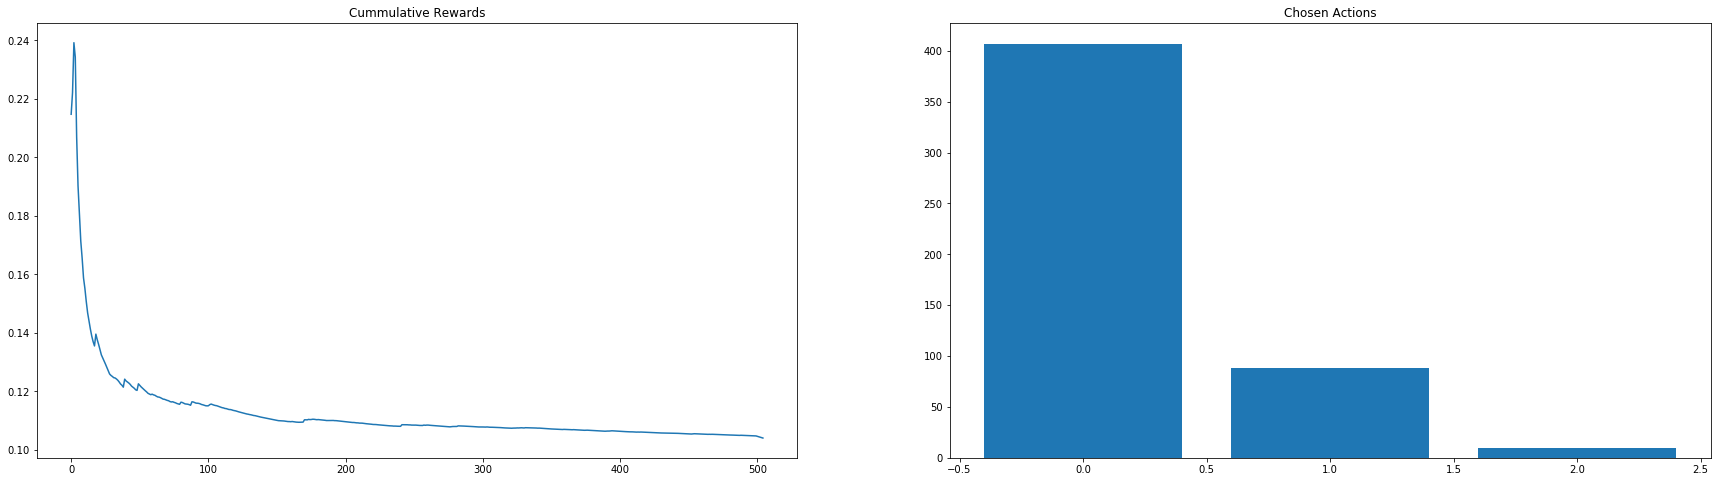

Iteration 1003
Average rewards per algo {'quick_sort': 0.03339624736842426, 'merge_sort': 0.028230254184100002, 'heap_sort': 0.06619760000000241}
Count per chosen algo {'quick_sort': 19, 'merge_sort': 478, 'heap_sort': 2}


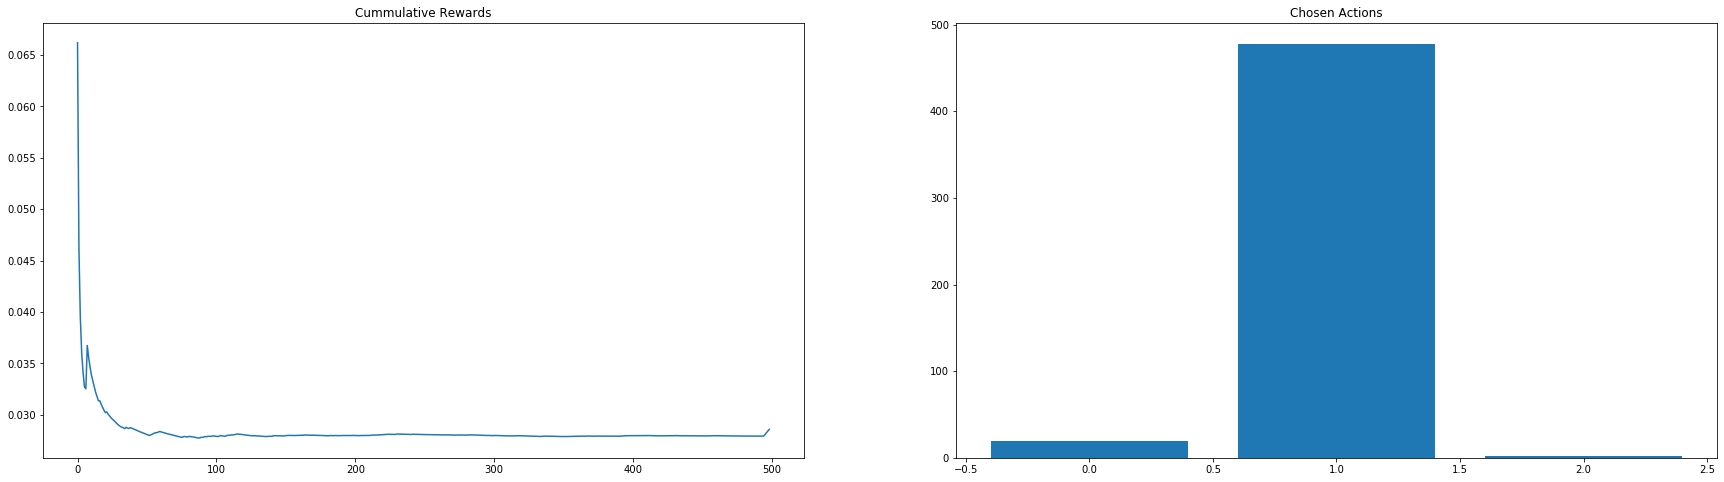

Iteration 1502
Average rewards per algo {'quick_sort': 0.09689065965665183, 'merge_sort': 0.10843259333333416, 'heap_sort': 0.21584093333333007}
Count per chosen algo {'quick_sort': 466, 'merge_sort': 30, 'heap_sort': 3}


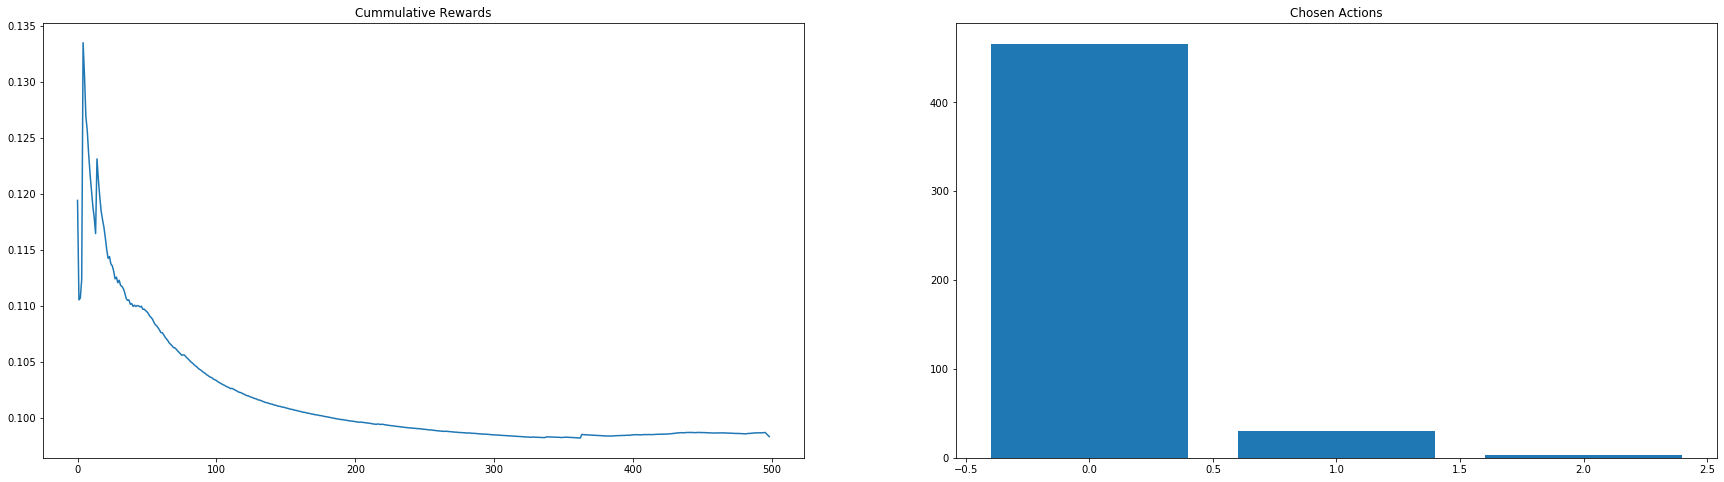

Iteration 1999
Average rewards per algo {'quick_sort': 0.03690190909091226, 'merge_sort': 0.027626329213481265, 'heap_sort': 0.07315157560975094}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 445, 'heap_sort': 41}


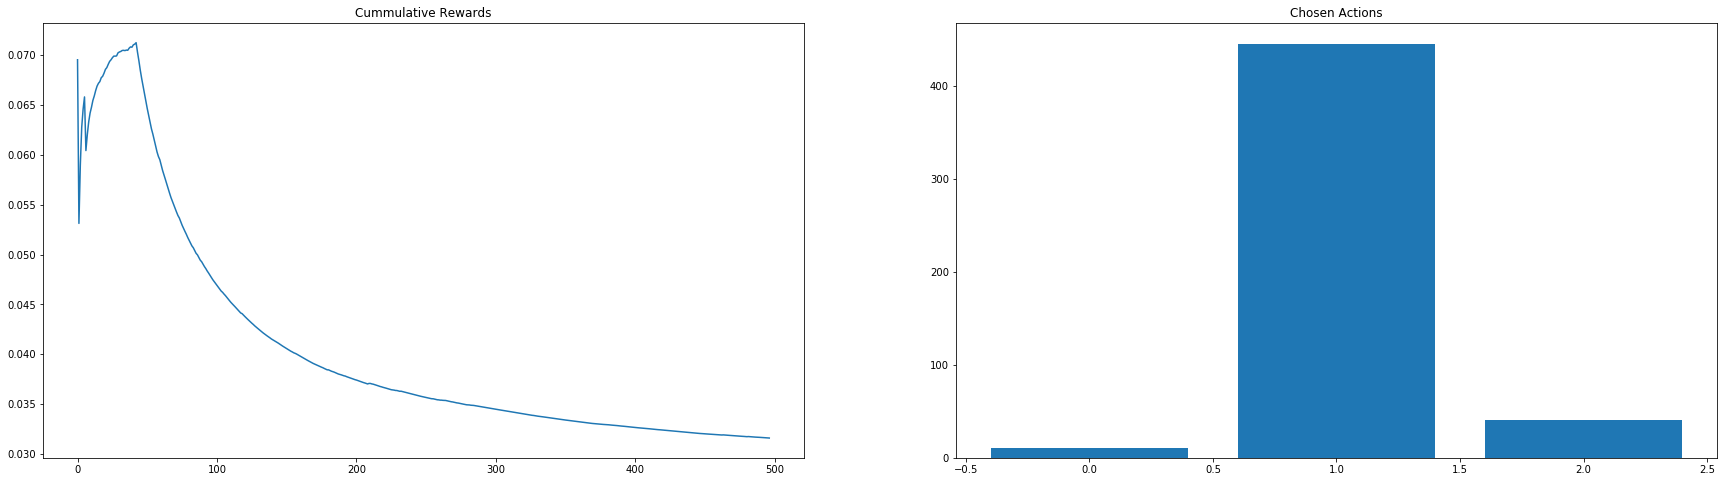

Total reward 131.5684


In [12]:
for elem in list_iteration_results_TS_ttest:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Iteration", n)
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_TS_ttest,4))

### Second Variant: Change point detection 

## Offline changepoint detection - not adjustable to out case but works properly

In [13]:
list_iteration_results_TS_stationary, total_reward_TS_stationary = TS_stationary(list_distributions=list_distributions, n_samples=n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.6925881694982287
Less than two values for merge_sort
merge_sort Theta 0.6306707203315884
Less than two values for heap_sort
heap_sort Theta 0.3293921212477817


Chosen algorithm is:  heap_sort with reward: 0.22295780000001741
Sample mean is:  0.22295780000001741 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.9385424390993243
Less than two values for merge_sort
merge_sort Theta 0.7623088641616333
Less than two values for heap_sort
heap_sort Theta 0.35679252441277354


Chosen algorithm is:  heap_sort with reward: 0.2186360000000036
Sample mean is:  0.2207969000000105 Sample variance is: 4.66948881002984e-06


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.8960732265729581
Less than two values for merge_sort
merge_sort Theta 0.6974465989806551
heap_sort Theta 0.22665786842334004


Chosen algorithm is:  heap_sort with reward: 0.215635299999974
Sample mea

merge_sort Theta 0.8919718704143856
heap_sort Theta 0.20734324544837554


Chosen algorithm is:  quick_sort with reward: 0.09684729999997899
Sample mean is:  0.09611792999999977 Sample variance is: 6.979362574072412e-06


Iteration: 28
quick_sort Theta 0.09591820356840347
Less than two values for merge_sort
merge_sort Theta 0.9857925196573754
heap_sort Theta 0.22008323431183513


Chosen algorithm is:  quick_sort with reward: 0.09765089999996235
Sample mean is:  0.09619092857142657 Sample variance is: 6.7535878039141e-06


Iteration: 29
quick_sort Theta 0.09382203353510796
Less than two values for merge_sort
merge_sort Theta 0.8208436766797131
heap_sort Theta 0.19936159006400858


Chosen algorithm is:  quick_sort with reward: 0.09334709999995994
Sample mean is:  0.0960616636363599 Sample variance is: 6.797504432293393e-06


Iteration: 30
quick_sort Theta 0.09270859194883524
Less than two values for merge_sort
merge_sort Theta 0.5799327360067191
heap_sort Theta 0.21734749129111805


Chose



Chosen algorithm is:  quick_sort with reward: 0.09604870000003984
Sample mean is:  0.09564774791666626 Sample variance is: 5.5331858749912225e-06


Iteration: 58
quick_sort Theta 0.09511050845920459
merge_sort Theta 0.10716308549834574
heap_sort Theta 0.21310229196344688


Chosen algorithm is:  quick_sort with reward: 0.09319759999999633
Sample mean is:  0.09559774489795872 Sample variance is: 5.54027820451076e-06


Iteration: 59
quick_sort Theta 0.09633823256975894
merge_sort Theta 0.1065945401858975
heap_sort Theta 0.2183303251270001


Chosen algorithm is:  quick_sort with reward: 0.0973538000000076
Sample mean is:  0.09563286599999969 Sample variance is: 5.489913739040609e-06


Iteration: 60
quick_sort Theta 0.09650348733763574
merge_sort Theta 0.10905433700034087
heap_sort Theta 0.2039861362513671


Chosen algorithm is:  quick_sort with reward: 0.09679540000001907
Sample mean is:  0.0956556607843138 Sample variance is: 5.4082484812047695e-06


Iteration: 61
quick_sort Theta 0.092



Chosen algorithm is:  quick_sort with reward: 0.0983921000000123
Sample mean is:  0.0955605320512846 Sample variance is: 4.932450129351239e-06


Iteration: 89
quick_sort Theta 0.09529641429223262
merge_sort Theta 0.10676005945932876
heap_sort Theta 0.2054761502797856


Chosen algorithm is:  quick_sort with reward: 0.09345810000002075
Sample mean is:  0.09553391898734456 Sample variance is: 4.92525795520213e-06


Iteration: 90
quick_sort Theta 0.09574191243136342
merge_sort Theta 0.10295297694488112
heap_sort Theta 0.2117228409783134


Chosen algorithm is:  quick_sort with reward: 0.09641479999999092
Sample mean is:  0.09554493000000264 Sample variance is: 4.873270380342859e-06


Iteration: 91
quick_sort Theta 0.09685974124304612
merge_sort Theta 0.10114476871884044
heap_sort Theta 0.22195093304030203


Chosen algorithm is:  quick_sort with reward: 0.0934568999999783
Sample mean is:  0.0955191518518542 Sample variance is: 4.866267582243843e-06


Iteration: 92
quick_sort Theta 0.094424

Iteration: 120
quick_sort Theta 0.09755605923704364
merge_sort Theta 0.10566656559156627
heap_sort Theta 0.2215434883715999


Chosen algorithm is:  quick_sort with reward: 0.09631230000002233
Sample mean is:  0.09549698504673164 Sample variance is: 4.520026154360441e-06


Iteration: 121
quick_sort Theta 0.09525702211767265
merge_sort Theta 0.10206712598752801
heap_sort Theta 0.21326164921146026


Chosen algorithm is:  quick_sort with reward: 0.0970702999999844
Sample mean is:  0.09551155277778028 Sample variance is: 4.5008814706444645e-06


Iteration: 122
quick_sort Theta 0.09563910079330828
merge_sort Theta 0.10496924027616283
heap_sort Theta 0.233574982126532


Chosen algorithm is:  quick_sort with reward: 0.09294900000003281
Sample mean is:  0.09548804311926884 Sample variance is: 4.519281016767165e-06


Iteration: 123
quick_sort Theta 0.09477057356905827
merge_sort Theta 0.1026453547392299
heap_sort Theta 0.21285846675845332


Chosen algorithm is:  quick_sort with reward: 0.0974183



Chosen algorithm is:  quick_sort with reward: 0.09648350000003347
Sample mean is:  0.09547397647059175 Sample variance is: 4.3598084169503026e-06


Iteration: 151
quick_sort Theta 0.09607825936327162
merge_sort Theta 0.10578575564873803
heap_sort Theta 0.22309421525461026


Chosen algorithm is:  quick_sort with reward: 0.09289830000000165
Sample mean is:  0.09545517591241225 Sample variance is: 4.376055692197486e-06


Iteration: 152
quick_sort Theta 0.09667711201609885
merge_sort Theta 0.10481092082039654
heap_sort Theta 0.22143804550776366


Chosen algorithm is:  quick_sort with reward: 0.09590140000000247
Sample mean is:  0.09545840942029334 Sample variance is: 4.345777557234039e-06


Iteration: 153
quick_sort Theta 0.0971832193591071
merge_sort Theta 0.10417432897327832
heap_sort Theta 0.21133887006157204


Chosen algorithm is:  quick_sort with reward: 0.09943160000000262
Sample mean is:  0.09548699352518333 Sample variance is: 4.427266015717335e-06


Iteration: 154
quick_sort The

quick_sort Theta 0.09465560413863942
merge_sort Theta 0.1024526484598987
heap_sort Theta 0.24024022152982036


Chosen algorithm is:  quick_sort with reward: 0.09574659999998403
Sample mean is:  0.09542372814371515 Sample variance is: 4.2145366168768924e-06


Iteration: 182
quick_sort Theta 0.09489369185352702
merge_sort Theta 0.10186231814414158
heap_sort Theta 0.22637646763101085


Chosen algorithm is:  quick_sort with reward: 0.10058429999997998
Sample mean is:  0.09545444583333577 Sample variance is: 4.3470273574855245e-06


Iteration: 183
quick_sort Theta 0.0956269881551841
merge_sort Theta 0.10238092907178821
heap_sort Theta 0.2050454073918121


Chosen algorithm is:  quick_sort with reward: 0.09349000000003116
Sample mean is:  0.09544282189349373 Sample variance is: 4.3440047863276125e-06


Iteration: 184
quick_sort Theta 0.09444239510063737
merge_sort Theta 0.10341351032021975
heap_sort Theta 0.22395711824386377


Chosen algorithm is:  quick_sort with reward: 0.09630650000002561




Chosen algorithm is:  quick_sort with reward: 0.09617839999998523
Sample mean is:  0.09555222878788187 Sample variance is: 6.003716945689683e-06


Iteration: 213
quick_sort Theta 0.09697452241058788
merge_sort Theta 0.1016799620091746
heap_sort Theta 0.2169811295064351


Chosen algorithm is:  quick_sort with reward: 0.10401510000002645
Sample mean is:  0.09559475577889767 Sample variance is: 6.331639416843698e-06


Iteration: 214
quick_sort Theta 0.09577291991750311
merge_sort Theta 0.10090111379246734
heap_sort Theta 0.223251484190123


Chosen algorithm is:  quick_sort with reward: 0.10268070000000762
Sample mean is:  0.09563018550000323 Sample variance is: 6.549778982145269e-06


Iteration: 215
quick_sort Theta 0.09630696303919012
merge_sort Theta 0.10840491148712976
heap_sort Theta 0.2127768029614442


Chosen algorithm is:  quick_sort with reward: 0.1032301999999845
Sample mean is:  0.09566799651741606 Sample variance is: 6.8031276246188215e-06


Iteration: 216
quick_sort Theta 0.



Chosen algorithm is:  quick_sort with reward: 0.09805660000000671
Sample mean is:  0.09566990611353988 Sample variance is: 6.65682002049383e-06


Iteration: 244
quick_sort Theta 0.09487635007703249
merge_sort Theta 0.10048922456170975
heap_sort Theta 0.22201590239230493


Chosen algorithm is:  quick_sort with reward: 0.09263959999998406
Sample mean is:  0.0956567308695679 Sample variance is: 6.667628760054718e-06


Iteration: 245
quick_sort Theta 0.0949775308667877
merge_sort Theta 0.10517845378966728
heap_sort Theta 0.21412169593633487


Chosen algorithm is:  quick_sort with reward: 0.09651479999996582
Sample mean is:  0.09566044545454798 Sample variance is: 6.6419381388503185e-06


Iteration: 246
quick_sort Theta 0.09654101563483022
merge_sort Theta 0.1014133061893332
heap_sort Theta 0.22681425700977018


Chosen algorithm is:  quick_sort with reward: 0.09642430000002378
Sample mean is:  0.0956637379310371 Sample variance is: 6.615813227879031e-06


Iteration: 247
quick_sort Theta 0



Chosen algorithm is:  quick_sort with reward: 0.09849600000001146
Sample mean is:  0.0956108507692337 Sample variance is: 6.240018215198431e-06


Iteration: 275
quick_sort Theta 0.0957025785949853
merge_sort Theta 0.10569822745006092
heap_sort Theta 0.21862991390804581


Chosen algorithm is:  quick_sort with reward: 0.09353650000002744
Sample mean is:  0.09560290306513712 Sample variance is: 6.232533259537136e-06


Iteration: 276
quick_sort Theta 0.09673680752823313
merge_sort Theta 0.10193793663404223
heap_sort Theta 0.2193055227907528


Chosen algorithm is:  quick_sort with reward: 0.09650030000000243
Sample mean is:  0.09560632824427782 Sample variance is: 6.211806978063495e-06


Iteration: 277
quick_sort Theta 0.095651169872515
merge_sort Theta 0.10643078725041193
heap_sort Theta 0.22004019647137046


Chosen algorithm is:  quick_sort with reward: 0.09295350000002145
Sample mean is:  0.09559624144487001 Sample variance is: 6.214844742965007e-06


Iteration: 278
quick_sort Theta 0.



Chosen algorithm is:  quick_sort with reward: 0.09692119999999704
Sample mean is:  0.09558183724138185 Sample variance is: 5.9009882435860855e-06


Iteration: 305
quick_sort Theta 0.09606017662489148
merge_sort Theta 0.10834620241944198
heap_sort Theta 0.22226183041378003


Chosen algorithm is:  quick_sort with reward: 0.09274379999999383
Sample mean is:  0.09557208453608498 Sample variance is: 5.90829335904685e-06


Iteration: 306
quick_sort Theta 0.09652274030314197
merge_sort Theta 0.1030799844368039
heap_sort Theta 0.22254713533231782


Chosen algorithm is:  quick_sort with reward: 0.09755619999998544
Sample mean is:  0.09557887945205724 Sample variance is: 5.90149520465365e-06


Iteration: 307
quick_sort Theta 0.0944024804749073
merge_sort Theta 0.10284740908284978
heap_sort Theta 0.22346251859832214


Chosen algorithm is:  quick_sort with reward: 0.09544660000000249
Sample mean is:  0.09557842798635058 Sample variance is: 5.88141309860978e-06


Iteration: 308
quick_sort Theta 0



Chosen algorithm is:  quick_sort with reward: 0.09803189999996675
Sample mean is:  0.09556285125000219 Sample variance is: 5.7072983649420675e-06


Iteration: 335
quick_sort Theta 0.09618115043741161
merge_sort Theta 0.10521596527582343
heap_sort Theta 0.21515500994488818


Chosen algorithm is:  quick_sort with reward: 0.09318740000003345
Sample mean is:  0.09555545109034497 Sample variance is: 5.707042575401658e-06


Iteration: 336
quick_sort Theta 0.0942366120082604
merge_sort Theta 0.10095728276807209
heap_sort Theta 0.223061945355242


Chosen algorithm is:  quick_sort with reward: 0.09623260000000755
Sample mean is:  0.09555755403726938 Sample variance is: 5.690738426526622e-06


Iteration: 337
quick_sort Theta 0.09563821735271393
merge_sort Theta 0.1055169136478658
heap_sort Theta 0.21074964522841164


Chosen algorithm is:  quick_sort with reward: 0.09688490000002048
Sample mean is:  0.09556166346749462 Sample variance is: 5.678557789507076e-06


Iteration: 338
quick_sort Theta 

merge_sort Theta 0.10982510241015941
heap_sort Theta 0.22303956512900686


Chosen algorithm is:  quick_sort with reward: 0.097041900000022
Sample mean is:  0.0955292709401733 Sample variance is: 5.5499855685620025e-06


Iteration: 366
quick_sort Theta 0.0958135568846443
merge_sort Theta 0.10076503783758833
heap_sort Theta 0.21642065824905884


Chosen algorithm is:  quick_sort with reward: 0.10761460000003353
Sample mean is:  0.09556360426136608 Sample variance is: 5.947969271494411e-06


Iteration: 367
quick_sort Theta 0.09531665593306436
merge_sort Theta 0.10501048694993868
heap_sort Theta 0.21713515931580515


Chosen algorithm is:  quick_sort with reward: 0.0941862000000242
Sample mean is:  0.09555970226629146 Sample variance is: 5.936478899265019e-06


Iteration: 368
quick_sort Theta 0.09690813104215755
merge_sort Theta 0.10630129464358415
heap_sort Theta 0.22090208021614427


Chosen algorithm is:  quick_sort with reward: 0.09574729999997089
Sample mean is:  0.09556023220339224 Samp



Chosen algorithm is:  quick_sort with reward: 0.0971246000000292
Sample mean is:  0.09590115144357224 Sample variance is: 1.4105817313532667e-05


Iteration: 396
quick_sort Theta 0.09718860717399305
merge_sort Theta 0.1069037140191331
heap_sort Theta 0.23034718295827317


Chosen algorithm is:  quick_sort with reward: 0.09313680000002478
Sample mean is:  0.0958939149214687 Sample variance is: 1.4088843013269807e-05


Iteration: 397
quick_sort Theta 0.09563215008933244
merge_sort Theta 0.1030167849412214
heap_sort Theta 0.22117229920449485


Chosen algorithm is:  quick_sort with reward: 0.09707020000001876
Sample mean is:  0.09589698616188268 Sample variance is: 1.405566074412745e-05


Iteration: 398
quick_sort Theta 0.09538269595461445
merge_sort Theta 0.10255704481254031
heap_sort Theta 0.21256142733139768


Chosen algorithm is:  quick_sort with reward: 0.09228290000004336
Sample mean is:  0.09588757447916955 Sample variance is: 1.405298351342125e-05


Iteration: 399
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.09668549999997822
Sample mean is:  0.09584774538835268 Sample variance is: 1.3338667378796977e-05


Iteration: 427
quick_sort Theta 0.09512264880158496
merge_sort Theta 0.10377572913491138
heap_sort Theta 0.202346290254746


Chosen algorithm is:  quick_sort with reward: 0.09370010000003504
Sample mean is:  0.09584254527845361 Sample variance is: 1.3317511314252479e-05


Iteration: 428
quick_sort Theta 0.0947904039455707
merge_sort Theta 0.10786402117320398
heap_sort Theta 0.21547330596944897


Chosen algorithm is:  quick_sort with reward: 0.09763319999996156
Sample mean is:  0.0958468705314041 Sample variance is: 1.3293069739331676e-05


Iteration: 429
quick_sort Theta 0.09448188683913736
merge_sort Theta 0.1017881603951593
heap_sort Theta 0.21609986313366078


Chosen algorithm is:  quick_sort with reward: 0.09265629999998737
Sample mean is:  0.09583918240964166 Sample variance is: 1.3285508633504871e-05


Iteration: 430
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.09836749999999483
Sample mean is:  0.09597763634311846 Sample variance is: 1.5267375501418118e-05


Iteration: 458
quick_sort Theta 0.09642588587914885
merge_sort Theta 0.10603158836790035
heap_sort Theta 0.2289596330195459


Chosen algorithm is:  quick_sort with reward: 0.09381430000001956
Sample mean is:  0.09597276396396734 Sample variance is: 1.5243506375375462e-05


Iteration: 459
quick_sort Theta 0.09520298990198749
merge_sort Theta 0.10794161084631602
heap_sort Theta 0.23405256994594079


Chosen algorithm is:  quick_sort with reward: 0.09769389999996747
Sample mean is:  0.09597663168539655 Sample variance is: 1.5215893220328976e-05


Iteration: 460
quick_sort Theta 0.09632831757500673
merge_sort Theta 0.10050099359191035
heap_sort Theta 0.22042335538305854


Chosen algorithm is:  quick_sort with reward: 0.0927279999999655
Sample mean is:  0.09596934775785074 Sample variance is: 1.5205386610036234e-05


Iteration: 461
quick_sort T



Chosen algorithm is:  quick_sort with reward: 0.09678400000001375
Sample mean is:  0.09594033594080595 Sample variance is: 1.4592222374615646e-05


Iteration: 488
quick_sort Theta 0.09556007271277608
merge_sort Theta 0.10252505023045932
heap_sort Theta 0.2173696904194719


Chosen algorithm is:  quick_sort with reward: 0.09324689999999691
Sample mean is:  0.09593465358650044 Sample variance is: 1.4576709863508709e-05


Iteration: 489
quick_sort Theta 0.09561804542222407
merge_sort Theta 0.1042074953978145
heap_sort Theta 0.22090841135128192


Chosen algorithm is:  quick_sort with reward: 0.09775510000002896
Sample mean is:  0.09593848610526577 Sample variance is: 1.4552984260110771e-05


Iteration: 490
quick_sort Theta 0.0953401894159629
merge_sort Theta 0.10734810944697858
heap_sort Theta 0.2154628810899975


Chosen algorithm is:  quick_sort with reward: 0.0936755999999832
Sample mean is:  0.0959337321428597 Sample variance is: 1.453314583908114e-05


Iteration: 491
quick_sort Theta 



Iteration: 518
quick_sort Theta 0.09449969877016125
merge_sort Theta 0.10366188068063542
heap_sort Theta 0.2276703864165514


Chosen algorithm is:  quick_sort with reward: 0.03209220000002233
Sample mean is:  0.09351769523809748 Sample variance is: 0.0001618936577097239


Iteration: 519
quick_sort Theta 0.08842633278212382
merge_sort Theta 0.10115210887919855
heap_sort Theta 0.21748610191518838


Chosen algorithm is:  quick_sort with reward: 0.03265890000000127
Sample mean is:  0.09339718277227947 Sample variance is: 0.0001688927964357476


Iteration: 520
quick_sort Theta 0.09473865113671943
merge_sort Theta 0.10519096084117276
heap_sort Theta 0.2146026157734413


Chosen algorithm is:  quick_sort with reward: 0.032239000000004125
Sample mean is:  0.09327631679842122 Sample variance is: 0.0001759363509421727


Iteration: 521
quick_sort Theta 0.09292071518540923
merge_sort Theta 0.10329345769532985
heap_sort Theta 0.22079965713968286


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 548
quick_sort Theta 0.09298583303438573
merge_sort Theta 0.10518150710021618
heap_sort Theta 0.22059833173702295


Chosen algorithm is:  quick_sort with reward: 0.03240880000004154
Sample mean is:  0.09006712696629471 Sample variance is: 0.00035288690651967027


Iteration: 549
quick_sort Theta 0.08633659060208855
merge_sort Theta 0.10188669436955765
heap_sort Theta 0.22922071297581753


Chosen algorithm is:  quick_sort with reward: 0.03264709999996285
Sample mean is:  0.0899597998130866 Sample variance is: 0.0003583785137388538


Iteration: 550
quick_sort Theta 0.09278074840289842
merge_sort Theta 0.10375721123686288
heap_sort Theta 0.2304579142944445


Chosen algorithm is:  quick_sort with reward: 0.03195650000003525
Sample mean is:  0.0898515847014951 Sample variance is: 0.0003639750201603126


Iteration: 551
quick_sort Theta 0.09234252935140652
merge_sort Theta 0.10127007814024379
heap_sort Theta 0.2141061537150807


Chosen algorithm is:  quick_sort with reward: 0.0317



Iteration: 578
quick_sort Theta 0.08995609962333127
merge_sort Theta 0.10127020675958784
heap_sort Theta 0.21986825553563083


Chosen algorithm is:  quick_sort with reward: 0.03148049999998648
Sample mean is:  0.08698200106383261 Sample variance is: 0.0005035680543672969


Iteration: 579
quick_sort Theta 0.09013245191062112
merge_sort Theta 0.10187742628237792
heap_sort Theta 0.2284433632002986


Chosen algorithm is:  quick_sort with reward: 0.03148219999997082
Sample mean is:  0.0868837713274364 Sample variance is: 0.0005081188652220446


Iteration: 580
quick_sort Theta 0.08485837624153468
merge_sort Theta 0.106070457444622
heap_sort Theta 0.21029801967967826


Chosen algorithm is:  quick_sort with reward: 0.03138139999998657
Sample mean is:  0.08678571060070946 Sample variance is: 0.0005126541156723638


Iteration: 581
quick_sort Theta 0.07967789580328848
merge_sort Theta 0.10563653272112196
heap_sort Theta 0.23269127264864953


Chosen algorithm is:  quick_sort with reward: 0.03232



Iteration: 608
quick_sort Theta 0.08175658994768725
merge_sort Theta 0.10462901317983599
heap_sort Theta 0.22201823465372836


Chosen algorithm is:  quick_sort with reward: 0.03158050000001822
Sample mean is:  0.08420185336700609 Sample variance is: 0.000623461069806399


Iteration: 609
quick_sort Theta 0.08741453356558747
merge_sort Theta 0.10396884627941706
heap_sort Theta 0.22315359827820658


Chosen algorithm is:  quick_sort with reward: 0.03230410000003303
Sample mean is:  0.0841146302521036 Sample variance is: 0.0006269323119089665


Iteration: 610
quick_sort Theta 0.08204935029596164
merge_sort Theta 0.10700288552911534
heap_sort Theta 0.22638669907326442


Chosen algorithm is:  quick_sort with reward: 0.03285619999996925
Sample mean is:  0.08402862617449935 Sample variance is: 0.0006302814493686824


Iteration: 611
quick_sort Theta 0.08987867761283302
merge_sort Theta 0.10527293118852107
heap_sort Theta 0.2208701787005788


Chosen algorithm is:  quick_sort with reward: 0.0314



Iteration: 638
quick_sort Theta 0.07412216146754519
merge_sort Theta 0.10377996568843323
heap_sort Theta 0.232352284019109


Chosen algorithm is:  quick_sort with reward: 0.033699600000034025
Sample mean is:  0.08171119775641308 Sample variance is: 0.0007163525394624235


Iteration: 639
quick_sort Theta 0.078841888690116
merge_sort Theta 0.10197397874769466
heap_sort Theta 0.1950422982043486


Chosen algorithm is:  quick_sort with reward: 0.0318257999999787
Sample mean is:  0.08163138112000279 Sample variance is: 0.0007191816893587441


Iteration: 640
quick_sort Theta 0.08681084397289388
merge_sort Theta 0.105591442542386
heap_sort Theta 0.22965574747816597


Chosen algorithm is:  quick_sort with reward: 0.032351199999993696
Sample mean is:  0.08155265878594527 Sample variance is: 0.0007219060904944973


Iteration: 641
quick_sort Theta 0.0795997663238899
merge_sort Theta 0.1051052301478881
heap_sort Theta 0.21558814972943532


Chosen algorithm is:  quick_sort with reward: 0.031902600



Iteration: 668
quick_sort Theta 0.0842975869039274
merge_sort Theta 0.10609068062774481
heap_sort Theta 0.2190468808444132


Chosen algorithm is:  quick_sort with reward: 0.03348060000001851
Sample mean is:  0.07944319113150108 Sample variance is: 0.0007905181265004235


Iteration: 669
quick_sort Theta 0.07986797144118205
merge_sort Theta 0.10646792424283194
heap_sort Theta 0.21797773853774335


Chosen algorithm is:  quick_sort with reward: 0.032158199999969383
Sample mean is:  0.07937100030534608 Sample variance is: 0.0007927195596565062


Iteration: 670
quick_sort Theta 0.07997065424316238
merge_sort Theta 0.10802699394613419
heap_sort Theta 0.22347129910199032


Chosen algorithm is:  quick_sort with reward: 0.031380099999978484
Sample mean is:  0.07929784344512449 Sample variance is: 0.0007950166573529661


Iteration: 671
quick_sort Theta 0.08240017500973325
merge_sort Theta 0.10283515074005813
heap_sort Theta 0.21601930651884624


Chosen algorithm is:  quick_sort with reward: 0.0



Iteration: 698
quick_sort Theta 0.06866843168929665
merge_sort Theta 0.10541437177660018
heap_sort Theta 0.2204162750238911


Chosen algorithm is:  quick_sort with reward: 0.0313019999999824
Sample mean is:  0.0774361339181311 Sample variance is: 0.0008441464972034959


Iteration: 699
quick_sort Theta 0.07019244849629604
merge_sort Theta 0.10314147781251143
heap_sort Theta 0.22668974955096352


Chosen algorithm is:  quick_sort with reward: 0.03256440000001248
Sample mean is:  0.07737062773722875 Sample variance is: 0.0008458492514103504


Iteration: 700
quick_sort Theta 0.0664111234903795
merge_sort Theta 0.10077605613452777
heap_sort Theta 0.22069000677438028


Chosen algorithm is:  quick_sort with reward: 0.031916000000023814
Sample mean is:  0.07730436734694128 Sample variance is: 0.0008476236859437956


Iteration: 701
quick_sort Theta 0.0824455918093569
merge_sort Theta 0.10601880418711795
heap_sort Theta 0.2129342895399759


Chosen algorithm is:  quick_sort with reward: 0.032705



Iteration: 728
quick_sort Theta 0.06521621981591516
merge_sort Theta 0.10438182486457276
heap_sort Theta 0.22042853146000985


Chosen algorithm is:  quick_sort with reward: 0.03189080000004196
Sample mean is:  0.07552545868347581 Sample variance is: 0.0008919265781319775


Iteration: 729
quick_sort Theta 0.0794475429828772
merge_sort Theta 0.10495784848197476
heap_sort Theta 0.22787192481924956


Chosen algorithm is:  quick_sort with reward: 0.031387400000028265
Sample mean is:  0.07546372713286958 Sample variance is: 0.0008934000283912894


Iteration: 730
quick_sort Theta 0.08347066811344647
merge_sort Theta 0.10446488678522202
heap_sort Theta 0.2278027151767575


Chosen algorithm is:  quick_sort with reward: 0.03256489999995438
Sample mean is:  0.07540381256983479 Sample variance is: 0.0008947189377160188


Iteration: 731
quick_sort Theta 0.07479158768141173
merge_sort Theta 0.10637850238856661
heap_sort Theta 0.19391021165348013


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 758
quick_sort Theta 0.0808711991967815
merge_sort Theta 0.10471851984010515
heap_sort Theta 0.21708103809619628


Chosen algorithm is:  quick_sort with reward: 0.035411500000009255
Sample mean is:  0.0737810276881742 Sample variance is: 0.0009284336969315682


Iteration: 759
quick_sort Theta 0.0776640477213754
merge_sort Theta 0.1037846412253359
heap_sort Theta 0.21081047919899598


Chosen algorithm is:  quick_sort with reward: 0.03272449999997207
Sample mean is:  0.07372591825503567 Sample variance is: 0.0009294470421220554


Iteration: 760
quick_sort Theta 0.059595200098516966
merge_sort Theta 0.10315801961619851
heap_sort Theta 0.22355283750106694


Chosen algorithm is:  quick_sort with reward: 0.03331439999999475
Sample mean is:  0.07367174731903696 Sample variance is: 0.0009303873298375868


Iteration: 761
quick_sort Theta 0.07628602459288474
merge_sort Theta 0.0981579504424263
heap_sort Theta 0.21225291140416566


Chosen algorithm is:  quick_sort with reward: 0.0323



Iteration: 788
quick_sort Theta 0.07601366387468868
merge_sort Theta 0.10083121650418475
heap_sort Theta 0.22537323722729435


Chosen algorithm is:  quick_sort with reward: 0.03134549999998626
Sample mean is:  0.07217047235142332 Sample variance is: 0.0009567995028330056


Iteration: 789
quick_sort Theta 0.07085795527414523
merge_sort Theta 0.10246613072303035
heap_sort Theta 0.21479350728816946


Chosen algorithm is:  quick_sort with reward: 0.03232109999999011
Sample mean is:  0.07211905380645373 Sample variance is: 0.0009576112757068454


Iteration: 790
quick_sort Theta 0.0746628440944722
merge_sort Theta 0.10384295449491857
heap_sort Theta 0.21475816629318686


Chosen algorithm is:  quick_sort with reward: 0.031678999999996904
Sample mean is:  0.07206694033505366 Sample variance is: 0.0009584819963312976


Iteration: 791
quick_sort Theta 0.06805435369917541
merge_sort Theta 0.10278810274037471
heap_sort Theta 0.22619427348118978


Chosen algorithm is:  quick_sort with reward: 0.0



Iteration: 818
quick_sort Theta 0.06790989393908378
merge_sort Theta 0.10210554281126066
heap_sort Theta 0.2126870698667443


Chosen algorithm is:  quick_sort with reward: 0.03149679999995669
Sample mean is:  0.07067078196517586 Sample variance is: 0.0009791380852995674


Iteration: 819
quick_sort Theta 0.06961966144280145
merge_sort Theta 0.10350176721917405
heap_sort Theta 0.24056027254193846


Chosen algorithm is:  quick_sort with reward: 0.031965299999967556
Sample mean is:  0.0706227006211197 Sample variance is: 0.0009797804644762931


Iteration: 820
quick_sort Theta 0.07062053373537486
merge_sort Theta 0.10284270015147626
heap_sort Theta 0.21725802629493945


Chosen algorithm is:  quick_sort with reward: 0.031369100000006256
Sample mean is:  0.07057399888337637 Sample variance is: 0.0009804742026632443


Iteration: 821
quick_sort Theta 0.0783613094882603
merge_sort Theta 0.10345621024896802
heap_sort Theta 0.23004134992119957


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 848
quick_sort Theta 0.07179223691834027
merge_sort Theta 0.11057274000677378
heap_sort Theta 0.21868152003481245


Chosen algorithm is:  quick_sort with reward: 0.034236799999973755
Sample mean is:  0.0692884677458051 Sample variance is: 0.000995154315893339


Iteration: 849
quick_sort Theta 0.0698631102619341
merge_sort Theta 0.10495135708233802
heap_sort Theta 0.23175927032007188


Chosen algorithm is:  quick_sort with reward: 0.03199419999998554
Sample mean is:  0.06924380395209753 Sample variance is: 0.0009956262229440247


Iteration: 850
quick_sort Theta 0.06463254372745098
merge_sort Theta 0.10541341075751108
heap_sort Theta 0.21803907764104433


Chosen algorithm is:  quick_sort with reward: 0.03150649999997768
Sample mean is:  0.06919866363636533 Sample variance is: 0.000996136718653134


Iteration: 851
quick_sort Theta 0.06485063671781953
merge_sort Theta 0.10292818776977442
heap_sort Theta 0.20727481068713652


Chosen algorithm is:  quick_sort with reward: 0.0315



Iteration: 878
quick_sort Theta 0.07111422738255749
merge_sort Theta 0.1003558431525008
heap_sort Theta 0.22237973428208385


Chosen algorithm is:  quick_sort with reward: 0.03212910000002012
Sample mean is:  0.06800209861111292 Sample variance is: 0.0010066254768249729


Iteration: 879
quick_sort Theta 0.07954598283118032
merge_sort Theta 0.10198942342501069
heap_sort Theta 0.2271848892903217


Chosen algorithm is:  quick_sort with reward: 0.032459999999957745
Sample mean is:  0.06796100947977055 Sample variance is: 0.0010069204535913337


Iteration: 880
quick_sort Theta 0.07001297295255485
merge_sort Theta 0.10352651640183194
heap_sort Theta 0.2257576740048243


Chosen algorithm is:  quick_sort with reward: 0.03874490000004016
Sample mean is:  0.06792727263279626 Sample variance is: 0.0010067422491342039


Iteration: 881
quick_sort Theta 0.06693958364044954
merge_sort Theta 0.10666012483770484
heap_sort Theta 0.19890968363044026


Chosen algorithm is:  quick_sort with reward: 0.031



Iteration: 908
quick_sort Theta 0.07101748657958301
merge_sort Theta 0.1053118332869832
heap_sort Theta 0.20629980065198356


Chosen algorithm is:  quick_sort with reward: 0.03202479999998786
Sample mean is:  0.06680628008948707 Sample variance is: 0.0010140943703535084


Iteration: 909
quick_sort Theta 0.0643790106789521
merge_sort Theta 0.1050114791038166
heap_sort Theta 0.20164469729891346


Chosen algorithm is:  quick_sort with reward: 0.03183200000000852
Sample mean is:  0.06676720268156586 Sample variance is: 0.001014326481183915


Iteration: 910
quick_sort Theta 0.061147826166952426
merge_sort Theta 0.10058682610603134
heap_sort Theta 0.2098329185229484


Chosen algorithm is:  quick_sort with reward: 0.031529599999998936
Sample mean is:  0.06672787500000162 Sample variance is: 0.0010145786869298332


Iteration: 911
quick_sort Theta 0.06629022109723792
merge_sort Theta 0.10763849599835977
heap_sort Theta 0.2275410335109937


Chosen algorithm is:  quick_sort with reward: 0.03252



Iteration: 938
quick_sort Theta 0.0704833325709362
merge_sort Theta 0.10434359028606144
heap_sort Theta 0.21253456995298944


Chosen algorithm is:  quick_sort with reward: 0.03238269999997101
Sample mean is:  0.06567189534632191 Sample variance is: 0.0010195260641535967


Iteration: 939
quick_sort Theta 0.06773531117494973
merge_sort Theta 0.10546915026066349
heap_sort Theta 0.21559833631737427


Chosen algorithm is:  quick_sort with reward: 0.03162850000001072
Sample mean is:  0.06563509167567724 Sample variance is: 0.0010196754412137498


Iteration: 940
quick_sort Theta 0.06676844937450187
merge_sort Theta 0.10494213012724911
heap_sort Theta 0.21225792086967807


Chosen algorithm is:  quick_sort with reward: 0.03342520000001059
Sample mean is:  0.06560030777537955 Sample variance is: 0.0010196934555710758


Iteration: 941
quick_sort Theta 0.06801403815166858
merge_sort Theta 0.10198512928060269
heap_sort Theta 0.21826381932990652


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 968
quick_sort Theta 0.06514548504222088
merge_sort Theta 0.10421068771397757
heap_sort Theta 0.2254592472032671


Chosen algorithm is:  quick_sort with reward: 0.034172000000012304
Sample mean is:  0.06462147159329318 Sample variance is: 0.001021474827294319


Iteration: 969
quick_sort Theta 0.06579069941236433
merge_sort Theta 0.10192783494518544
heap_sort Theta 0.19929566232511942


Chosen algorithm is:  quick_sort with reward: 0.031668500000023414
Sample mean is:  0.06458696586387615 Sample variance is: 0.0010215410958212417


Iteration: 970
quick_sort Theta 0.06663232286276932
merge_sort Theta 0.10102998553093191
heap_sort Theta 0.21712542532434637


Chosen algorithm is:  quick_sort with reward: 0.032526599999982864
Sample mean is:  0.06455342991631977 Sample variance is: 0.0010215465882781008


Iteration: 971
quick_sort Theta 0.06514070156738908
merge_sort Theta 0.10630180877727276
heap_sort Theta 0.2116732443185218


Chosen algorithm is:  quick_sort with reward: 0.0



Iteration: 998
quick_sort Theta 0.06560689485482267
merge_sort Theta 0.10114060619877552
heap_sort Theta 0.21519923534976246


Chosen algorithm is:  quick_sort with reward: 0.03167959999996128
Sample mean is:  0.06362977693089597 Sample variance is: 0.0010216188018461723


Iteration: 999
quick_sort Theta 0.06112011371575586
merge_sort Theta 0.10032731058793318
heap_sort Theta 0.21067164694205157


Chosen algorithm is:  quick_sort with reward: 0.03176759999996648
Sample mean is:  0.06359742954314883 Sample variance is: 0.001021611237235756


Iteration: 1000
quick_sort Theta 0.06479662373338614
merge_sort Theta 0.10332157123735741
heap_sort Theta 0.22004700650925668


Chosen algorithm is:  quick_sort with reward: 0.09542570000002115
Sample mean is:  0.06362970973630996 Sample variance is: 0.0010216015010697539


Iteration: 1001
quick_sort Theta 0.06963812474745897
merge_sort Theta 0.10323155768594833
heap_sort Theta 0.22302784470750556


Chosen algorithm is:  quick_sort with reward: 0.



Chosen algorithm is:  quick_sort with reward: 0.09724190000002864
Sample mean is:  0.06450840838264463 Sample variance is: 0.0010206682004621174


Iteration: 1029
quick_sort Theta 0.0634067366476055
merge_sort Theta 0.10251266634661971
heap_sort Theta 0.21740203464877975


Chosen algorithm is:  quick_sort with reward: 0.09311379999996916
Sample mean is:  0.06453659103448435 Sample variance is: 0.0010204679975589902


Iteration: 1030
quick_sort Theta 0.07068613232786339
merge_sort Theta 0.10482289626363081
heap_sort Theta 0.22558447894806574


Chosen algorithm is:  quick_sort with reward: 0.09630590000000439
Sample mean is:  0.06456786003937168 Sample variance is: 0.0010204560168502405


Iteration: 1031
quick_sort Theta 0.06320264167894127
merge_sort Theta 0.10505705224540045
heap_sort Theta 0.22837579293958613


Chosen algorithm is:  quick_sort with reward: 0.09637409999999136
Sample mean is:  0.06459913461160434 Sample variance is: 0.001020446367053813


Iteration: 1032
quick_sort T



Chosen algorithm is:  quick_sort with reward: 0.0957988000000114
Sample mean is:  0.06540030143678313 Sample variance is: 0.0010183243610978054


Iteration: 1059
quick_sort Theta 0.07387966342734796
merge_sort Theta 0.10872691071875797
heap_sort Theta 0.20862920577386154


Chosen algorithm is:  quick_sort with reward: 0.09312230000000454
Sample mean is:  0.0654268296650733 Sample variance is: 0.0010180845997846332


Iteration: 1060
quick_sort Theta 0.06478116131900348
merge_sort Theta 0.09866846313528504
heap_sort Theta 0.2122942743087384


Chosen algorithm is:  quick_sort with reward: 0.09535369999997556
Sample mean is:  0.06545544043977206 Sample variance is: 0.0010179666999159075


Iteration: 1061
quick_sort Theta 0.06194130362943233
merge_sort Theta 0.10793921511511674
heap_sort Theta 0.2007591155912996


Chosen algorithm is:  quick_sort with reward: 0.09640869999998358
Sample mean is:  0.06548500420248476 Sample variance is: 0.001017908650711194


Iteration: 1062
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.09809649999999692
Sample mean is:  0.06623891378026198 Sample variance is: 0.0010144268421486422


Iteration: 1089
quick_sort Theta 0.06483536411493795
merge_sort Theta 0.10380305909217663
heap_sort Theta 0.2240712577836635


Chosen algorithm is:  quick_sort with reward: 0.09346070000003692
Sample mean is:  0.06626423637209433 Sample variance is: 0.0010141718742199585


Iteration: 1090
quick_sort Theta 0.06100949665619365
merge_sort Theta 0.10351936908059113
heap_sort Theta 0.20047314056071786


Chosen algorithm is:  quick_sort with reward: 0.095240600000011
Sample mean is:  0.06629116607806823 Sample variance is: 0.0010140089350470262


Iteration: 1091
quick_sort Theta 0.06782152818132552
merge_sort Theta 0.10213227857462834
heap_sort Theta 0.2097654724980699


Chosen algorithm is:  quick_sort with reward: 0.09600799999998344
Sample mean is:  0.066318758310122 Sample variance is: 0.0010138866150187235


Iteration: 1092
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.11585420000000113
Sample mean is:  0.0670857211956534 Sample variance is: 0.0010137647952664726


Iteration: 1119
quick_sort Theta 0.06683436623762422
merge_sort Theta 0.10412868536608971
heap_sort Theta 0.21634254776140643


Chosen algorithm is:  quick_sort with reward: 0.09591640000002144
Sample mean is:  0.06711181230769354 Sample variance is: 0.0010135989047873625


Iteration: 1120
quick_sort Theta 0.07385568593871907
merge_sort Theta 0.10683892845976008
heap_sort Theta 0.21500183223306243


Chosen algorithm is:  quick_sort with reward: 0.09717030000001614
Sample mean is:  0.06713898996383488 Sample variance is: 0.0010134986306990438


Iteration: 1121
quick_sort Theta 0.0657954517151456
merge_sort Theta 0.10311418688820008
heap_sort Theta 0.22671664518865267


Chosen algorithm is:  quick_sort with reward: 0.09793969999998353
Sample mean is:  0.06716681355013673 Sample variance is: 0.0010134393065091775


Iteration: 1122
quick_sort T



Chosen algorithm is:  quick_sort with reward: 0.10115299999995386
Sample mean is:  0.06786717716049488 Sample variance is: 0.001009724509701965


Iteration: 1149
quick_sort Theta 0.07018343393655278
merge_sort Theta 0.0975413753134286
heap_sort Theta 0.21628579238837867


Chosen algorithm is:  quick_sort with reward: 0.0942522000000281
Sample mean is:  0.06789042387665306 Sample variance is: 0.0010094477093102504


Iteration: 1150
quick_sort Theta 0.06967009644278838
merge_sort Theta 0.10292284794643064
heap_sort Theta 0.2183987922717687


Chosen algorithm is:  quick_sort with reward: 0.09546039999997902
Sample mean is:  0.06791469322183204 Sample variance is: 0.0010092276272405877


Iteration: 1151
quick_sort Theta 0.06416106126046241
merge_sort Theta 0.10301355050305779
heap_sort Theta 0.22268550403051196


Chosen algorithm is:  quick_sort with reward: 0.09632830000003878
Sample mean is:  0.06793968320140831 Sample variance is: 0.001009049434951628


Iteration: 1152
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.0971418999999969
Sample mean is:  0.06857986082474338 Sample variance is: 0.0010029636662594562


Iteration: 1179
quick_sort Theta 0.07144126034534651
merge_sort Theta 0.10177402040061653
heap_sort Theta 0.1943718282905731


Chosen algorithm is:  quick_sort with reward: 0.092894699999988
Sample mean is:  0.06860073193133158 Sample variance is: 0.0010026097952382188


Iteration: 1180
quick_sort Theta 0.06495799978086142
merge_sort Theta 0.10366293377795747
heap_sort Theta 0.213287267041632


Chosen algorithm is:  quick_sort with reward: 0.0954021999999668
Sample mean is:  0.06862371775300279 Sample variance is: 0.0010023654494763236


Iteration: 1181
quick_sort Theta 0.06094794986393293
merge_sort Theta 0.10287621845817926
heap_sort Theta 0.21015541398778667


Chosen algorithm is:  quick_sort with reward: 0.09640600000000177
Sample mean is:  0.0686475243359051 Sample variance is: 0.001002167358950334


Iteration: 1182
quick_sort Theta 0.

merge_sort Theta 0.10155538605237611
heap_sort Theta 0.22202553111110174


Chosen algorithm is:  quick_sort with reward: 0.09596350000003895
Sample mean is:  0.06927546769874587 Sample variance is: 0.0009951984755042233


Iteration: 1210
quick_sort Theta 0.0790638206978628
merge_sort Theta 0.10829498486196706
heap_sort Theta 0.21868065727898892


Chosen algorithm is:  quick_sort with reward: 0.09590560000003734
Sample mean is:  0.06929773369565331 Sample variance is: 0.0009949588204243207


Iteration: 1211
quick_sort Theta 0.07286892110339652
merge_sort Theta 0.10478896853220188
heap_sort Theta 0.22235330522450647


Chosen algorithm is:  quick_sort with reward: 0.09295499999996082
Sample mean is:  0.06931749749373545 Sample variance is: 0.0009945947768747253


Iteration: 1212
quick_sort Theta 0.06795237859753825
merge_sort Theta 0.1033916262141985
heap_sort Theta 0.22763064291818164


Chosen algorithm is:  quick_sort with reward: 0.09598160000001599
Sample mean is:  0.06933975467445855



Chosen algorithm is:  quick_sort with reward: 0.09700679999997419
Sample mean is:  0.06991706073469506 Sample variance is: 0.0009873051557728319


Iteration: 1240
quick_sort Theta 0.0681294992264523
merge_sort Theta 0.10615703439913751
heap_sort Theta 0.22379318739140341


Chosen algorithm is:  quick_sort with reward: 0.09440009999997301
Sample mean is:  0.06993703058727685 Sample variance is: 0.000986988373662887


Iteration: 1241
quick_sort Theta 0.077798031011769
merge_sort Theta 0.10211755177456865
heap_sort Theta 0.21363164400669746


Chosen algorithm is:  quick_sort with reward: 0.09556630000002997
Sample mean is:  0.06995791833740948 Sample variance is: 0.0009867188836377792


Iteration: 1242
quick_sort Theta 0.06890122000336604
merge_sort Theta 0.1014257980846584
heap_sort Theta 0.21684057338363008


Chosen algorithm is:  quick_sort with reward: 0.09636419999998225
Sample mean is:  0.0699794218241054 Sample variance is: 0.0009864827313580391


Iteration: 1243
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.09596209999995153
Sample mean is:  0.07054565007961884 Sample variance is: 0.0009786180950455158


Iteration: 1271
quick_sort Theta 0.07313483667463427
merge_sort Theta 0.1058844773898237
heap_sort Theta 0.2161555593117137


Chosen algorithm is:  quick_sort with reward: 0.09378840000005084
Sample mean is:  0.07056414073190241 Sample variance is: 0.000978268992066368


Iteration: 1272
quick_sort Theta 0.0650227914604295
merge_sort Theta 0.10505085131490702
heap_sort Theta 0.211751005594725


Chosen algorithm is:  quick_sort with reward: 0.09794340000001966
Sample mean is:  0.07058590484896768 Sample variance is: 0.0009780867654849694


Iteration: 1273
quick_sort Theta 0.07550159900832443
merge_sort Theta 0.10595193614811821
heap_sort Theta 0.21153173061850286


Chosen algorithm is:  quick_sort with reward: 0.09626919999999473
Sample mean is:  0.07060630460683189 Sample variance is: 0.0009778334064312185


Iteration: 1274
quick_sort Theta



Iteration: 1301
quick_sort Theta 0.07433631297286643
merge_sort Theta 0.10508375300379809
heap_sort Theta 0.22005584398348255


Chosen algorithm is:  quick_sort with reward: 0.09429929999998876
Sample mean is:  0.07114259914530026 Sample variance is: 0.0009695537112249282


Iteration: 1302
quick_sort Theta 0.06751972776769885
merge_sort Theta 0.10614758894189222
heap_sort Theta 0.22428300669454068


Chosen algorithm is:  quick_sort with reward: 0.09602970000003097
Sample mean is:  0.07116192142857256 Sample variance is: 0.000969281454394273


Iteration: 1303
quick_sort Theta 0.0702229958902974
merge_sort Theta 0.10461846194652887
heap_sort Theta 0.21246784438952915


Chosen algorithm is:  quick_sort with reward: 0.09384140000003072
Sample mean is:  0.07117951605896158 Sample variance is: 0.0009689282179759922


Iteration: 1304
quick_sort Theta 0.07297421356495906
merge_sort Theta 0.10179104904515383
heap_sort Theta 0.2178711542116418


Chosen algorithm is:  quick_sort with reward: 0.



Iteration: 1331
quick_sort Theta 0.07477413570013981
merge_sort Theta 0.10069131980258307
heap_sort Theta 0.22819343011734305


Chosen algorithm is:  quick_sort with reward: 0.09535970000001726
Sample mean is:  0.07169370607441253 Sample variance is: 0.0009605480052823813


Iteration: 1332
quick_sort Theta 0.06882018889496017
merge_sort Theta 0.10370647430852933
heap_sort Theta 0.21062153658247662


Chosen algorithm is:  quick_sort with reward: 0.09775179999996908
Sample mean is:  0.07171347701062311 Sample variance is: 0.0009603340151919703


Iteration: 1333
quick_sort Theta 0.07289418742585899
merge_sort Theta 0.10505519326721706
heap_sort Theta 0.22006681746076537


Chosen algorithm is:  quick_sort with reward: 0.09282210000003488
Sample mean is:  0.07172948051554306 Sample variance is: 0.0009599434936888356


Iteration: 1334
quick_sort Theta 0.07216095699989693
merge_sort Theta 0.1045718372656377
heap_sort Theta 0.23042672736930328


Chosen algorithm is:  quick_sort with reward: 



Chosen algorithm is:  quick_sort with reward: 0.09750980000001164
Sample mean is:  0.07222947795100293 Sample variance is: 0.0009519208472570011


Iteration: 1362
quick_sort Theta 0.07371894821840422
merge_sort Theta 0.10537177425358282
heap_sort Theta 0.22008151038044088


Chosen algorithm is:  quick_sort with reward: 0.09318030000008548
Sample mean is:  0.07224502010385833 Sample variance is: 0.000951540053841865


Iteration: 1363
quick_sort Theta 0.07373206866757015
merge_sort Theta 0.09946783206902127
heap_sort Theta 0.21470988839196167


Chosen algorithm is:  quick_sort with reward: 0.09579429999996592
Sample mean is:  0.07226247694588658 Sample variance is: 0.0009512454781811715


Iteration: 1364
quick_sort Theta 0.0679094030114906
merge_sort Theta 0.10023206209980681
heap_sort Theta 0.19265937055727245


Chosen algorithm is:  quick_sort with reward: 0.09669880000001285
Sample mean is:  0.07228057792592667 Sample variance is: 0.0009509828456514148


Iteration: 1365
quick_sort T

merge_sort Theta 0.10801092961432023
heap_sort Theta 0.20937953746520377


Chosen algorithm is:  quick_sort with reward: 0.09814519999997628
Sample mean is:  0.07275064550072642 Sample variance is: 0.0009423908198800307


Iteration: 1393
quick_sort Theta 0.07194271853194292
merge_sort Theta 0.10238313734006196
heap_sort Theta 0.2277465094939243


Chosen algorithm is:  quick_sort with reward: 0.09699030000001585
Sample mean is:  0.07276822320522192 Sample variance is: 0.0009421332012816851


Iteration: 1394
quick_sort Theta 0.08005393141467791
merge_sort Theta 0.10345139400537456
heap_sort Theta 0.21066710869526137


Chosen algorithm is:  quick_sort with reward: 0.09502039999995304
Sample mean is:  0.0727843479710152 Sample variance is: 0.0009418090471944989


Iteration: 1395
quick_sort Theta 0.07171866351594824
merge_sort Theta 0.10393203779997665
heap_sort Theta 0.20217474949099748


Chosen algorithm is:  quick_sort with reward: 0.09601480000003448
Sample mean is:  0.07280116944243376



Chosen algorithm is:  quick_sort with reward: 0.09747500000003129
Sample mean is:  0.07323704751420519 Sample variance is: 0.0009332332921022664


Iteration: 1423
quick_sort Theta 0.07760893635064625
merge_sort Theta 0.10386985931988289
heap_sort Theta 0.22504753927859356


Chosen algorithm is:  quick_sort with reward: 0.09321719999991274
Sample mean is:  0.07325122789212266 Sample variance is: 0.0009328540798064091


Iteration: 1424
quick_sort Theta 0.06956081564509278
merge_sort Theta 0.09779502608087637
heap_sort Theta 0.21609183241773505


Chosen algorithm is:  quick_sort with reward: 0.09596369999997023
Sample mean is:  0.07326733602836936 Sample variance is: 0.0009325580772914075


Iteration: 1425
quick_sort Theta 0.07163789339025743
merge_sort Theta 0.10620339313679603
heap_sort Theta 0.22059567410703962


Chosen algorithm is:  quick_sort with reward: 0.09593409999990854
Sample mean is:  0.07328340035435911 Sample variance is: 0.0009322610255446778


Iteration: 1426
quick_sort



Chosen algorithm is:  quick_sort with reward: 0.09770530000002964
Sample mean is:  0.07370118636995883 Sample variance is: 0.0009239219259259019


Iteration: 1453
quick_sort Theta 0.07197196338212704
merge_sort Theta 0.1002705723911118
heap_sort Theta 0.2245788588689757


Chosen algorithm is:  quick_sort with reward: 0.09359840000001896
Sample mean is:  0.07371501348158499 Sample variance is: 0.0009235547974084041


Iteration: 1454
quick_sort Theta 0.07773972754466793
merge_sort Theta 0.10563947916117249
heap_sort Theta 0.21690902491646816


Chosen algorithm is:  quick_sort with reward: 0.09740969999995741
Sample mean is:  0.07373146812500053 Sample variance is: 0.0009233030567724165


Iteration: 1455
quick_sort Theta 0.0737552107467001
merge_sort Theta 0.10453534904990025
heap_sort Theta 0.2289452641633685


Chosen algorithm is:  quick_sort with reward: 0.0963085000000774
Sample mean is:  0.07374713573907067 Sample variance is: 0.0009230158017989908


Iteration: 1456
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.09729890000005526
Sample mean is:  0.07415149816076376 Sample variance is: 0.0009148232218999713


Iteration: 1483
quick_sort Theta 0.06906752793442084
merge_sort Theta 0.1030817107241594
heap_sort Theta 0.21898848148624653


Chosen algorithm is:  quick_sort with reward: 0.09311279999997168
Sample mean is:  0.07416440578624996 Sample variance is: 0.0009144450483126021


Iteration: 1484
quick_sort Theta 0.0729526395134626
merge_sort Theta 0.10241625621579124
heap_sort Theta 0.2291876658869597


Chosen algorithm is:  quick_sort with reward: 0.09540110000000368
Sample mean is:  0.0741788525170076 Sample variance is: 0.0009141295689466241


Iteration: 1485
quick_sort Theta 0.07483227673638458
merge_sort Theta 0.1051479962898421
heap_sort Theta 0.20976215280686805


Chosen algorithm is:  quick_sort with reward: 0.09760959999994157
Sample mean is:  0.07419478096533047 Sample variance is: 0.0009138810965762721


Iteration: 1486
quick_sort Thet



Iteration: 1514
quick_sort Theta 0.07357093153494486
merge_sort Theta 0.10334093574231297
heap_sort Theta 0.2262643182969742


Chosen algorithm is:  quick_sort with reward: 0.036045599999965816
Sample mean is:  0.07401174506666734 Sample variance is: 0.0009148792478414579


Iteration: 1515
quick_sort Theta 0.07384648198185959
merge_sort Theta 0.10433917963171364
heap_sort Theta 0.22230355755312112


Chosen algorithm is:  quick_sort with reward: 0.035548500000004424
Sample mean is:  0.07398611998667623 Sample variance is: 0.0009152547017718278


Iteration: 1516
quick_sort Theta 0.07690376307410927
merge_sort Theta 0.1030042217171765
heap_sort Theta 0.2317998749902184


Chosen algorithm is:  quick_sort with reward: 0.03578859999993256
Sample mean is:  0.07396068888149197 Sample variance is: 0.000915616102854529


Iteration: 1517
quick_sort Theta 0.07314980210944773
merge_sort Theta 0.10209357390765253
heap_sort Theta 0.2190845516872656


Chosen algorithm is:  quick_sort with reward: 0.



Iteration: 1544
quick_sort Theta 0.0732137198007119
merge_sort Theta 0.10702717377928582
heap_sort Theta 0.2210801353814567


Chosen algorithm is:  quick_sort with reward: 0.03505839999991167
Sample mean is:  0.07325913379085038 Sample variance is: 0.0009252727324706359


Iteration: 1545
quick_sort Theta 0.06974252741828095
merge_sort Theta 0.10187771902030823
heap_sort Theta 0.22550718059048225


Chosen algorithm is:  quick_sort with reward: 0.037211299999967196
Sample mean is:  0.07323558850424627 Sample variance is: 0.0009255165762537624


Iteration: 1546
quick_sort Theta 0.07651123169537538
merge_sort Theta 0.10526935957014338
heap_sort Theta 0.2266005968799242


Chosen algorithm is:  quick_sort with reward: 0.03526560000000245
Sample mean is:  0.07321080391644977 Sample variance is: 0.0009258529094001363


Iteration: 1547
quick_sort Theta 0.06953918195262207
merge_sort Theta 0.10425142459917858
heap_sort Theta 0.22416245523272785


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 1574
quick_sort Theta 0.08080966418103167
merge_sort Theta 0.1037739540355545
heap_sort Theta 0.212338380881491


Chosen algorithm is:  quick_sort with reward: 0.03522329999998419
Sample mean is:  0.07253453865384708 Sample variance is: 0.0009342607109018483


Iteration: 1575
quick_sort Theta 0.07066785276494278
merge_sort Theta 0.10364885104171645
heap_sort Theta 0.21514868888817074


Chosen algorithm is:  quick_sort with reward: 0.03617790000009791
Sample mean is:  0.07251124804612527 Sample variance is: 0.0009345084352420716


Iteration: 1576
quick_sort Theta 0.0745324780856727
merge_sort Theta 0.10222981309741139
heap_sort Theta 0.23004923312199094


Chosen algorithm is:  quick_sort with reward: 0.0354359000000386
Sample mean is:  0.07248751222791394 Sample variance is: 0.0009347896087272029


Iteration: 1577
quick_sort Theta 0.07105316385197138
merge_sort Theta 0.10287982494977023
heap_sort Theta 0.21879978923351925


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 1604
quick_sort Theta 0.07656056109420796
merge_sort Theta 0.1035271197813973
heap_sort Theta 0.23444987188722857


Chosen algorithm is:  quick_sort with reward: 0.03573629999993955
Sample mean is:  0.07184030415094435 Sample variance is: 0.0009416993912184364


Iteration: 1605
quick_sort Theta 0.07269575024205403
merge_sort Theta 0.10756890173883718
heap_sort Theta 0.22169275460755591


Chosen algorithm is:  quick_sort with reward: 0.03584299999999985
Sample mean is:  0.07181767856693999 Sample variance is: 0.0009419214478211315


Iteration: 1606
quick_sort Theta 0.07543325876707047
merge_sort Theta 0.10489498594286904
heap_sort Theta 0.21557634568089618


Chosen algorithm is:  quick_sort with reward: 0.03618119999998726
Sample mean is:  0.07179529384422205 Sample variance is: 0.0009421270002357927


Iteration: 1607
quick_sort Theta 0.07251082864064562
merge_sort Theta 0.10502967817173149
heap_sort Theta 0.21841121484496367


Chosen algorithm is:  quick_sort with reward: 



Iteration: 1634
quick_sort Theta 0.06784308854647916
merge_sort Theta 0.09975853857455615
heap_sort Theta 0.22030030868176653


Chosen algorithm is:  quick_sort with reward: 0.034900999999990745
Sample mean is:  0.07117190092592669 Sample variance is: 0.0009479448207580446


Iteration: 1635
quick_sort Theta 0.07342067508423937
merge_sort Theta 0.10289038463834264
heap_sort Theta 0.21872496672254688


Chosen algorithm is:  quick_sort with reward: 0.03618579999999838
Sample mean is:  0.07115031789019201 Sample variance is: 0.0009481146710547593


Iteration: 1636
quick_sort Theta 0.06953451888933396
merge_sort Theta 0.103708726172611
heap_sort Theta 0.2171317555854966


Chosen algorithm is:  quick_sort with reward: 0.054568900000049325
Sample mean is:  0.07114009506781831 Sample variance is: 0.000947699541115982


Iteration: 1637
quick_sort Theta 0.07429562415835368
merge_sort Theta 0.10547947236326381
heap_sort Theta 0.22064012661387084


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 1664
quick_sort Theta 0.06733947039841096
merge_sort Theta 0.10469472295819984
heap_sort Theta 0.21676309074599936


Chosen algorithm is:  quick_sort with reward: 0.03567069999996875
Sample mean is:  0.07058442684848559 Sample variance is: 0.0009499131400229128


Iteration: 1665
quick_sort Theta 0.07576571622435335
merge_sort Theta 0.1059966183326535
heap_sort Theta 0.2201784546734853


Chosen algorithm is:  quick_sort with reward: 0.036606600000027356
Sample mean is:  0.07056384669897109 Sample variance is: 0.000950036629004478


Iteration: 1666
quick_sort Theta 0.07280362609227241
merge_sort Theta 0.10602920414555933
heap_sort Theta 0.21953536723647687


Chosen algorithm is:  quick_sort with reward: 0.03664770000000317
Sample mean is:  0.07054331634382643 Sample variance is: 0.0009501574353406551


Iteration: 1667
quick_sort Theta 0.07357156640083506
merge_sort Theta 0.10723261740839232
heap_sort Theta 0.21653328032639493


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 1694
quick_sort Theta 0.07582441845802079
merge_sort Theta 0.10168548432504691
heap_sort Theta 0.21308022644877309


Chosen algorithm is:  quick_sort with reward: 0.035581800000045405
Sample mean is:  0.06996385089285785 Sample variance is: 0.0009541402960274937


Iteration: 1695
quick_sort Theta 0.07086539152739875
merge_sort Theta 0.10115930878418593
heap_sort Theta 0.2257203652101623


Chosen algorithm is:  quick_sort with reward: 0.036144400000011956
Sample mean is:  0.06994373224271339 Sample variance is: 0.0009542526901744096


Iteration: 1696
quick_sort Theta 0.07311735370268901
merge_sort Theta 0.10269049660900588
heap_sort Theta 0.2196514753208301


Chosen algorithm is:  quick_sort with reward: 0.03590299999996205
Sample mean is:  0.06992349399524445 Sample variance is: 0.0009543738731926528


Iteration: 1697
quick_sort Theta 0.07293947925803826
merge_sort Theta 0.10544730727668561
heap_sort Theta 0.21576007538159425


Chosen algorithm is:  quick_sort with reward:



Iteration: 1724
quick_sort Theta 0.07071735422478147
merge_sort Theta 0.10512300292692853
heap_sort Theta 0.20705736198727875


Chosen algorithm is:  quick_sort with reward: 0.03516860000001998
Sample mean is:  0.06936514181286584 Sample variance is: 0.0009574796926465573


Iteration: 1725
quick_sort Theta 0.06521023252075638
merge_sort Theta 0.10723676412145962
heap_sort Theta 0.21601501114163435


Chosen algorithm is:  quick_sort with reward: 0.03542270000002645
Sample mean is:  0.06934530403272975 Sample variance is: 0.0009575930394150398


Iteration: 1726
quick_sort Theta 0.06883010714032141
merge_sort Theta 0.10415461747341717
heap_sort Theta 0.21879818499129308


Chosen algorithm is:  quick_sort with reward: 0.03496669999992719
Sample mean is:  0.06932522307243022 Sample variance is: 0.0009577236498241789


Iteration: 1727
quick_sort Theta 0.06594291385718841
merge_sort Theta 0.10329718426221765
heap_sort Theta 0.21482743055369197


Chosen algorithm is:  quick_sort with reward:



Iteration: 1754
quick_sort Theta 0.07841944623118129
merge_sort Theta 0.1035557235556285
heap_sort Theta 0.21864886668202715


Chosen algorithm is:  quick_sort with reward: 0.03579479999996238
Sample mean is:  0.06878398603448294 Sample variance is: 0.0009602285346394383


Iteration: 1755
quick_sort Theta 0.07233712642209607
merge_sort Theta 0.10404647216075516
heap_sort Theta 0.22190201326824788


Chosen algorithm is:  quick_sort with reward: 0.03540920000000369
Sample mean is:  0.06876481614014951 Sample variance is: 0.0009603164197727447


Iteration: 1756
quick_sort Theta 0.06928682476172099
merge_sort Theta 0.10500777034293673
heap_sort Theta 0.22363856087852113


Chosen algorithm is:  quick_sort with reward: 0.03501479999999901
Sample mean is:  0.06874544184845023 Sample variance is: 0.0009604186547251155


Iteration: 1757
quick_sort Theta 0.07309157807059313
merge_sort Theta 0.10342417300620886
heap_sort Theta 0.2137912459673128


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 1784
quick_sort Theta 0.07897597392505237
merge_sort Theta 0.1015168483788112
heap_sort Theta 0.23376923688885878


Chosen algorithm is:  quick_sort with reward: 0.03588799999999992
Sample mean is:  0.06822520661016959 Sample variance is: 0.0009620727765266058


Iteration: 1785
quick_sort Theta 0.07102371611040283
merge_sort Theta 0.10660130770011123
heap_sort Theta 0.21425617058376298


Chosen algorithm is:  quick_sort with reward: 0.035098500000003696
Sample mean is:  0.0682065015245625 Sample variance is: 0.0009621488275014373


Iteration: 1786
quick_sort Theta 0.07205245326802685
merge_sort Theta 0.10904777508905732
heap_sort Theta 0.2217550805705993


Chosen algorithm is:  quick_sort with reward: 0.035063400000012734
Sample mean is:  0.06818779774266377 Sample variance is: 0.0009622254056333915


Iteration: 1787
quick_sort Theta 0.06960455277410776
merge_sort Theta 0.10451926673660886
heap_sort Theta 0.23024557543569033


Chosen algorithm is:  quick_sort with reward: 



Iteration: 1814
quick_sort Theta 0.0701526822580506
merge_sort Theta 0.10213565940167454
heap_sort Theta 0.21620021620623386


Chosen algorithm is:  quick_sort with reward: 0.03576050000003761
Sample mean is:  0.06768374750000002 Sample variance is: 0.0009633409185312098


Iteration: 1815
quick_sort Theta 0.07280463361882965
merge_sort Theta 0.10341563344810614
heap_sort Theta 0.21786720309096724


Chosen algorithm is:  quick_sort with reward: 0.03600200000005316
Sample mean is:  0.06766615630205447 Sample variance is: 0.0009633630367356672


Iteration: 1816
quick_sort Theta 0.0710990032143268
merge_sort Theta 0.10631276367574787
heap_sort Theta 0.1968786112301051


Chosen algorithm is:  quick_sort with reward: 0.03572719999999663
Sample mean is:  0.06764843213096564 Sample variance is: 0.0009633942064367788


Iteration: 1817
quick_sort Theta 0.07326318361889075
merge_sort Theta 0.1020695887539108
heap_sort Theta 0.22143440858046784


Chosen algorithm is:  quick_sort with reward: 0.0



Iteration: 1844
quick_sort Theta 0.07371373233962922
merge_sort Theta 0.10519308257319426
heap_sort Theta 0.22540419773004527


Chosen algorithm is:  quick_sort with reward: 0.03515879999997651
Sample mean is:  0.06716418202185788 Sample variance is: 0.000963758707650685


Iteration: 1845
quick_sort Theta 0.06786920795154736
merge_sort Theta 0.10076114733133217
heap_sort Theta 0.21772754776227027


Chosen algorithm is:  quick_sort with reward: 0.036453100000017
Sample mean is:  0.067147409175314 Sample variance is: 0.0009637471821122009


Iteration: 1846
quick_sort Theta 0.06523197926660262
merge_sort Theta 0.10396227982222149
heap_sort Theta 0.2254431183533661


Chosen algorithm is:  quick_sort with reward: 0.03556089999995038
Sample mean is:  0.06713016763100431 Sample variance is: 0.0009637654221665542


Iteration: 1847
quick_sort Theta 0.06887463161064165
merge_sort Theta 0.10767123845382268
heap_sort Theta 0.22547071978204555


Chosen algorithm is:  quick_sort with reward: 0.036



Iteration: 1875
quick_sort Theta 0.06903459384363206
merge_sort Theta 0.10098570166317365
heap_sort Theta 0.222186268019983


Chosen algorithm is:  quick_sort with reward: 0.035959999999931824
Sample mean is:  0.06669080241805488 Sample variance is: 0.0009613272528168751


Iteration: 1876
quick_sort Theta 0.06856593707492249
merge_sort Theta 0.10218293314739971
heap_sort Theta 0.22229795838454186


Chosen algorithm is:  quick_sort with reward: 0.035688200000095094
Sample mean is:  0.06667415225563922 Sample variance is: 0.0009613268864933003


Iteration: 1877
quick_sort Theta 0.0701392820967516
merge_sort Theta 0.10427432704795907
heap_sort Theta 0.21981701390991365


Chosen algorithm is:  quick_sort with reward: 0.03562909999993735
Sample mean is:  0.06665748824476658 Sample variance is: 0.0009613279337546947


Iteration: 1878
quick_sort Theta 0.06952288721171189
merge_sort Theta 0.1032849623780441
heap_sort Theta 0.21285607153243424


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 1905
quick_sort Theta 0.06941285245669919
merge_sort Theta 0.10632230581694099
heap_sort Theta 0.22138374130740401


Chosen algorithm is:  quick_sort with reward: 0.03674999999998363
Sample mean is:  0.06620136700158663 Sample variance is: 0.00096094050364281


Iteration: 1906
quick_sort Theta 0.07135144948794944
merge_sort Theta 0.10064729726423377
heap_sort Theta 0.22520046880179329


Chosen algorithm is:  quick_sort with reward: 0.03624700000000303
Sample mean is:  0.0661855348837211 Sample variance is: 0.0009609065973836948


Iteration: 1907
quick_sort Theta 0.06493976558206926
merge_sort Theta 0.10526164409426585
heap_sort Theta 0.222450007739354


Chosen algorithm is:  quick_sort with reward: 0.0362648000000263
Sample mean is:  0.06616972889593258 Sample variance is: 0.0009608716638664346


Iteration: 1908
quick_sort Theta 0.06315620477493163
merge_sort Theta 0.105724295091641
heap_sort Theta 0.22923981947867986


Chosen algorithm is:  quick_sort with reward: 0.03633



Iteration: 1935
quick_sort Theta 0.06509368789496398
merge_sort Theta 0.10131255628028762
heap_sort Theta 0.22923340663963823


Chosen algorithm is:  quick_sort with reward: 0.03647370000010142
Sample mean is:  0.0657290312857889 Sample variance is: 0.0009600026894951244


Iteration: 1936
quick_sort Theta 0.06920019649824533
merge_sort Theta 0.10222082862435482
heap_sort Theta 0.2170436585104369


Chosen algorithm is:  quick_sort with reward: 0.035786499999971966
Sample mean is:  0.06571345244536964 Sample variance is: 0.0009599694356035481


Iteration: 1937
quick_sort Theta 0.06897091962226694
merge_sort Theta 0.10163783681792443
heap_sort Theta 0.2266572027984839


Chosen algorithm is:  quick_sort with reward: 0.035779100000013386
Sample mean is:  0.06569788595943861 Sample variance is: 0.0009599359618895819


Iteration: 1938
quick_sort Theta 0.06316284051409582
merge_sort Theta 0.10377268427124257
heap_sort Theta 0.22330100921088214


Chosen algorithm is:  quick_sort with reward: 



Iteration: 1965
quick_sort Theta 0.06464161696385105
merge_sort Theta 0.10620554706862077
heap_sort Theta 0.2294121238007944


Chosen algorithm is:  quick_sort with reward: 0.03513329999998405
Sample mean is:  0.06526608580215287 Sample variance is: 0.0009589683782415856


Iteration: 1966
quick_sort Theta 0.0656202824112923
merge_sort Theta 0.10378400107793688
heap_sort Theta 0.2223292028581732


Chosen algorithm is:  quick_sort with reward: 0.03510819999996784
Sample mean is:  0.0652506360655739 Sample variance is: 0.0009589427961547129


Iteration: 1967
quick_sort Theta 0.07317776137379753
merge_sort Theta 0.1040974687058865
heap_sort Theta 0.21325395873480743


Chosen algorithm is:  quick_sort with reward: 0.036581300000079864
Sample mean is:  0.06523595642601143 Sample variance is: 0.0009588724260465519


Iteration: 1968
quick_sort Theta 0.06143043628117876
merge_sort Theta 0.1031972617447152
heap_sort Theta 0.21365191151618662


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 1996
quick_sort Theta 0.07096340433109313
merge_sort Theta 0.1034116832468051
heap_sort Theta 0.21411882572869398


Chosen algorithm is:  quick_sort with reward: 0.03576399999997193
Sample mean is:  0.06482307043390523 Sample variance is: 0.0009567251174222769


Iteration: 1997
quick_sort Theta 0.06390527016143471
merge_sort Theta 0.10235269964981948
heap_sort Theta 0.22913061324746514


Chosen algorithm is:  quick_sort with reward: 0.0359581000000162
Sample mean is:  0.06480851422087755 Sample variance is: 0.0009566626066991648


Iteration: 1998
quick_sort Theta 0.0682682399439687
merge_sort Theta 0.09945209103394338
heap_sort Theta 0.21193815920362374


Chosen algorithm is:  quick_sort with reward: 0.035799799999949755
Sample mean is:  0.06479389289314522 Sample variance is: 0.000956604350019797


Iteration: 1999
quick_sort Theta 0.06324406143367868
merge_sort Theta 0.10670181070406162
heap_sort Theta 0.22445725072505804


Chosen algorithm is:  quick_sort with reward: 0.

Average rewards per algo {'quick_sort': 0.06477906680100763, 'merge_sort': 0.10359212500000581, 'heap_sort': 0.2194203714285712}
Count per chosen algo {'quick_sort': 1985, 'merge_sort': 8, 'heap_sort': 7}


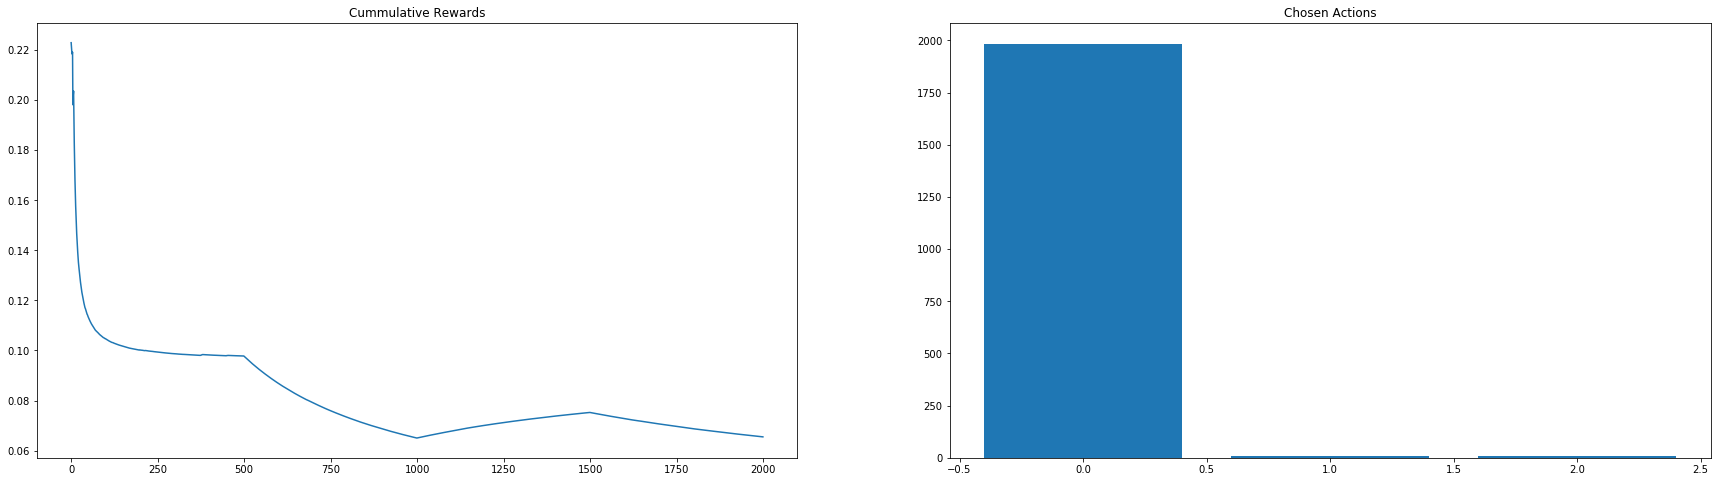

Total reward 130.9511


In [14]:
sample_mean_TS_stationary, sample_count_TS_stationary,rewards_TS_stationary,cum_rewards_TS_stationary,n_TS_stationary = list_iteration_results_TS_stationary
plot_history(rewards_TS_stationary,cum_rewards_TS_stationary, sample_count_TS_stationary, sample_mean_TS_stationary)
print("Total reward", np.round(total_reward_TS_stationary,4))

In [15]:
array_rewards = np.array(rewards_TS_stationary)
algo = rpt.Pelt(model="rbf").fit(array_rewards)
result = algo.predict(100)
result

[500, 1000, 1500, 2000]

498 0.621880544447753
499 0.280715031185518
998 0.8131938427490619
1498 0.44302946778657565
1499 0.46614238696954524


C:\Users\iRacheva\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


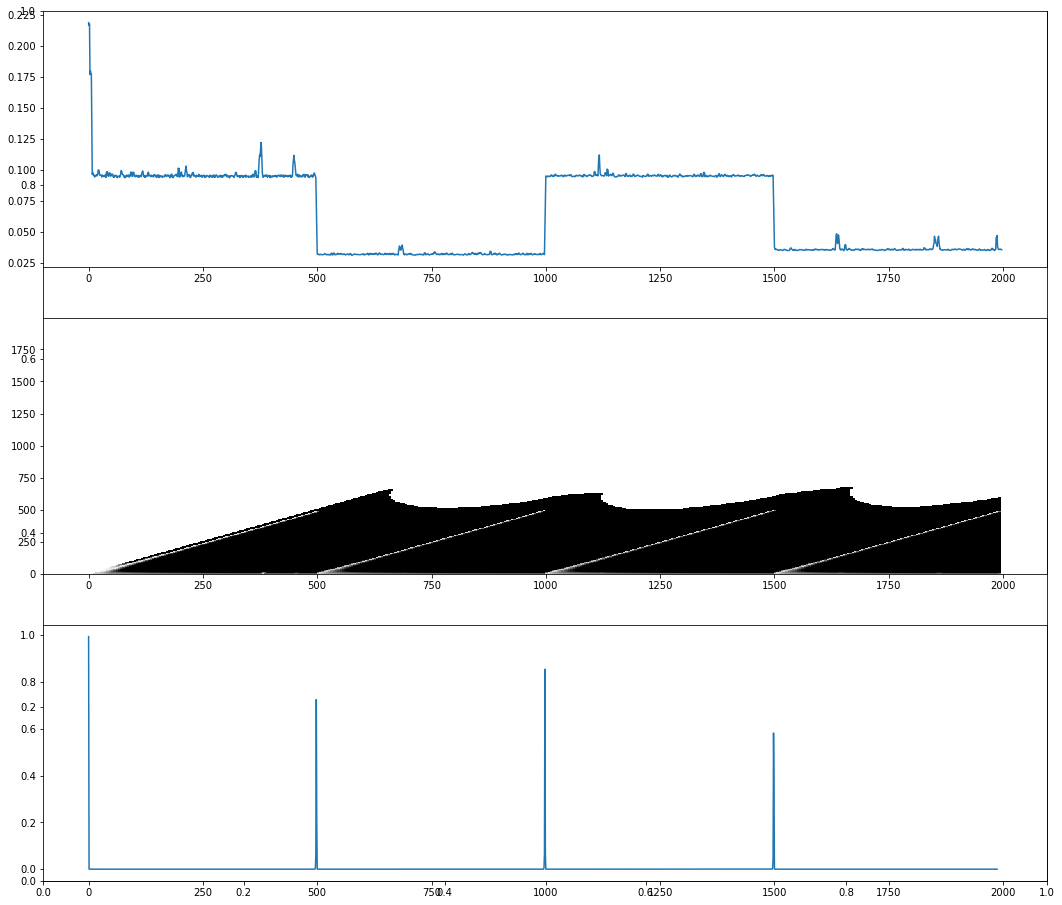

In [19]:
array_rewards_ma = moving_average(array_rewards, 3)
R, maxes = oncd.online_changepoint_detection(array_rewards_ma, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))
Nw=3
for i, elem in enumerate(R[Nw,Nw:-1]):
    if elem > 0.2 and i!=0:
        print(i,elem)
        
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(array_rewards_ma)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

### Online changepoint detection: Bayesian Online change detection algorithm (https://arxiv.org/abs/0710.3742, https://nbviewer.jupyter.org/github/hildensia/bayesian_changepoint_detection/blob/master/Example%20Code.ipynb)

In [16]:
def TS_obcp(list_distributions, n_samples, var_multiplier = 5):
    # initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = var_multiplier
    list_iteration_results = []

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))

        array_rewards = np.array(rewards)
        #print(array_rewards)   
        if(len(array_rewards)>4):
            array_rewards_ma = moving_average(array_rewards, 3)
            R, maxes = oncd.online_changepoint_detection(array_rewards_ma, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))
            Nw=3
            #print("R",R)
            for i, elem in enumerate(R[Nw,Nw:-1]):
                if elem > 0.2 and i!=0:
                        print("RESTART EXPERIMENT AT ITERATION:", n)

                        list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                        sample_count = [0 for i in range(num_choices)]
                        sample_rewards = [0 for i in range(num_choices)]
                        sample_mean = [0.0 for i in range(num_choices)]
                        sample_var = [0.0 for i in range(num_choices)]
                        arm_rewards = {0: [], 1:[], 2:[]}
                        rewards = []
                        cum_rewards = []
                        n_consecutive_list = []


    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [17]:
list_iteration_results_obcp, total_reward_obcp = TS_obcp(list_distributions=list_distributions, n_samples=n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.8200888082452084
Less than two values for merge_sort
merge_sort Theta 0.5820789704951671
Less than two values for heap_sort
heap_sort Theta 0.02768969293123369


Chosen algorithm is:  heap_sort with reward: 0.2125017000000753
Sample mean is:  0.2125017000000753 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.26409389256058147
Less than two values for merge_sort
merge_sort Theta 0.7463218145315923
Less than two values for heap_sort
heap_sort Theta 0.34588250704481194


Chosen algorithm is:  quick_sort with reward: 0.0931430000000546
Sample mean is:  0.0931430000000546 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.2724252897440381
Less than two values for merge_sort
merge_sort Theta 0.9955357794866952
Less than two values for heap_sort
heap_sort Theta 0.33362755577945924


Chosen algorithm is:  quick_sort with reward: 0.099535



Chosen algorithm is:  quick_sort with reward: 0.09656429999995453
Sample mean is:  0.09627850000000486 Sample variance is: 9.40882086524526e-06


Iteration: 27
quick_sort Theta 0.09298587646442365
merge_sort Theta 0.09500590536958281
Less than two values for heap_sort
heap_sort Theta 0.5736579270329595


Chosen algorithm is:  quick_sort with reward: 0.0938108000000284
Sample mean is:  0.09617567916667251 Sample variance is: 9.259945509171377e-06


Iteration: 28
quick_sort Theta 0.09323021316316035
merge_sort Theta 0.10453271140518604
Less than two values for heap_sort
heap_sort Theta 0.9085152885775558


Chosen algorithm is:  quick_sort with reward: 0.09638670000003913
Sample mean is:  0.09618412000000717 Sample variance is: 8.891257632821727e-06


Iteration: 29
quick_sort Theta 0.09771714921822575
merge_sort Theta 0.10624460669146445
Less than two values for heap_sort
heap_sort Theta 0.614321955654021


Chosen algorithm is:  quick_sort with reward: 0.09755059999997684
Sample mean is



Iteration: 55
quick_sort Theta 0.09669658807922386
merge_sort Theta 0.10248477498971152
heap_sort Theta 0.2048720614846711


Chosen algorithm is:  quick_sort with reward: 0.09630990000005113
Sample mean is:  0.09592275294118298 Sample variance is: 6.384376903669756e-06


Iteration: 56
quick_sort Theta 0.09452814086649623
merge_sort Theta 0.07933971554755236
heap_sort Theta 0.2269744148067391


Chosen algorithm is:  merge_sort with reward: 0.1058727000000772
Sample mean is:  0.10458597500002043 Sample variance is: 1.340127656906575e-06


Iteration: 57
quick_sort Theta 0.09917938440855278
merge_sort Theta 0.10078663113610903
heap_sort Theta 0.21189421569685807


Chosen algorithm is:  quick_sort with reward: 0.09292500000003656
Sample mean is:  0.09586510384616094 Sample variance is: 6.431094750752938e-06


Iteration: 58
quick_sort Theta 0.0929453293525202
merge_sort Theta 0.10545133255840143
heap_sort Theta 0.2127710401848923


Chosen algorithm is:  quick_sort with reward: 0.0953636000



Chosen algorithm is:  quick_sort with reward: 0.09645030000001498
Sample mean is:  0.0958252139240542 Sample variance is: 6.098650574856348e-06


Iteration: 87
quick_sort Theta 0.09651934993109175
merge_sort Theta 0.10435432693390112
heap_sort Theta 0.211617961438647


Chosen algorithm is:  quick_sort with reward: 0.09397819999992407
Sample mean is:  0.09580212625000258 Sample variance is: 6.064527657426662e-06


Iteration: 88
quick_sort Theta 0.09664397308630164
merge_sort Theta 0.10291983019618851
heap_sort Theta 0.21193126717372626


Chosen algorithm is:  quick_sort with reward: 0.09580870000002051
Sample mean is:  0.0958022074074102 Sample variance is: 5.989657472528565e-06


Iteration: 89
quick_sort Theta 0.0946153339743123
merge_sort Theta 0.10081257038443812
heap_sort Theta 0.2167475293224299


Chosen algorithm is:  quick_sort with reward: 0.09627690000002076
Sample mean is:  0.09580799634146643 Sample variance is: 5.919327321563139e-06


Iteration: 90
quick_sort Theta 0.09486



Iteration: 118
quick_sort Theta 0.09544743753332642
merge_sort Theta 0.10781681724897228
heap_sort Theta 0.21371345487731988


Chosen algorithm is:  quick_sort with reward: 0.09808559999999034
Sample mean is:  0.09568901441441581 Sample variance is: 5.46548944104796e-06


Iteration: 119
quick_sort Theta 0.09590961412926281
merge_sort Theta 0.1030807633189334
heap_sort Theta 0.21360715483916434


Chosen algorithm is:  quick_sort with reward: 0.09702809999998863
Sample mean is:  0.09570097053571557 Sample variance is: 5.432557749036791e-06


Iteration: 120
quick_sort Theta 0.09549995209177767
merge_sort Theta 0.10873478424913129
heap_sort Theta 0.21570488082062345


Chosen algorithm is:  quick_sort with reward: 0.09384660000000622
Sample mean is:  0.09568456017699248 Sample variance is: 5.414643602567532e-06


Iteration: 121
quick_sort Theta 0.09553893907436374
merge_sort Theta 0.10444568843743807
heap_sort Theta 0.21223688821831377


Chosen algorithm is:  quick_sort with reward: 0.094



Chosen algorithm is:  quick_sort with reward: 0.0976596000000427
Sample mean is:  0.09551681619718597 Sample variance is: 5.205631383894385e-06


Iteration: 150
quick_sort Theta 0.09387136567235177
merge_sort Theta 0.10374161499303769
heap_sort Theta 0.21445761641984812


Chosen algorithm is:  quick_sort with reward: 0.09331029999998464
Sample mean is:  0.09550138601398875 Sample variance is: 5.203037225820727e-06


Iteration: 151
quick_sort Theta 0.09692790377484391
merge_sort Theta 0.10302026785795335
heap_sort Theta 0.19528018943633335


Chosen algorithm is:  quick_sort with reward: 0.09367889999998624
Sample mean is:  0.09548872986111373 Sample variance is: 5.18981050626384e-06


Iteration: 152
quick_sort Theta 0.09568774212277538
merge_sort Theta 0.10619285341779813
heap_sort Theta 0.21626091177858203


Chosen algorithm is:  quick_sort with reward: 0.0956784999999627
Sample mean is:  0.09549003862069201 Sample variance is: 5.1542653603041726e-06


Iteration: 153
quick_sort Theta



Iteration: 180
quick_sort Theta 0.09520238644137226
merge_sort Theta 0.09624498950673618
heap_sort Theta 0.21067356958817457


Chosen algorithm is:  quick_sort with reward: 0.0941246999999521
Sample mean is:  0.0953466491329518 Sample variance is: 4.886751731980428e-06


Iteration: 181
quick_sort Theta 0.09523249969937164
merge_sort Theta 0.10091514243913272
heap_sort Theta 0.21241757376923495


Chosen algorithm is:  quick_sort with reward: 0.09688940000000912
Sample mean is:  0.09535551551724522 Sample variance is: 4.872266961197492e-06


Iteration: 182
quick_sort Theta 0.09460025795096887
merge_sort Theta 0.10653252259764176
heap_sort Theta 0.21505084487608195


Chosen algorithm is:  quick_sort with reward: 0.09580219999998008
Sample mean is:  0.09535806800000371 Sample variance is: 4.845559074977366e-06


Iteration: 183
quick_sort Theta 0.09596274765497573
merge_sort Theta 0.10428673203423668
heap_sort Theta 0.22623624215942617


Chosen algorithm is:  quick_sort with reward: 0.094



Chosen algorithm is:  quick_sort with reward: 0.09647140000004129
Sample mean is:  0.09531339257426288 Sample variance is: 4.6730655801993715e-06


Iteration: 211
quick_sort Theta 0.09517084657534379
merge_sort Theta 0.1063043063164486
heap_sort Theta 0.21003967343186633


Chosen algorithm is:  quick_sort with reward: 0.09468329999992875
Sample mean is:  0.09531028866995582 Sample variance is: 4.651991665544083e-06


Iteration: 212
quick_sort Theta 0.09432408631949349
merge_sort Theta 0.10323898551342718
heap_sort Theta 0.21908199468920678


Chosen algorithm is:  quick_sort with reward: 0.1004005000000916
Sample mean is:  0.09533524068628 Sample variance is: 4.755576217915139e-06


Iteration: 213
quick_sort Theta 0.09630520823403686
merge_sort Theta 0.10737299456139505
heap_sort Theta 0.2120384475931165


Chosen algorithm is:  quick_sort with reward: 0.09353799999996681
Sample mean is:  0.0953264736585419 Sample variance is: 4.7480578833184345e-06


Iteration: 214
quick_sort Theta 0.

Iteration: 241
quick_sort Theta 0.09613903468295289
merge_sort Theta 0.10328511458648897
heap_sort Theta 0.2111780471997704


Chosen algorithm is:  quick_sort with reward: 0.09711879999997564
Sample mean is:  0.09528419227468152 Sample variance is: 4.508292716943669e-06


Iteration: 242
quick_sort Theta 0.09519854844782155
merge_sort Theta 0.1030334628400166
heap_sort Theta 0.2132731860104996


Chosen algorithm is:  quick_sort with reward: 0.09642859999996745
Sample mean is:  0.09528908290598616 Sample variance is: 4.494599466723601e-06


Iteration: 243
quick_sort Theta 0.0945600019201418
merge_sort Theta 0.10318585033140512
heap_sort Theta 0.21246276272226988


Chosen algorithm is:  quick_sort with reward: 0.09620410000002266
Sample mean is:  0.09529297659574801 Sample variance is: 4.479021143417067e-06


Iteration: 244
quick_sort Theta 0.09625973387973992
merge_sort Theta 0.10721382170280376
heap_sort Theta 0.2141445104670963


Chosen algorithm is:  quick_sort with reward: 0.09660040


Chosen algorithm is:  quick_sort with reward: 0.0950127999999495
Sample mean is:  0.09535269315589537 Sample variance is: 4.152937470984789e-06


Iteration: 272
quick_sort Theta 0.09467879263936417
merge_sort Theta 0.10281627309946377
heap_sort Theta 0.21422540896730768


Chosen algorithm is:  quick_sort with reward: 0.09590960000002724
Sample mean is:  0.09535480265151708 Sample variance is: 4.138376989808678e-06


Iteration: 273
quick_sort Theta 0.09439766054331598
merge_sort Theta 0.10164941998429117
heap_sort Theta 0.2139514020047292


Chosen algorithm is:  quick_sort with reward: 0.09389490000000933
Sample mean is:  0.09534929358490762 Sample variance is: 4.130772824001584e-06


Iteration: 274
quick_sort Theta 0.09439102406126007
merge_sort Theta 0.10462310789115639
heap_sort Theta 0.21207701000618412


Chosen algorithm is:  quick_sort with reward: 0.09628989999998794
Sample mean is:  0.09535282969925003 Sample variance is: 4.118557190589004e-06


Iteration: 275
quick_sort Theta 



Chosen algorithm is:  quick_sort with reward: 0.09344269999996868
Sample mean is:  0.0953256511945396 Sample variance is: 3.941575748648253e-06


Iteration: 303
quick_sort Theta 0.09509116129296395
merge_sort Theta 0.10923368447256954
heap_sort Theta 0.20464999288609842


Chosen algorithm is:  quick_sort with reward: 0.09634319999997842
Sample mean is:  0.09532911224489825 Sample variance is: 3.931678837203164e-06


Iteration: 304
quick_sort Theta 0.09591326389103681
merge_sort Theta 0.10610720078417467
heap_sort Theta 0.21249527086291503


Chosen algorithm is:  quick_sort with reward: 0.09362710000004881
Sample mean is:  0.09532334271186485 Sample variance is: 3.928137640689755e-06


Iteration: 305
quick_sort Theta 0.09554412475648456
merge_sort Theta 0.10629451394813622
heap_sort Theta 0.21892654613985796


Chosen algorithm is:  quick_sort with reward: 0.09928160000004027
Sample mean is:  0.09533671520270329 Sample variance is: 3.967619841228207e-06


Iteration: 306
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.09925889999999526
Sample mean is:  0.09544099475308597 Sample variance is: 3.9241041148864544e-06


Iteration: 334
quick_sort Theta 0.09540186224882787
merge_sort Theta 0.10540474617978414
heap_sort Theta 0.21505234245565197


Chosen algorithm is:  quick_sort with reward: 0.0968387000000348
Sample mean is:  0.09544529538461505 Sample variance is: 3.918022468200943e-06


Iteration: 335
quick_sort Theta 0.09551257647803077
merge_sort Theta 0.10854887346287842
heap_sort Theta 0.21070665199610675


Chosen algorithm is:  quick_sort with reward: 0.09640799999999672
Sample mean is:  0.09544824846625732 Sample variance is: 3.9088382190075365e-06


Iteration: 336
quick_sort Theta 0.09558996992277506
merge_sort Theta 0.10755878233044967
heap_sort Theta 0.28685390139312494


Chosen algorithm is:  quick_sort with reward: 0.09633489999998801
Sample mean is:  0.09545095993883754 Sample variance is: 3.899281364548631e-06


Iteration: 337
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.09676790000003166
Sample mean is:  0.09555006101694843 Sample variance is: 3.7507107663976543e-06


Iteration: 364
quick_sort Theta 0.09593810331299574
merge_sort Theta 0.10482518676896847
heap_sort Theta 0.21361174927580845


Chosen algorithm is:  quick_sort with reward: 0.09708409999996093
Sample mean is:  0.09555438225352031 Sample variance is: 3.7467556562276494e-06


Iteration: 365
quick_sort Theta 0.09551421975328873
merge_sort Theta 0.1105534381845813
heap_sort Theta 0.20771658595102746


Chosen algorithm is:  quick_sort with reward: 0.09606359999997949
Sample mean is:  0.09555581264044856 Sample variance is: 3.7369573940890907e-06


Iteration: 366
quick_sort Theta 0.09622764241002825
merge_sort Theta 0.1033048292901869
heap_sort Theta 0.212094728612899


Chosen algorithm is:  quick_sort with reward: 0.09629449999999906
Sample mean is:  0.09555788179271621 Sample variance is: 3.728013901552524e-06


Iteration: 367
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.09650039999996807
Sample mean is:  0.09563871796874797 Sample variance is: 3.5930200832484422e-06


Iteration: 394
quick_sort Theta 0.09503170100917539
merge_sort Theta 0.1066127762816589
heap_sort Theta 0.21133717343779868


Chosen algorithm is:  quick_sort with reward: 0.09582350000005135
Sample mean is:  0.09563919792207604 Sample variance is: 3.583776019947386e-06


Iteration: 395
quick_sort Theta 0.09591907366557158
merge_sort Theta 0.10715701749212855
heap_sort Theta 0.212442226028662


Chosen algorithm is:  quick_sort with reward: 0.09544329999994261
Sample mean is:  0.09563869041450573 Sample variance is: 3.5745907882278786e-06


Iteration: 396
quick_sort Theta 0.09649198092876994
merge_sort Theta 0.10473040910128814
heap_sort Theta 0.21217661912930283


Chosen algorithm is:  quick_sort with reward: 0.09581860000002962
Sample mean is:  0.09563915529715568 Sample variance is: 3.5654375402534357e-06


Iteration: 397
quick_sort The



Chosen algorithm is:  heap_sort with reward: 0.21252640000000156
Sample mean is:  0.21275456666667955 Sample variance is: 1.157982155303691e-07


Iteration: 424
quick_sort Theta 0.09568267897663706
merge_sort Theta 0.1068947183358659
heap_sort Theta 0.2130663893165465


Chosen algorithm is:  quick_sort with reward: 0.09686460000000352
Sample mean is:  0.09571563357487808 Sample variance is: 3.4495299579845855e-06


Iteration: 425
quick_sort Theta 0.09547745524241881
merge_sort Theta 0.10557146290440204
heap_sort Theta 0.212621386377498


Chosen algorithm is:  quick_sort with reward: 0.09717280000006667
Sample mean is:  0.09571914481927613 Sample variance is: 3.4463219762141393e-06


Iteration: 426
quick_sort Theta 0.09597507393452119
merge_sort Theta 0.10293632920768653
heap_sort Theta 0.21159817198672037


Chosen algorithm is:  quick_sort with reward: 0.09783130000005258
Sample mean is:  0.09572422211538377 Sample variance is: 3.448735806729015e-06
RESTART EXPERIMENT AT ITERATION: 4

quick_sort Theta 0.06101756820112647
merge_sort Theta 0.10643799030624497
Less than two values for heap_sort
heap_sort Theta 0.9240718684842663


Chosen algorithm is:  quick_sort with reward: 0.09597439999993185
Sample mean is:  0.09470114999993484 Sample variance is: 1.6211655624923756e-06


Iteration: 449
quick_sort Theta 0.09475575778084162
merge_sort Theta 0.1057851019974852
Less than two values for heap_sort
heap_sort Theta 0.9100271989423044


Chosen algorithm is:  quick_sort with reward: 0.09653639999999086
Sample mean is:  0.09531289999995352 Sample variance is: 1.8292531667072786e-06


Iteration: 450
quick_sort Theta 0.09425769769335242
merge_sort Theta 0.1057031244431101
Less than two values for heap_sort
heap_sort Theta 0.022247176428427107


Chosen algorithm is:  heap_sort with reward: 0.21098239999992074
Sample mean is:  0.21319344999994883 Sample variance is: 4.888742102624176e-06


Iteration: 451
quick_sort Theta 0.09534900468174111
merge_sort Theta 0.10691519921975332
h



Iteration: 479
quick_sort Theta 0.09454121743489365
merge_sort Theta 0.10501361762620448
heap_sort Theta 0.21964043613130027


Chosen algorithm is:  quick_sort with reward: 0.09654339999997319
Sample mean is:  0.09526476129032758 Sample variance is: 2.4726425481776233e-06


Iteration: 480
quick_sort Theta 0.09642780890509221
merge_sort Theta 0.10438938600927689
heap_sort Theta 0.22275753038422394


Chosen algorithm is:  quick_sort with reward: 0.09625489999996262
Sample mean is:  0.09529570312500368 Sample variance is: 2.425051779673878e-06


Iteration: 481
quick_sort Theta 0.09502155811889108
merge_sort Theta 0.10523681084601233
heap_sort Theta 0.20933713512199845


Chosen algorithm is:  quick_sort with reward: 0.095279000000005
Sample mean is:  0.0952951969697007 Sample variance is: 2.3515735602901074e-06


Iteration: 482
quick_sort Theta 0.09684152008985464
merge_sort Theta 0.10310554214261497
heap_sort Theta 0.21231075591218448


Chosen algorithm is:  quick_sort with reward: 0.09



Iteration: 510
quick_sort Theta 0.09149714566856351
merge_sort Theta 0.1426702548457273
heap_sort Theta 0.2117600087149063


Chosen algorithm is:  quick_sort with reward: 0.031630400000040026
Sample mean is:  0.08582881000000195 Sample variance is: 0.0005058888221839796


Iteration: 511
quick_sort Theta 0.06542533063730335
merge_sort Theta 0.08134506037920608
heap_sort Theta 0.20997153846502056


Chosen algorithm is:  quick_sort with reward: 0.03162409999993088
Sample mean is:  0.08494020819672209 Sample variance is: 0.0005449723526914466


Iteration: 512
quick_sort Theta 0.07178512723793425
merge_sort Theta 0.0765452324947694
heap_sort Theta 0.21792403731604096


Chosen algorithm is:  quick_sort with reward: 0.032388100000048325
Sample mean is:  0.08409259354838865 Sample variance is: 0.0005800079621513687


Iteration: 513
quick_sort Theta 0.09772903475146666
merge_sort Theta 0.11444926210370991
heap_sort Theta 0.2211712471996532


Chosen algorithm is:  quick_sort with reward: 0.031



Iteration: 540
quick_sort Theta 0.06804462898273525
merge_sort Theta 0.09212128596762331
heap_sort Theta 0.20516518919356677


Chosen algorithm is:  quick_sort with reward: 0.03197789999990164
Sample mean is:  0.07183619135802766 Sample variance is: 0.0009341673738185454


Iteration: 541
quick_sort Theta 0.06640636678213467
merge_sort Theta 0.053270573949071656
heap_sort Theta 0.23788737067289725


Chosen algorithm is:  merge_sort with reward: 0.02635609999992994
Sample mean is:  0.07427083870967519 Sample variance is: 0.0014806549807866974


Iteration: 542
quick_sort Theta 0.06030400593535151
merge_sort Theta 0.11389665161544776
heap_sort Theta 0.2180023985047248


Chosen algorithm is:  quick_sort with reward: 0.032577100000025894
Sample mean is:  0.07135742195122276 Sample variance is: 0.0009413419205082555


Iteration: 543
quick_sort Theta 0.0705156236554648
merge_sort Theta 0.023821239788550427
heap_sort Theta 0.20731576062869705


Chosen algorithm is:  merge_sort with reward: 0.



Iteration: 570
quick_sort Theta 0.05784878079482823
merge_sort Theta 0.12454887926316052
heap_sort Theta 0.21284280190314525


Chosen algorithm is:  quick_sort with reward: 0.03200949999995828
Sample mean is:  0.06597910947368626 Sample variance is: 0.0009950211150425833


Iteration: 571
quick_sort Theta 0.07095783923234208
merge_sort Theta 0.062406013717372255
heap_sort Theta 0.20918512748860735


Chosen algorithm is:  merge_sort with reward: 0.026297300000010182
Sample mean is:  0.05782248723403427 Sample variance is: 0.0015008473445162695


Iteration: 572
quick_sort Theta 0.059678669604899856
merge_sort Theta 0.11309980297025535
heap_sort Theta 0.21490878887711873


Chosen algorithm is:  quick_sort with reward: 0.03133370000000468
Sample mean is:  0.06561821979166875 Sample variance is: 0.0009970292412066265


Iteration: 573
quick_sort Theta 0.06268368114733527
merge_sort Theta 0.07517027405705683
heap_sort Theta 0.21453921287333658


Chosen algorithm is:  quick_sort with reward: 



Iteration: 600
quick_sort Theta 0.08438710867613548
merge_sort Theta 0.03469677952977457
heap_sort Theta 0.21646696925382036


Chosen algorithm is:  merge_sort with reward: 0.026854699999944387
Sample mean is:  0.048316614925372064 Sample variance is: 0.0012652363498393399


Iteration: 601
quick_sort Theta 0.08234433832182901
merge_sort Theta 0.07926755761312569
heap_sort Theta 0.2118339430099862


Chosen algorithm is:  merge_sort with reward: 0.026245199999948454
Sample mean is:  0.04799203529411583 Sample variance is: 0.0012536885127107085


Iteration: 602
quick_sort Theta 0.06004833425392336
merge_sort Theta 0.08442654614753999
heap_sort Theta 0.21303891002354494


Chosen algorithm is:  quick_sort with reward: 0.031765500000005886
Sample mean is:  0.062745285714289 Sample variance is: 0.0009996284383809952


Iteration: 603
quick_sort Theta 0.049148804925607505
merge_sort Theta 0.05658840920852857
heap_sort Theta 0.22596216861835927


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 630
quick_sort Theta 0.06085101489250085
merge_sort Theta 0.08103423906480499
heap_sort Theta 0.2119739660778971


Chosen algorithm is:  quick_sort with reward: 0.03156150000006619
Sample mean is:  0.05959249059829496 Sample variance is: 0.0009840923316434933


Iteration: 631
quick_sort Theta 0.06756216050310922
merge_sort Theta 0.07602931130929769
heap_sort Theta 0.2237366839228005


Chosen algorithm is:  quick_sort with reward: 0.0339561999999205
Sample mean is:  0.05937523389830873 Sample variance is: 0.0009812750215426925


Iteration: 632
quick_sort Theta 0.06320999753567326
merge_sort Theta 0.04004583586748632
heap_sort Theta 0.21288748130872612


Chosen algorithm is:  merge_sort with reward: 0.027442199999995864
Sample mean is:  0.043604150588235184 Sample variance is: 0.0010800562744183579


Iteration: 633
quick_sort Theta 0.05111482079481038
merge_sort Theta 0.049903638325927216
heap_sort Theta 0.20827640580426313


Chosen algorithm is:  merge_sort with reward: 0.0



Iteration: 661
quick_sort Theta 0.061385325138146624
merge_sort Theta 0.033419200392438085
heap_sort Theta 0.20942924427636855


Chosen algorithm is:  merge_sort with reward: 0.02601599999991322
Sample mean is:  0.040024987962961285 Sample variance is: 0.0008982082329120851


Iteration: 662
quick_sort Theta 0.06040901889537595
merge_sort Theta 0.03234149849132299
heap_sort Theta 0.21854022923976968


Chosen algorithm is:  merge_sort with reward: 0.02732309999998961
Sample mean is:  0.03990845688073219 Sample variance is: 0.0008914343756658567


Iteration: 663
quick_sort Theta 0.1029268209592664
merge_sort Theta 0.028053213224328556
heap_sort Theta 0.22370318551701607


Chosen algorithm is:  merge_sort with reward: 0.02539409999997133
Sample mean is:  0.03977650818181618 Sample variance is: 0.0008852281668430401


Iteration: 664
quick_sort Theta 0.06290467224107894
merge_sort Theta 0.041914219148225275
heap_sort Theta 0.21391395578132


Chosen algorithm is:  merge_sort with reward: 0.

heap_sort Theta 0.20351486316458955


Chosen algorithm is:  merge_sort with reward: 0.02844100000004346
Sample mean is:  0.03736859111110739 Sample variance is: 0.0007470982450508672


Iteration: 692
quick_sort Theta 0.049513711517009666
merge_sort Theta 0.051402980730327175
heap_sort Theta 0.21159440280961248


Chosen algorithm is:  quick_sort with reward: 0.03336879999994835
Sample mean is:  0.05729076484375373 Sample variance is: 0.0009560044955797237


Iteration: 693
quick_sort Theta 0.018738325983571218
merge_sort Theta 0.04978799798855742
heap_sort Theta 0.20492026324339568


Chosen algorithm is:  quick_sort with reward: 0.03214200000002165
Sample mean is:  0.05709581317829844 Sample variance is: 0.0009534583954556553


Iteration: 694
quick_sort Theta 0.05704517023348024
merge_sort Theta 0.05036485786964895
heap_sort Theta 0.21609629828772406


Chosen algorithm is:  merge_sort with reward: 0.02568029999997634
Sample mean is:  0.03728264779411378 Sample variance is: 0.000742602019

heap_sort Theta 0.21541005208437936


Chosen algorithm is:  quick_sort with reward: 0.03596500000003289
Sample mean is:  0.05603374444444853 Sample variance is: 0.0009354635470530697


Iteration: 723
quick_sort Theta 0.037364716139927506
merge_sort Theta 0.02938974145136103
heap_sort Theta 0.21563284544334432


Chosen algorithm is:  merge_sort with reward: 0.028960600000004888
Sample mean is:  0.03592137169811017 Sample variance is: 0.0006465312501525687


Iteration: 724
quick_sort Theta 0.06207215415923855
merge_sort Theta 0.04794405712442573
heap_sort Theta 0.2136869815933589


Chosen algorithm is:  merge_sort with reward: 0.02707620000001043
Sample mean is:  0.035866089374997044 Sample variance is: 0.0006429763553436714


Iteration: 725
quick_sort Theta 0.06730170973106922
merge_sort Theta 0.02824372340684702
heap_sort Theta 0.21451301590142832


Chosen algorithm is:  merge_sort with reward: 0.02591359999996712
Sample mean is:  0.03580427267080431 Sample variance is: 0.0006395941221



Iteration: 753
quick_sort Theta 0.06715348224382801
merge_sort Theta 0.04051666322175002
heap_sort Theta 0.21142184794358782


Chosen algorithm is:  merge_sort with reward: 0.027616300000090632
Sample mean is:  0.034743409090908325 Sample variance is: 0.0005579080027426978


Iteration: 754
quick_sort Theta 0.049337838519981664
merge_sort Theta 0.03831967379700199
heap_sort Theta 0.20959906129742015


Chosen algorithm is:  merge_sort with reward: 0.028262000000040643
Sample mean is:  0.03470893351063775 Sample variance is: 0.0005551626687571716


Iteration: 755
quick_sort Theta 0.062091768128136986
merge_sort Theta 0.02464790624679157
heap_sort Theta 0.19606484751313985


Chosen algorithm is:  merge_sort with reward: 0.0295582999999624
Sample mean is:  0.034681681481480736 Sample variance is: 0.0005523649226809258


Iteration: 756
quick_sort Theta 0.0431625088544912
merge_sort Theta 0.029848210503965213
heap_sort Theta 0.2116352898782865


Chosen algorithm is:  merge_sort with reward:

Iteration: 783
quick_sort Theta 0.07047523620750734
merge_sort Theta 0.0332219648718226
heap_sort Theta 0.2125965765741288


Chosen algorithm is:  merge_sort with reward: 0.030899400000066635
Sample mean is:  0.03390715813953637 Sample variance is: 0.0004900427898832917


Iteration: 784
quick_sort Theta 0.07303585979733124
merge_sort Theta 0.03408255940334001
heap_sort Theta 0.19530583863463177


Chosen algorithm is:  merge_sort with reward: 0.028011999999989712
Sample mean is:  0.03387986574074217 Sample variance is: 0.0004879342213953292


Iteration: 785
quick_sort Theta 0.060018390230100624
merge_sort Theta 0.030215310801145045
heap_sort Theta 0.21429084888052002


Chosen algorithm is:  merge_sort with reward: 0.028429999999957545
Sample mean is:  0.033854751152074966 Sample variance is: 0.0004858219169900798


Iteration: 786
quick_sort Theta 0.04717648479494613
merge_sort Theta 0.031908586108171495
heap_sort Theta 0.20413696083300514


Chosen algorithm is:  merge_sort with reward: 


Iteration: 813
quick_sort Theta 0.06864034811651507
merge_sort Theta 0.02062284863790069
heap_sort Theta 0.20604335580287353


Chosen algorithm is:  merge_sort with reward: 0.02852010000003702
Sample mean is:  0.03318917901234738 Sample variance is: 0.000437690110280682


Iteration: 814
quick_sort Theta 0.043919556933962246
merge_sort Theta 0.029258850639513296
heap_sort Theta 0.21357971768114645


Chosen algorithm is:  merge_sort with reward: 0.026868400000012116
Sample mean is:  0.03316327418032961 Sample variance is: 0.00043605936601151643


Iteration: 815
quick_sort Theta 0.06766750531702408
merge_sort Theta 0.022398194102643883
heap_sort Theta 0.2049165221694545


Chosen algorithm is:  merge_sort with reward: 0.0273059999999532
Sample mean is:  0.03313936693877705 Sample variance is: 0.00043441899157700166


Iteration: 816
quick_sort Theta 0.0663381740089483
merge_sort Theta 0.030514020678439724
heap_sort Theta 0.21662697906893377


Chosen algorithm is:  merge_sort with reward: 0



Iteration: 843
quick_sort Theta 0.06310132072804271
merge_sort Theta 0.03194640057363038
heap_sort Theta 0.20935604238851646


Chosen algorithm is:  merge_sort with reward: 0.027268299999946066
Sample mean is:  0.032601155350553905 Sample variance is: 0.0003955064250954843


Iteration: 844
quick_sort Theta 0.05450715148714336
merge_sort Theta 0.038861818232585936
heap_sort Theta 0.17985967307356254


Chosen algorithm is:  merge_sort with reward: 0.027262099999916245
Sample mean is:  0.032581526470588325 Sample variance is: 0.0003941567717398413


Iteration: 845
quick_sort Theta 0.07988181270749224
merge_sort Theta 0.02642221977657214
heap_sort Theta 0.28600381055311364


Chosen algorithm is:  merge_sort with reward: 0.0273059999999532
Sample mean is:  0.03256220219780211 Sample variance is: 0.00039281454632625107


Iteration: 846
quick_sort Theta 0.06375605460314804
merge_sort Theta 0.03214359623959518
heap_sort Theta 0.21060113766803049


Chosen algorithm is:  merge_sort with reward



Iteration: 873
quick_sort Theta 0.046446516382243966
merge_sort Theta 0.03829914582596939
heap_sort Theta 0.2130869253650364


Chosen algorithm is:  merge_sort with reward: 0.027923500000042623
Sample mean is:  0.03213469230769363 Sample variance is: 0.0003606337225373789


Iteration: 874
quick_sort Theta 0.06123688039059447
merge_sort Theta 0.02729911989042988
heap_sort Theta 0.2054202642691695


Chosen algorithm is:  merge_sort with reward: 0.027453299999933733
Sample mean is:  0.03211908766666776 Sample variance is: 0.0003595044180705632


Iteration: 875
quick_sort Theta 0.06745162874920008
merge_sort Theta 0.02708502620740973
heap_sort Theta 0.21484310133876153


Chosen algorithm is:  merge_sort with reward: 0.026470800000083727
Sample mean is:  0.032100322591363493 Sample variance is: 0.00035841568964847185


Iteration: 876
quick_sort Theta 0.06331148581795579
merge_sort Theta 0.039052778666509774
heap_sort Theta 0.22013992077598557


Chosen algorithm is:  merge_sort with reward



Iteration: 903
quick_sort Theta 0.039327623603512565
merge_sort Theta 0.033455404728546446
heap_sort Theta 0.23745758292574276


Chosen algorithm is:  merge_sort with reward: 0.026118600000017977
Sample mean is:  0.03166132492401388 Sample variance is: 0.0003300512882600563


Iteration: 904
quick_sort Theta 0.07306107618345012
merge_sort Theta 0.02939398632428087
heap_sort Theta 0.20680444115094263


Chosen algorithm is:  merge_sort with reward: 0.026864700000032826
Sample mean is:  0.03164678969697151 Sample variance is: 0.00032912064160056843


Iteration: 905
quick_sort Theta 0.07929350403519346
merge_sort Theta 0.03500902795660975
heap_sort Theta 0.2145995572761535


Chosen algorithm is:  merge_sort with reward: 0.027770799999984774
Sample mean is:  0.03163507975830992 Sample variance is: 0.0003281715698994475


Iteration: 906
quick_sort Theta 0.050726146043907704
merge_sort Theta 0.036633550670106506
heap_sort Theta 0.21232529826107413


Chosen algorithm is:  merge_sort with rewa



Iteration: 933
quick_sort Theta 0.07646562950208803
merge_sort Theta 0.029067619032936122
heap_sort Theta 0.22047233236422842


Chosen algorithm is:  merge_sort with reward: 0.02629500000000462
Sample mean is:  0.031248868156425722 Sample variance is: 0.00030530619287536843


Iteration: 934
quick_sort Theta 0.04123578649496144
merge_sort Theta 0.034458568620754026
heap_sort Theta 0.2112393054529704


Chosen algorithm is:  merge_sort with reward: 0.027774700000009034
Sample mean is:  0.031239190807800608 Sample variance is: 0.00030448928488307673


Iteration: 935
quick_sort Theta 0.028742063702596
merge_sort Theta 0.03244916864171578
heap_sort Theta 0.20774044443369527


Chosen algorithm is:  quick_sort with reward: 0.03179920000002312
Sample mean is:  0.05420189523809987 Sample variance is: 0.000897021650730163


Iteration: 936
quick_sort Theta 0.07031730236792699
merge_sort Theta 0.03671838547459019
heap_sort Theta 0.20524174085282204


Chosen algorithm is:  merge_sort with reward: 



Iteration: 963
quick_sort Theta 0.040751546905453934
merge_sort Theta 0.030853219076697913
heap_sort Theta 0.2229399331791237


Chosen algorithm is:  merge_sort with reward: 0.02656930000000557
Sample mean is:  0.03090223636363855 Sample variance is: 0.00028551513394480964


Iteration: 964
quick_sort Theta 0.0544454588563894
merge_sort Theta 0.02897217774061053
heap_sort Theta 0.2167441662413093


Chosen algorithm is:  merge_sort with reward: 0.02642839999998614
Sample mean is:  0.030890646113991782 Sample variance is: 0.0002848271759784459


Iteration: 965
quick_sort Theta 0.022282436683379696
merge_sort Theta 0.024853299902934906
heap_sort Theta 0.21115503380457232


Chosen algorithm is:  quick_sort with reward: 0.032944600000064383
Sample mean is:  0.05376434133333836 Sample variance is: 0.0008884663140667244


Iteration: 966
quick_sort Theta 0.046183023364523956
merge_sort Theta 0.026645248759240618
heap_sort Theta 0.2070698413545617


Chosen algorithm is:  merge_sort with reward



Iteration: 993
quick_sort Theta 0.04355897067891485
merge_sort Theta 0.03256848057691015
heap_sort Theta 0.21804427309591423


Chosen algorithm is:  merge_sort with reward: 0.02657520000002478
Sample mean is:  0.030634784708739832 Sample variance is: 0.00026788489360513235


Iteration: 994
quick_sort Theta 0.0391906148693909
merge_sort Theta 0.0279816760300055
heap_sort Theta 0.20868999662391075


Chosen algorithm is:  merge_sort with reward: 0.02612469999996847
Sample mean is:  0.030623864406781547 Sample variance is: 0.0002672853941353702


Iteration: 995
quick_sort Theta 0.06213138221739466
merge_sort Theta 0.02816164552975673
heap_sort Theta 0.22532960459190934


Chosen algorithm is:  merge_sort with reward: 0.025845699999990757
Sample mean is:  0.030612322946861763 Sample variance is: 0.00026669479102901745


Iteration: 996
quick_sort Theta 0.06374067003866757
merge_sort Theta 0.038253392140756313
heap_sort Theta 0.17133769342995336


Chosen algorithm is:  merge_sort with reward



Chosen algorithm is:  quick_sort with reward: 0.09949910000000273
Sample mean is:  0.09555208181818257 Sample variance is: 3.2723536414654684e-06


Iteration: 1021
quick_sort Theta 0.09294224081252289
Less than two values for merge_sort
merge_sort Theta 0.523867952476988
heap_sort Theta 0.2078862759348736


Chosen algorithm is:  quick_sort with reward: 0.09335780000003524
Sample mean is:  0.09536922500000362 Sample variance is: 3.3674602801764826e-06


Iteration: 1022
quick_sort Theta 0.09530072277632229
Less than two values for merge_sort
merge_sort Theta 0.7332318386315896
heap_sort Theta 0.20849578493241977


Chosen algorithm is:  quick_sort with reward: 0.09555520000003526
Sample mean is:  0.09538353076923684 Sample variance is: 3.1108807344093045e-06


Iteration: 1023
quick_sort Theta 0.0914077252964808
Less than two values for merge_sort
merge_sort Theta 0.3090899560170127
heap_sort Theta 0.21228366713750188


Chosen algorithm is:  quick_sort with reward: 0.09618269999998574
Sa



Chosen algorithm is:  quick_sort with reward: 0.09611319999999068
Sample mean is:  0.0954623026315774 Sample variance is: 2.7236673786927636e-06


Iteration: 1051
quick_sort Theta 0.09764048421727713
merge_sort Theta 0.10271437306837324
heap_sort Theta 0.214615450445967


Chosen algorithm is:  quick_sort with reward: 0.09350580000000264
Sample mean is:  0.09541213589743446 Sample variance is: 2.749464399751687e-06


Iteration: 1052
quick_sort Theta 0.09562056935908964
merge_sort Theta 0.09873981119161292
heap_sort Theta 0.20003761963281608


Chosen algorithm is:  quick_sort with reward: 0.09556870000005802
Sample mean is:  0.09541605000000004 Sample variance is: 2.681325277514759e-06


Iteration: 1053
quick_sort Theta 0.09686688565834428
merge_sort Theta 0.10359236475249421
heap_sort Theta 0.19659453831929427


Chosen algorithm is:  quick_sort with reward: 0.09548100000006343
Sample mean is:  0.09541763414634305 Sample variance is: 2.616027480799842e-06


Iteration: 1054
quick_sort T



Chosen algorithm is:  quick_sort with reward: 0.09621570000001611
Sample mean is:  0.09534097352941645 Sample variance is: 2.71234768811086e-06


Iteration: 1081
quick_sort Theta 0.09625561799645942
merge_sort Theta 0.10304381637332345
heap_sort Theta 0.2054956037079751


Chosen algorithm is:  quick_sort with reward: 0.09308649999991303
Sample mean is:  0.09530830000000336 Sample variance is: 2.745632348979606e-06


Iteration: 1082
quick_sort Theta 0.09495568866689684
merge_sort Theta 0.1013448979012146
heap_sort Theta 0.20786300608305952


Chosen algorithm is:  quick_sort with reward: 0.09393180000006396
Sample mean is:  0.09528863571428993 Sample variance is: 2.7330902348591807e-06


Iteration: 1083
quick_sort Theta 0.09520783173698943
merge_sort Theta 0.10145834034487554
heap_sort Theta 0.21354499041921032


Chosen algorithm is:  quick_sort with reward: 0.09606329999996888
Sample mean is:  0.09529954647887696 Sample variance is: 2.702929141070339e-06


Iteration: 1084
quick_sort T



Chosen algorithm is:  quick_sort with reward: 0.0970642999999427
Sample mean is:  0.09516700102041137 Sample variance is: 2.74794512234542e-06


Iteration: 1111
quick_sort Theta 0.09659661935583919
merge_sort Theta 0.09762176811922091
heap_sort Theta 0.20857395903443257


Chosen algorithm is:  quick_sort with reward: 0.0927983999999924
Sample mean is:  0.09514307575757885 Sample variance is: 2.776285084664869e-06


Iteration: 1112
quick_sort Theta 0.0945717118846023
merge_sort Theta 0.10197126901952813
heap_sort Theta 0.2078936995263335


Chosen algorithm is:  quick_sort with reward: 0.09364259999995284
Sample mean is:  0.09512807100000259 Sample variance is: 2.7708113660605317e-06


Iteration: 1113
quick_sort Theta 0.09417610145334214
merge_sort Theta 0.10191738808279022
heap_sort Theta 0.20498665471461452


Chosen algorithm is:  quick_sort with reward: 0.09643679999999222
Sample mean is:  0.09514102871287378 Sample variance is: 2.7601678224441487e-06


Iteration: 1114
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.09642870000004677
Sample mean is:  0.09581564263566031 Sample variance is: 2.2169870826432026e-05


Iteration: 1142
quick_sort Theta 0.09616161185499662
merge_sort Theta 0.10474104052943008
heap_sort Theta 0.2105296909516858


Chosen algorithm is:  quick_sort with reward: 0.09296530000005987
Sample mean is:  0.09579371692307877 Sample variance is: 2.2061348415051277e-05


Iteration: 1143
quick_sort Theta 0.09596749285576958
merge_sort Theta 0.10263617695175267
heap_sort Theta 0.21349536793233226


Chosen algorithm is:  quick_sort with reward: 0.09445790000006582
Sample mean is:  0.09578351984733058 Sample variance is: 2.190645862123759e-05


Iteration: 1144
quick_sort Theta 0.09576134181731136
merge_sort Theta 0.10000455038716913
heap_sort Theta 0.20054837248471105


Chosen algorithm is:  quick_sort with reward: 0.09407570000007581
Sample mean is:  0.09577058181818471 Sample variance is: 2.1762429031741224e-05


Iteration: 1145
quick_so

Chosen algorithm is:  quick_sort with reward: 0.09293649999995068
Sample mean is:  0.09570381006289491 Sample variance is: 1.8502196420621145e-05


Iteration: 1172
quick_sort Theta 0.09590338424842217
merge_sort Theta 0.10223497963446737
heap_sort Theta 0.21666857750155305


Chosen algorithm is:  quick_sort with reward: 0.09408159999998134
Sample mean is:  0.0956936712500017 Sample variance is: 1.8402902181766743e-05


Iteration: 1173
quick_sort Theta 0.09742259167178563
merge_sort Theta 0.10132456166423011
heap_sort Theta 0.20755682209371681


Chosen algorithm is:  quick_sort with reward: 0.09305630000005749
Sample mean is:  0.09567729006211385 Sample variance is: 1.833153337216606e-05


Iteration: 1174
quick_sort Theta 0.09825126683975527
merge_sort Theta 0.10357349901913043
heap_sort Theta 0.21113313838526537


Chosen algorithm is:  quick_sort with reward: 0.09647930000005545
Sample mean is:  0.09568224074074312 Sample variance is: 1.822232174299897e-05


Iteration: 1175
quick_sort 



Iteration: 1202
quick_sort Theta 0.09744306673108022
merge_sort Theta 0.09723760161088835
heap_sort Theta 0.20963045686652038


Chosen algorithm is:  merge_sort with reward: 0.10247509999999238
Sample mean is:  0.10234157499999696 Sample variance is: 1.0887090189593018e-07


Iteration: 1203
quick_sort Theta 0.09439941378420941
merge_sort Theta 0.10091379567797872
heap_sort Theta 0.2064753076129771


Chosen algorithm is:  quick_sort with reward: 0.09576709999998911
Sample mean is:  0.09569544894736975 Sample variance is: 1.861575360911132e-05


Iteration: 1204
quick_sort Theta 0.09504573269121414
merge_sort Theta 0.10409210683212626
heap_sort Theta 0.21373129844190533


Chosen algorithm is:  quick_sort with reward: 0.09585219999996752
Sample mean is:  0.09569626963350901 Sample variance is: 1.8518416900420027e-05


Iteration: 1205
quick_sort Theta 0.09297426280561022
merge_sort Theta 0.10351739505046607
heap_sort Theta 0.21097899244076737


Chosen algorithm is:  quick_sort with reward



Iteration: 1232
quick_sort Theta 0.09683003698030548
merge_sort Theta 0.10213868825595479
heap_sort Theta 0.20850640959972788


Chosen algorithm is:  quick_sort with reward: 0.09599149999996825
Sample mean is:  0.09594782968036511 Sample variance is: 1.963017080828149e-05


Iteration: 1233
quick_sort Theta 0.09593244735489362
merge_sort Theta 0.10309196224928405
heap_sort Theta 0.21149536755320142


Chosen algorithm is:  quick_sort with reward: 0.10194179999996322
Sample mean is:  0.09597507499999965 Sample variance is: 1.970350808894833e-05


Iteration: 1234
quick_sort Theta 0.09710274894777705
merge_sort Theta 0.10224729159112615
heap_sort Theta 0.20315167568434517


Chosen algorithm is:  quick_sort with reward: 0.09725409999998647
Sample mean is:  0.09598086244343851 Sample variance is: 1.9621720734092207e-05


Iteration: 1235
quick_sort Theta 0.09353465802733052
merge_sort Theta 0.103886283807072
heap_sort Theta 0.2065189318474115


Chosen algorithm is:  quick_sort with reward: 0


Chosen algorithm is:  quick_sort with reward: 0.09372970000003988
Sample mean is:  0.09599870441766974 Sample variance is: 1.760405237799602e-05


Iteration: 1263
quick_sort Theta 0.09430694674573076
merge_sort Theta 0.10216913021864046
heap_sort Theta 0.21239279270512393


Chosen algorithm is:  quick_sort with reward: 0.09602929999994103
Sample mean is:  0.09599882679999883 Sample variance is: 1.7533639897865218e-05


Iteration: 1264
quick_sort Theta 0.09589883428939416
merge_sort Theta 0.10274940275403766
heap_sort Theta 0.20694512309639318


Chosen algorithm is:  quick_sort with reward: 0.09651120000000901
Sample mean is:  0.0960008681274889 Sample variance is: 1.7464826513310342e-05


Iteration: 1265
quick_sort Theta 0.09462084205395839
merge_sort Theta 0.10269962182289394
heap_sort Theta 0.21483070612783067


Chosen algorithm is:  quick_sort with reward: 0.09615880000001198
Sample mean is:  0.09600149484126876 Sample variance is: 1.7395620231504656e-05


Iteration: 1266
quick_sor



Iteration: 1293
quick_sort Theta 0.09694911657968665
merge_sort Theta 0.10361351360229785
heap_sort Theta 0.21466760816820693


Chosen algorithm is:  quick_sort with reward: 0.09563360000004195
Sample mean is:  0.09598909285714155 Sample variance is: 1.578399376622382e-05


Iteration: 1294
quick_sort Theta 0.09492889440614945
merge_sort Theta 0.10286775229540988
heap_sort Theta 0.21154100149512697


Chosen algorithm is:  quick_sort with reward: 0.09579120000000785
Sample mean is:  0.09598838861209837 Sample variance is: 1.572796183900537e-05


Iteration: 1295
quick_sort Theta 0.09497042633708092
merge_sort Theta 0.10290903698381114
heap_sort Theta 0.2161476288233158


Chosen algorithm is:  quick_sort with reward: 0.09605099999998856
Sample mean is:  0.09598861063829656 Sample variance is: 1.5672202776755445e-05


Iteration: 1296
quick_sort Theta 0.09527300796219995
merge_sort Theta 0.10279426130367292
heap_sort Theta 0.21008868136205458


Chosen algorithm is:  quick_sort with reward:

quick_sort Theta 0.09954955569675382
merge_sort Theta 0.10081873818201358
heap_sort Theta 0.21398209513974883


Chosen algorithm is:  quick_sort with reward: 0.10773110000002362
Sample mean is:  0.09696366161290335 Sample variance is: 4.257269420270859e-05


Iteration: 1324
quick_sort Theta 0.09507056152256059
merge_sort Theta 0.10305438732717555
heap_sort Theta 0.20500823141207933


Chosen algorithm is:  quick_sort with reward: 0.12063130000001365
Sample mean is:  0.09703976334405161 Sample variance is: 4.423116129070491e-05


Iteration: 1325
quick_sort Theta 0.09719565521345835
merge_sort Theta 0.1015523848816201
heap_sort Theta 0.21449425321266022


Chosen algorithm is:  quick_sort with reward: 0.09799759999998514
Sample mean is:  0.09704283333333344 Sample variance is: 4.4092325871539785e-05


Iteration: 1326
quick_sort Theta 0.09928798321860295
merge_sort Theta 0.10216724773388078
heap_sort Theta 0.21263792256573857


Chosen algorithm is:  quick_sort with reward: 0.123834800000054



Iteration: 1353
quick_sort Theta 0.10120708003869812
merge_sort Theta 0.10010260513072866
heap_sort Theta 0.21582562329013866


Chosen algorithm is:  merge_sort with reward: 0.1101758999999447
Sample mean is:  0.10390843999998652 Sample variance is: 9.907360434285727e-06


Iteration: 1354
quick_sort Theta 0.09757927295946678
merge_sort Theta 0.09646965943025511
heap_sort Theta 0.2141862442331079


Chosen algorithm is:  merge_sort with reward: 0.10275560000002315
Sample mean is:  0.10371629999999261 Sample variance is: 8.440722593226374e-06


Iteration: 1355
quick_sort Theta 0.10007565347009878
merge_sort Theta 0.10865351916890355
heap_sort Theta 0.20606978553679306


Chosen algorithm is:  quick_sort with reward: 0.09952069999997093
Sample mean is:  0.09747320617646953 Sample variance is: 4.791079391828154e-05


Iteration: 1356
quick_sort Theta 0.09979630442703129
merge_sort Theta 0.10387679252885161
heap_sort Theta 0.20767487759179354


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 1383
quick_sort Theta 0.094815398880398
merge_sort Theta 0.11184421998743155
heap_sort Theta 0.21282811709258245


Chosen algorithm is:  quick_sort with reward: 0.09388910000006945
Sample mean is:  0.09760567396121847 Sample variance is: 4.7315353056772474e-05


Iteration: 1384
quick_sort Theta 0.09842560155352269
merge_sort Theta 0.12000903174509867
heap_sort Theta 0.2150602196596795


Chosen algorithm is:  quick_sort with reward: 0.09314280000000963
Sample mean is:  0.09759334558011015 Sample variance is: 4.723951568363941e-05


Iteration: 1385
quick_sort Theta 0.09713186234313546
merge_sort Theta 0.11925372701710703
heap_sort Theta 0.19541229102215507


Chosen algorithm is:  quick_sort with reward: 0.10714870000003884
Sample mean is:  0.09761966887052317 Sample variance is: 4.736021473057444e-05


Iteration: 1386
quick_sort Theta 0.09943080410528553
merge_sort Theta 0.11445802634096476
heap_sort Theta 0.21301868037321944


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 1413
quick_sort Theta 0.0963120848489994
merge_sort Theta 0.12739187330335466
heap_sort Theta 0.21764078020087557


Chosen algorithm is:  quick_sort with reward: 0.1080655000000661
Sample mean is:  0.09767938615384508 Sample variance is: 4.643843708046674e-05


Iteration: 1414
quick_sort Theta 0.0959392794447406
merge_sort Theta 0.09731666424449707
heap_sort Theta 0.20649937741984511


Chosen algorithm is:  quick_sort with reward: 0.09486440000000584
Sample mean is:  0.0976721867007662 Sample variance is: 4.633988322779438e-05


Iteration: 1415
quick_sort Theta 0.09550704932621676
merge_sort Theta 0.09417007503806073
heap_sort Theta 0.20892600937230124


Chosen algorithm is:  merge_sort with reward: 0.11535630000003039
Sample mean is:  0.10652700666664713 Sample variance is: 3.501356577650511e-05


Iteration: 1416
quick_sort Theta 0.09647366536533666
merge_sort Theta 0.10425944909677462
heap_sort Theta 0.2109381466906558


Chosen algorithm is:  quick_sort with reward: 0.09



Iteration: 1443
quick_sort Theta 0.09882409439682695
merge_sort Theta 0.12913121222802737
heap_sort Theta 0.21313579285947473


Chosen algorithm is:  quick_sort with reward: 0.09571930000004159
Sample mean is:  0.09787264624697248 Sample variance is: 4.818274007457915e-05


Iteration: 1444
quick_sort Theta 0.09911848471360243
merge_sort Theta 0.10839516460787366
heap_sort Theta 0.20943111223417518


Chosen algorithm is:  quick_sort with reward: 0.09324979999996685
Sample mean is:  0.09786147995168985 Sample variance is: 4.811785202453719e-05


Iteration: 1445
quick_sort Theta 0.09710894082521553
merge_sort Theta 0.118575626769031
heap_sort Theta 0.20933590149847747


Chosen algorithm is:  quick_sort with reward: 0.09494810000001053
Sample mean is:  0.09785445975903521 Sample variance is: 4.8022308598584846e-05


Iteration: 1446
quick_sort Theta 0.09512128582870905
merge_sort Theta 0.11156478105208109
heap_sort Theta 0.21485951505815692


Chosen algorithm is:  quick_sort with reward: 



Iteration: 1473
quick_sort Theta 0.09862695494663644
merge_sort Theta 0.13383147337470347
heap_sort Theta 0.21378317005944947


Chosen algorithm is:  quick_sort with reward: 0.09336189999999078
Sample mean is:  0.09806429496567415 Sample variance is: 5.153043048225579e-05


Iteration: 1474
quick_sort Theta 0.0998882791029199
merge_sort Theta 0.11149190184924697
heap_sort Theta 0.20748388151632283


Chosen algorithm is:  quick_sort with reward: 0.10912940000002891
Sample mean is:  0.09808955776255623 Sample variance is: 5.169167838964868e-05


Iteration: 1475
quick_sort Theta 0.09738959015805314
merge_sort Theta 0.10160491699537152
heap_sort Theta 0.2117144750249544


Chosen algorithm is:  quick_sort with reward: 0.12036090000003696
Sample mean is:  0.09814028974942977 Sample variance is: 5.2701225399278055e-05


Iteration: 1476
quick_sort Theta 0.09678413006442901
merge_sort Theta 0.10588343064704421
heap_sort Theta 0.21530469696040244


Chosen algorithm is:  quick_sort with reward: 



Iteration: 1503
quick_sort Theta 0.0961800239133681
merge_sort Theta 0.10702234568980445
heap_sort Theta 0.22138278007858164


Chosen algorithm is:  quick_sort with reward: 0.038460600000007616
Sample mean is:  0.09760283197424777 Sample variance is: 8.552435833923139e-05
RESTART EXPERIMENT AT ITERATION: 1503


Iteration: 1504
Less than two values for quick_sort
quick_sort Theta 0.9323166256686338
Less than two values for merge_sort
merge_sort Theta 0.07737951192558523
Less than two values for heap_sort
heap_sort Theta 0.9487573591448099


Chosen algorithm is:  merge_sort with reward: 0.027255200000013247
Sample mean is:  0.027255200000013247 Sample variance is: 0.0


Iteration: 1505
Less than two values for quick_sort
quick_sort Theta 0.8402713394271989
Less than two values for merge_sort
merge_sort Theta 0.21371743875965288
Less than two values for heap_sort
heap_sort Theta 0.18164897372712474


Chosen algorithm is:  heap_sort with reward: 0.07621689999996306
Sample mean is:  0.076



Iteration: 1529
Less than two values for quick_sort
quick_sort Theta 0.7906842479478393
merge_sort Theta 0.027625288479979578
heap_sort Theta 0.08017403772681793


Chosen algorithm is:  merge_sort with reward: 0.026448500000014974
Sample mean is:  0.028014362499997485 Sample variance is: 3.550004530648426e-06


Iteration: 1530
Less than two values for quick_sort
quick_sort Theta 0.9768967730861827
merge_sort Theta 0.025112883020412157
heap_sort Theta 0.08559231645912321


Chosen algorithm is:  merge_sort with reward: 0.026883699999984856
Sample mean is:  0.02796913599999698 Sample variance is: 3.457094820677586e-06


Iteration: 1531
Less than two values for quick_sort
quick_sort Theta 0.6378636018196782
merge_sort Theta 0.02866671805622709
heap_sort Theta 0.05546904844869874


Chosen algorithm is:  merge_sort with reward: 0.025980900000035945
Sample mean is:  0.027892665384613862 Sample variance is: 3.4703235106937238e-06


Iteration: 1532
Less than two values for quick_sort
quick_so



Iteration: 1556
Less than two values for quick_sort
quick_sort Theta 0.7811014212596739
merge_sort Theta 0.02759531105778583
heap_sort Theta 0.07494988682545976


Chosen algorithm is:  merge_sort with reward: 0.029649599999970633
Sample mean is:  0.0277969579999899 Sample variance is: 4.539960948050379e-06


Iteration: 1557
Less than two values for quick_sort
quick_sort Theta 0.6908226661205766
merge_sort Theta 0.02734893962848058
heap_sort Theta 0.07791909277125755


Chosen algorithm is:  merge_sort with reward: 0.03174879999994573
Sample mean is:  0.02787444509802825 Sample variance is: 4.751154624051985e-06


Iteration: 1558
Less than two values for quick_sort
quick_sort Theta 0.4268475843454109
merge_sort Theta 0.026506529834441035
heap_sort Theta 0.07995903190276504


Chosen algorithm is:  merge_sort with reward: 0.033551099999954204
Sample mean is:  0.0279836115384499 Sample variance is: 5.267569163328188e-06


Iteration: 1559
Less than two values for quick_sort
quick_sort Thet



Iteration: 1584
quick_sort Theta 0.6795354741709281
merge_sort Theta 0.02876245530537703
heap_sort Theta 0.05179465417151225


Chosen algorithm is:  merge_sort with reward: 0.030911600000081307
Sample mean is:  0.028376177631566923 Sample variance is: 7.865912095386975e-06


Iteration: 1585
quick_sort Theta 0.054113910589308964
merge_sort Theta 0.03184240445721543
heap_sort Theta 0.08599552618708317


Chosen algorithm is:  merge_sort with reward: 0.026745000000005348
Sample mean is:  0.028354993506481706 Sample variance is: 7.797863696677061e-06


Iteration: 1586
quick_sort Theta 0.043125632995097314
merge_sort Theta 0.028750989311670444
heap_sort Theta 0.06420773312414431


Chosen algorithm is:  merge_sort with reward: 0.026456199999984165
Sample mean is:  0.028330649999988147 Sample variance is: 7.74352177092815e-06


Iteration: 1587
quick_sort Theta -0.1126013539967885
merge_sort Theta 0.025598344304675624
heap_sort Theta 0.07523277985816314


Chosen algorithm is:  quick_sort with



Iteration: 1614
quick_sort Theta 0.03891349749313592
merge_sort Theta 0.028888374596010208
heap_sort Theta 0.07132882784492725


Chosen algorithm is:  merge_sort with reward: 0.02654050000001007
Sample mean is:  0.02795010309277244 Sample variance is: 6.919000889754734e-06


Iteration: 1615
quick_sort Theta 0.039964994877463314
merge_sort Theta 0.027318798892026156
heap_sort Theta 0.07694913430157342


Chosen algorithm is:  merge_sort with reward: 0.026201399999990826
Sample mean is:  0.027932259183662423 Sample variance is: 6.87928413381495e-06


Iteration: 1616
quick_sort Theta 0.03299305453846844
merge_sort Theta 0.02811372378414282
heap_sort Theta 0.07893975867009304


Chosen algorithm is:  merge_sort with reward: 0.025882900000055997
Sample mean is:  0.027911558585848217 Sample variance is: 6.851790860778389e-06


Iteration: 1617
quick_sort Theta 0.03733622976668826
merge_sort Theta 0.029076890648051787
heap_sort Theta 0.06287309426785481


Chosen algorithm is:  merge_sort with 



Iteration: 1645
quick_sort Theta 0.041406412342962925
merge_sort Theta 0.029116714187574017
heap_sort Theta 0.052450808919655714


Chosen algorithm is:  merge_sort with reward: 0.026735300000041207
Sample mean is:  0.027587366666656028 Sample variance is: 5.80686440219529e-06


Iteration: 1646
quick_sort Theta 0.042749638878946866
merge_sort Theta 0.028857014799628426
heap_sort Theta 0.07005541833197917


Chosen algorithm is:  merge_sort with reward: 0.026473899999928108
Sample mean is:  0.027578599212587304 Sample variance is: 5.770826460052466e-06


Iteration: 1647
quick_sort Theta 0.03515660800380236
merge_sort Theta 0.026115538908639185
heap_sort Theta 0.07411349201319065


Chosen algorithm is:  merge_sort with reward: 0.026700300000015886
Sample mean is:  0.02757173749998909 Sample variance is: 5.731721432005428e-06


Iteration: 1648
quick_sort Theta 0.028715584663543896
merge_sort Theta 0.024604767033107704
heap_sort Theta 0.0634389728187866


Chosen algorithm is:  merge_sort w



Iteration: 1676
quick_sort Theta 0.03607024087991424
merge_sort Theta 0.0269275412844562
heap_sort Theta 0.06643776614910421


Chosen algorithm is:  merge_sort with reward: 0.025791200000071512
Sample mean is:  0.027359717419348006 Sample variance is: 5.011263098827615e-06


Iteration: 1677
quick_sort Theta 0.04233982086870261
merge_sort Theta 0.02773646798117444
heap_sort Theta 0.08075729417564007


Chosen algorithm is:  merge_sort with reward: 0.02587909999999738
Sample mean is:  0.027350226282044476 Sample variance is: 4.993102278958614e-06


Iteration: 1678
quick_sort Theta 0.048861067052789885
merge_sort Theta 0.027023594748236707
heap_sort Theta 0.0774201580987245


Chosen algorithm is:  merge_sort with reward: 0.025839700000005905
Sample mean is:  0.027340605095534678 Sample variance is: 4.9757395675871706e-06


Iteration: 1679
quick_sort Theta 0.04115053517813813
merge_sort Theta 0.027943392476268217
heap_sort Theta 0.09958879918445125


Chosen algorithm is:  merge_sort with 



Iteration: 1706
quick_sort Theta 0.040471213932591274
merge_sort Theta 0.026794736412353273
heap_sort Theta 0.06952001366677778


Chosen algorithm is:  merge_sort with reward: 0.02642999999989115
Sample mean is:  0.02717951405404804 Sample variance is: 4.457319666263113e-06


Iteration: 1707
quick_sort Theta 0.041156698932298195
merge_sort Theta 0.02661211578463212
heap_sort Theta 0.07146117221515687


Chosen algorithm is:  merge_sort with reward: 0.026032900000018344
Sample mean is:  0.027173349462359705 Sample variance is: 4.4403859873124035e-06


Iteration: 1708
quick_sort Theta 0.03995964957943874
merge_sort Theta 0.027959938607395787
heap_sort Theta 0.08297473578421445


Chosen algorithm is:  merge_sort with reward: 0.025731500000006235
Sample mean is:  0.027165639037427334 Sample variance is: 4.427698429091725e-06


Iteration: 1709
quick_sort Theta 0.037820700114346635
merge_sort Theta 0.027497616113196118
heap_sort Theta 0.07406411725795603


Chosen algorithm is:  merge_sort w



Iteration: 1736
quick_sort Theta 0.03421084208554275
merge_sort Theta 0.02675914878577689
heap_sort Theta 0.08214277218021909


Chosen algorithm is:  merge_sort with reward: 0.027370399999995243
Sample mean is:  0.02707024112149031 Sample variance is: 4.003008282305984e-06


Iteration: 1737
quick_sort Theta 0.038570253475439506
merge_sort Theta 0.02665267984261416
heap_sort Theta 0.07494411011393153


Chosen algorithm is:  merge_sort with reward: 0.027746100000058505
Sample mean is:  0.027073384651158067 Sample variance is: 3.986504339789692e-06


Iteration: 1738
quick_sort Theta 0.03332590611379587
merge_sort Theta 0.02709593330781938
heap_sort Theta 0.0672342717681011


Chosen algorithm is:  merge_sort with reward: 0.025631999999973232
Sample mean is:  0.02706671157406925 Sample variance is: 3.977622242113717e-06


Iteration: 1739
quick_sort Theta 0.03774527662946659
merge_sort Theta 0.027670947234591115
heap_sort Theta 0.07946522227504961


Chosen algorithm is:  merge_sort with re



Iteration: 1766
quick_sort Theta 0.027395399775075737
merge_sort Theta 0.026602105304730266
heap_sort Theta 0.07170895583608856


Chosen algorithm is:  merge_sort with reward: 0.02730220000000827
Sample mean is:  0.027026556147538044 Sample variance is: 3.7031029764548325e-06


Iteration: 1767
quick_sort Theta 0.04059601240480978
merge_sort Theta 0.02804254562691006
heap_sort Theta 0.08897951874063458


Chosen algorithm is:  merge_sort with reward: 0.02901659999997719
Sample mean is:  0.027034678775507186 Sample variance is: 3.7040866791989967e-06


Iteration: 1768
quick_sort Theta 0.036926307636588086
merge_sort Theta 0.02615661065357552
heap_sort Theta 0.06824327507335884


Chosen algorithm is:  merge_sort with reward: 0.028750899999977264
Sample mean is:  0.027041655284549746 Sample variance is: 3.7009539774885542e-06


Iteration: 1769
quick_sort Theta 0.03594540207164618
merge_sort Theta 0.027616030032170405
heap_sort Theta 0.07304573258152593


Chosen algorithm is:  merge_sort w

Sample mean is:  0.027118117153280594 Sample variance is: 3.610784783226645e-06


Iteration: 1797
quick_sort Theta 0.03019505645730989
merge_sort Theta 0.027881768138314687
heap_sort Theta 0.06948805535390122


Chosen algorithm is:  merge_sort with reward: 0.02652740000007725
Sample mean is:  0.02711596909090531 Sample variance is: 3.598918939861448e-06


Iteration: 1798
quick_sort Theta 0.03752108654251885
merge_sort Theta 0.027198710605741735
heap_sort Theta 0.08207563246071498


Chosen algorithm is:  merge_sort with reward: 0.025859100000047874
Sample mean is:  0.027111415217387712 Sample variance is: 3.5915822635890693e-06


Iteration: 1799
quick_sort Theta 0.02365943843994061
merge_sort Theta 0.027336476241648658
heap_sort Theta 0.06744175225269428


Chosen algorithm is:  quick_sort with reward: 0.03928250000001299
Sample mean is:  0.037487478571425266 Sample variance is: 1.006319920172271e-05


Iteration: 1800
quick_sort Theta 0.03678537863388081
merge_sort Theta 0.02710943928508



Iteration: 1827
quick_sort Theta 0.043590687734965126
merge_sort Theta 0.027765700285999957
heap_sort Theta 0.08468119035834618


Chosen algorithm is:  merge_sort with reward: 0.02901940000003833
Sample mean is:  0.0272600551155068 Sample variance is: 3.8023985503777685e-06


Iteration: 1828
quick_sort Theta 0.04061290833123808
merge_sort Theta 0.026899999604973104
heap_sort Theta 0.0684337100050631


Chosen algorithm is:  merge_sort with reward: 0.02915450000000419
Sample mean is:  0.02726628684210054 Sample variance is: 3.801657488560181e-06


Iteration: 1829
quick_sort Theta 0.042875197854003406
merge_sort Theta 0.027143160659000323
heap_sort Theta 0.0748334523537387


Chosen algorithm is:  merge_sort with reward: 0.02767190000008668
Sample mean is:  0.027267616721307054 Sample variance is: 3.789730685704006e-06


Iteration: 1830
quick_sort Theta 0.038062658111138355
merge_sort Theta 0.02678508966797218
heap_sort Theta 0.08209518796110639


Chosen algorithm is:  merge_sort with re



Iteration: 1857
quick_sort Theta 0.04149499366614092
merge_sort Theta 0.026675196736182585
heap_sort Theta 0.048605097370502226


Chosen algorithm is:  merge_sort with reward: 0.02941139999995812
Sample mean is:  0.027395190690687563 Sample variance is: 3.857033365278112e-06


Iteration: 1858
quick_sort Theta 0.038515535861526805
merge_sort Theta 0.027016340541431153
heap_sort Theta 0.06640662947344676


Chosen algorithm is:  merge_sort with reward: 0.028215600000066843
Sample mean is:  0.027397647005985102 Sample variance is: 3.847494511642486e-06


Iteration: 1859
quick_sort Theta 0.040061968509078276
merge_sort Theta 0.02742779557724846
heap_sort Theta 0.06051829793147397


Chosen algorithm is:  merge_sort with reward: 0.028853599999933977
Sample mean is:  0.02740199313432525 Sample variance is: 3.84231832313615e-06


Iteration: 1860
quick_sort Theta 0.037090618135500554
merge_sort Theta 0.027803671205341114
heap_sort Theta 0.08235536815848307


Chosen algorithm is:  merge_sort wi



Iteration: 1887
quick_sort Theta 0.03280405686960666
merge_sort Theta 0.02743971587707698
heap_sort Theta 0.06607513787116367


Chosen algorithm is:  merge_sort with reward: 0.029170799999974406
Sample mean is:  0.027529582369142862 Sample variance is: 3.840764334499088e-06


Iteration: 1888
quick_sort Theta 0.0382423394855528
merge_sort Theta 0.027344286955062202
heap_sort Theta 0.07345687931588239


Chosen algorithm is:  merge_sort with reward: 0.028718600000047445
Sample mean is:  0.027532848901095894 Sample variance is: 3.834086077982656e-06


Iteration: 1889
quick_sort Theta 0.03640423167371984
merge_sort Theta 0.027667424502633178
heap_sort Theta 0.06392108746335749


Chosen algorithm is:  merge_sort with reward: 0.027432900000007976
Sample mean is:  0.027532575068490175 Sample variance is: 3.823609026847254e-06


Iteration: 1890
quick_sort Theta 0.04383930410268235
merge_sort Theta 0.027389252899453292
heap_sort Theta 0.07292739387388292


Chosen algorithm is:  merge_sort with



Iteration: 1917
quick_sort Theta 0.036947151675519686
merge_sort Theta 0.027348970573121363
heap_sort Theta 0.07464481734278022


Chosen algorithm is:  merge_sort with reward: 0.02953899999999976
Sample mean is:  0.027574830279895917 Sample variance is: 3.6029931179798206e-06


Iteration: 1918
quick_sort Theta 0.028289311433367367
merge_sort Theta 0.027551491918683405
heap_sort Theta 0.06642328165140292


Chosen algorithm is:  merge_sort with reward: 0.028369999999995343
Sample mean is:  0.027576848477155053 Sample variance is: 3.5954492016255906e-06


Iteration: 1919
quick_sort Theta 0.03103518784135479
merge_sort Theta 0.027470736233323932
heap_sort Theta 0.07415058123469821


Chosen algorithm is:  merge_sort with reward: 0.02926789999992252
Sample mean is:  0.027581129620250666 Sample variance is: 3.593568103948318e-06


Iteration: 1920
quick_sort Theta 0.039656126227216586
merge_sort Theta 0.027220410552428936
heap_sort Theta 0.07537343015345849


Chosen algorithm is:  merge_sort



Iteration: 1947
quick_sort Theta 0.04331292203749389
merge_sort Theta 0.027588668292427357
heap_sort Theta 0.07239882937867961


Chosen algorithm is:  merge_sort with reward: 0.02826099999992948
Sample mean is:  0.027634823404253172 Sample variance is: 3.4459739703423867e-06


Iteration: 1948
quick_sort Theta 0.03946977983745616
merge_sort Theta 0.028258512957037032
heap_sort Theta 0.06417431324933562


Chosen algorithm is:  merge_sort with reward: 0.02863809999996647
Sample mean is:  0.027637189622639287 Sample variance is: 3.440215045780209e-06


Iteration: 1949
quick_sort Theta 0.040777974050796285
merge_sort Theta 0.027641199577438193
heap_sort Theta 0.07283245412498268


Chosen algorithm is:  merge_sort with reward: 0.030057599999963713
Sample mean is:  0.027642884705880052 Sample variance is: 3.44587242674563e-06


Iteration: 1950
quick_sort Theta 0.035509948045645404
merge_sort Theta 0.02727485303192643
heap_sort Theta 0.06977652193333636


Chosen algorithm is:  merge_sort wit



Iteration: 1977
quick_sort Theta 0.03989201561601964
merge_sort Theta 0.027532074034193152
heap_sort Theta 0.07017452842142023


Chosen algorithm is:  merge_sort with reward: 0.026861300000064148
Sample mean is:  0.02763299469026442 Sample variance is: 3.298027122263493e-06


Iteration: 1978
quick_sort Theta 0.03605571273625448
merge_sort Theta 0.02764055578928319
heap_sort Theta 0.07364444762826412


Chosen algorithm is:  merge_sort with reward: 0.027146799999968607
Sample mean is:  0.027631921412802397 Sample variance is: 3.291267379068802e-06


Iteration: 1979
quick_sort Theta 0.051511026646176024
merge_sort Theta 0.02758949263375513
heap_sort Theta 0.06359053743076076


Chosen algorithm is:  merge_sort with reward: 0.026170100000058483
Sample mean is:  0.027628701541849217 Sample variance is: 3.2887144001863838e-06


Iteration: 1980
quick_sort Theta 0.04530052642148607
merge_sort Theta 0.027722910053623033
heap_sort Theta 0.06120936105982892


Chosen algorithm is:  merge_sort wit

Up to iteration 426
Average rewards per algo {'quick_sort': 0.09572422211538377, 'merge_sort': 0.1051307250000093, 'heap_sort': 0.21275456666667955}
Count per chosen algo {'quick_sort': 416, 'merge_sort': 8, 'heap_sort': 3}


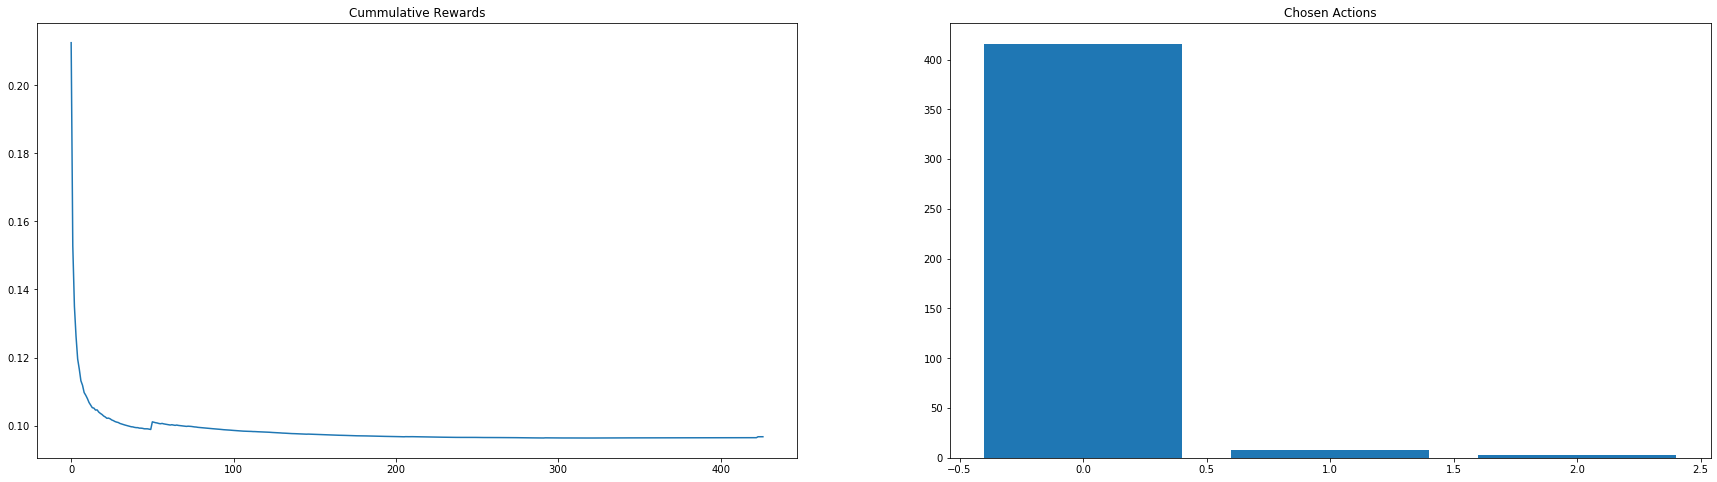

Up to iteration 1003
Average rewards per algo {'quick_sort': 0.053480262500004094, 'merge_sort': 0.031252436729858966, 'heap_sort': 0.21337209999997717}
Count per chosen algo {'quick_sort': 152, 'merge_sort': 422, 'heap_sort': 3}


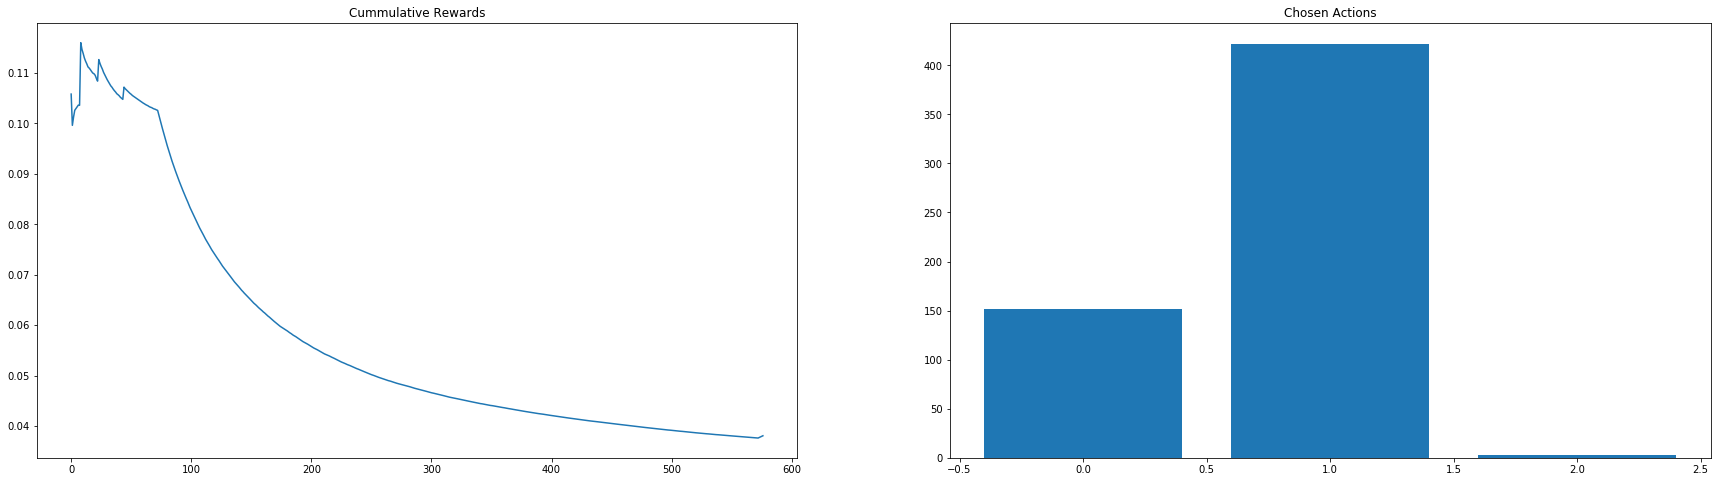

Up to iteration 1503
Average rewards per algo {'quick_sort': 0.09760283197424777, 'merge_sort': 0.10949909999998145, 'heap_sort': 0.21240880000001047}
Count per chosen algo {'quick_sort': 466, 'merge_sort': 28, 'heap_sort': 6}


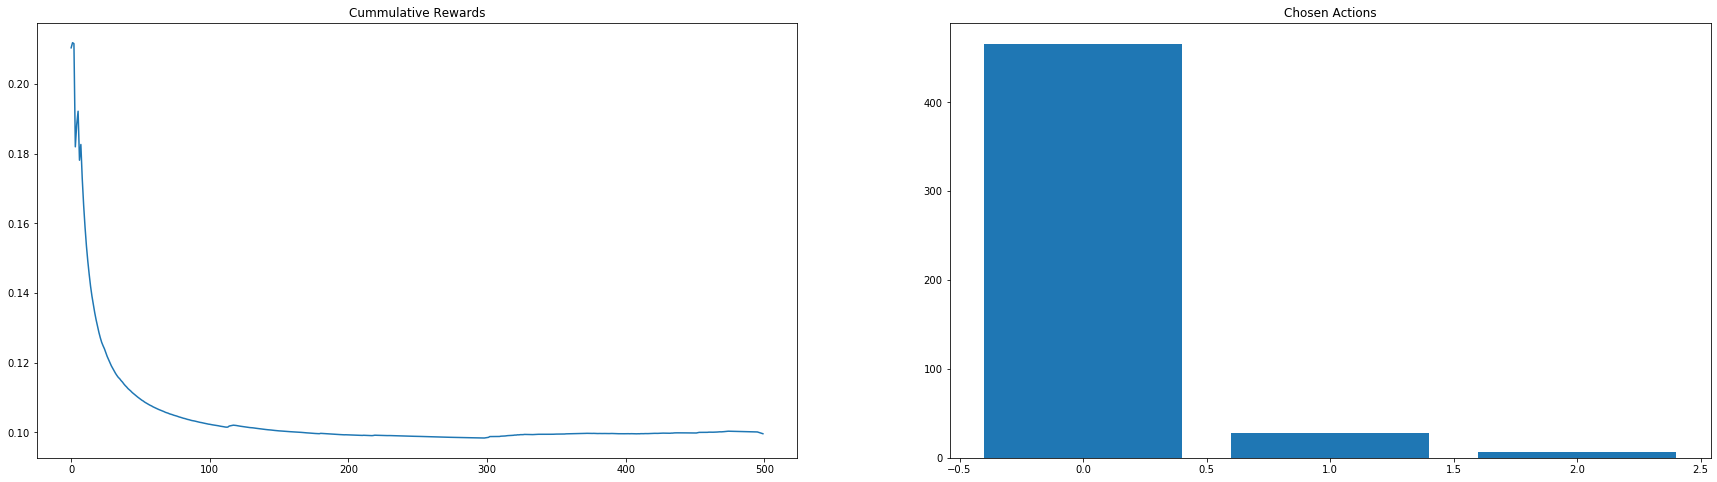

Up to iteration 1999
Average rewards per algo {'quick_sort': 0.03798001250000027, 'merge_sort': 0.02761218016877485, 'heap_sort': 0.07449343333331626}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 474, 'heap_sort': 6}


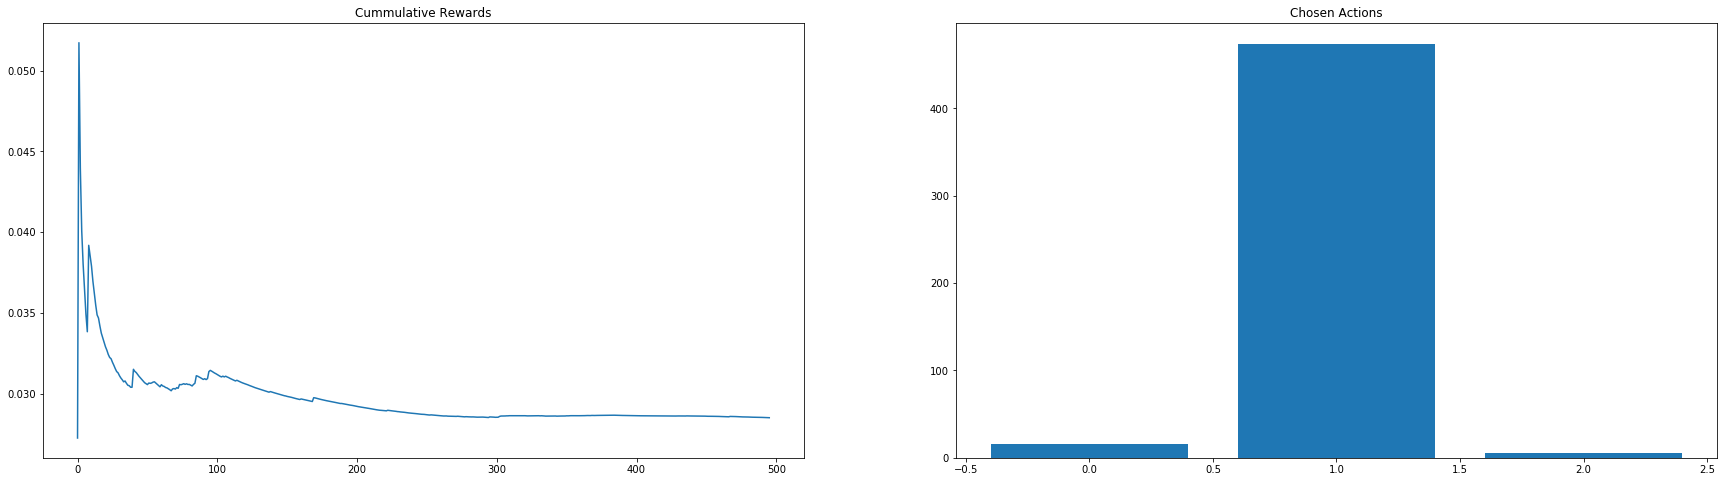

Total reward 127.2244


In [18]:
for elem in list_iteration_results_obcp:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Up to iteration", n)
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_obcp,4))